<a id="0"></a> <br>
# Used car price prediction

## Intro

### Project description

Developing a model to predict the selling price of a used car. This is a regression problem. Using MAPE (mean percentage absolute error) as a metric, since it is easy to interpret. There is a large dispersion in different classes cars' prices. So in units of measurement the value of the metric would be less clear.

### Main steps

- **Data preprocessing and analysis**

Missing numeric and categorical values were filled in with medians and modes grouped by several other features (like manufacturer, model and year of manufacturing). A lot of hidden duplicates were detected and corrected due to fuzzy search instruments based on Levenshtein distance calculation (fuzzywuzzy library) and regular expressions which helped to reduce cardinality of some categorical features. Using data from VIN numders helped to find missing values in the main categorical features like "make" and "model" (vininfo library) which helped a lot im more precise fitting.
Some quantity of anomalies and outliers was deleted from training dataset (like unreasonably high price or price close to zero, cars manufactured later then selled, very old cars which quantity was too small to fit a model properly etc.) and this affected models' metrics very positively. Several categorical features with high cardinality could be a problem for one-hot encoding and a risk of overfitting so for linear models and RandomForest fitting their cardinality was decreased to a reasonable level, which made pipelines with this models go much faster and more productive.
All the numeric values distributions are not normal. "Sellingprice" (target) and "odometer" values distributions have long right tails, "year" values distribution has a long left tail and together with "condition" has multiple peaks as they both are not really continuous values. Using logarithm could help with it.
Phik correlation matrix shows not very high values of linear connection between features and target which makes us think of a nonlinear nature of the relationships. The main features connected to the selling price are "model" (0.49), "make" (0.46), "odometer" (0.43), "condition" (0.40) and "year" (0.39) which is logical.

- **Baseline creating**

Lasso linear model which L1 regularization should have helped to determine less informative features scored only 61% MAPE value which is reasonable due to nonlinear nature of the relationships mentioned above and confirmed with RandomForest model much better score of 19% MAPE (interesting that without numeric features scaling RandomForest scored only 68%). And the best result - 17% MAPE from CatBoost. First 2 models were used as more simple and to help with feature selection, last one as it can fit the features with minimum preprocessing required and provide a decent score out of the box.

- **Feature engineering and selection**

Added "age" feature which is equal to year, but doesn't depend on the year of sale (there are sales dated with 2014 and 2015 years represented in the dataset); "cluster" (ranged features to 5 clusters with Kmeans and used as a new feature) which appeared to be not a very informative feature; "odoyear" (annual mileage) which also didn't improve any model; "country" and "region" of manufacturing extracted from VIN and supposed to give additional clue about price level when "make"/"model" are new to a model (didn't manage to register any improvement, maybe because most of "make"/"model" from test dataset were learned from the training one). Also made manual target encoding for "make" and "model" features which in combintion with One-Hot or Ordinal encoding of the other categorical features provided better scores from Linear model and Random forest than CatBoostEncoder used with all the categorical features. Tried Mutual info regression, Variance Inflation Factor and PCA based methods for the feature selection and Mutual info regression provided the best result of them. All the feature importance analysis methods were confirming that "transmission" is the less informative feature (which is logical as one value has 97% part), "color" and "interior" as well (which is logical too as body and interior colors doesn't seem to be main car price components).

- **Modeling with hyperparameters optimization**

Tried ElasticNet model with "alpha" parameter search via GridSearchCV (53% MAPE), didn't try polynomial features in order to describe nonlinear relations better (maybe next time), RandomForest with multiple parameters adjustment via RandomizedSearchCV to make it not so long (17% MAPE) and CatBoost with multiple parameters optimization via OptunaSearchCV on modified features with manual target encoding for "make" and "model" (15.7% MAPE) and on original features (14.9% MAPE), explained feature importance via SHAP, then dropped 3 less informative features (described above) and scored 14.67% MAPE. And due to the target distribution is not normal I used logarithm in TransformedTargetRegressor to help model and improved the best model's result to 13.43% MAPE. Bagging technique with 2 or 3 gradient boosting models could be used for a further metric optimization (for competition purposes), but it is not very practical for real cases.

- **Testing the best model**

The best model scored 13.59% MAPE on the testing dataset which is really close to it's performance on the training data which means there is no overfitting. It confirms that CatBoost does enough data optimization automatically and the best result was achieved due to a correct raw data preprocessing (missing values filling, duplicates correction, anomalies and outliers elimination) and hyperparameters optimization via Optuna.  

### Data description

- **train.csv** - training dataset (~440000)
- **test.csv** - testing dataset (~110000)

### Features description

- **date:** year of manufacturing
- **make:** manufacturer's name
- **model:** car model
- **trim:** model's options
- **body:** body type
- **transmission:** transmission type
- **vin:** vehicle identification number
- **state:** country state
- **condition:** car condition grade
- **odometer:** car mileage
- **color:** body color
- **interior:** interior color
- **seller:** car seller
- **saledate:** date of selling
- **sellingprice:** price of selling (target)

### Environment

In [58]:
#pip install sweetviz
#pip install phik
#pip install vininfo[cli]
#pip install python-Levenshtein==0.12.0
#pip install fuzzywuzzy
#pip install catboost
#pip install shap
#pip install streamlit
#pip install category_encoders

### Stack

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import sweetviz as sv

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import re

import phik
from phik.report import plot_correlation_matrix
from phik import report
from vininfo import Vin
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from catboost import CatBoostRegressor

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import optuna
import shap

import warnings

import pickle

### Settings

In [3]:
#options
pd.options.mode.chained_assignment=None
pd.options.display.max_rows = 999

In [4]:
#warnings
warnings.filterwarnings('ignore')

In [5]:
#plot_styles
#plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
sns.set_context('paper')

In [6]:
#plot_params
plt_params = {
    'axes.titlesize': '16',
    'axes.labelsize': '14',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.labelsize': '12',
    'ytick.labelsize': '12',
    'legend.fontsize': '12',
    'lines.linewidth': '2.0',
}

plt.rcParams.update(plt_params)

### Constants

In [2]:
train = pd.read_csv('train.csv', parse_dates=[14])
test = pd.read_csv('test.csv', parse_dates=[13])
samplesubmission = pd.read_csv('sample_submission.csv')
RS = 42
TS = .25
CT = .01 #cardinality treshold
CT2 = 1000 #cardinality treshold

## EDA

###  Preparatory DA
[В начало](#0)

#### functions

In [8]:
def describe_data(data):
    display(data.sample(5))
    print('**********')
    data['saledate'] = pd.to_datetime(data['saledate'], utc=True)
    print('Информация по датафрейму:')
    display(data.info())
    print('**********')
    print('Кол-во уникальных значений по столбцам:')
    display(train.nunique())
    print('**********')
    print('Распределение признаков:')
    display(data.describe(include='all', datetime_is_numeric=True).T)
    print('**********')
    print('Линейные связи признаков:')
    display(data.corr(method='spearman'))

In [9]:
def plot_scatter_matrix(data):
    g = sns.pairplot(data, diag_kind='kde', corner=True)  
    g.fig.set_size_inches(12,12)
    g.fig.suptitle("Попарное распределение численных переменных", y=1.01);

#### output

##### train

In [11]:
describe_data(train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
196811,2008,Honda,Pilot,EX,SUV,automatic,5fnyf18458b028128,fl,2.9,145725.0,gray,gray,dab auto world & leasing,6700,2015-02-03 08:00:00+08:00
51363,2011,Infiniti,G Sedan,G37 Journey,G Sedan,automatic,jn1cv6ap9bm510553,fl,4.1,34282.0,gray,black,nissan infiniti lt,18800,2015-02-04 01:00:00+08:00
431352,2003,Kia,Spectra,Base,Sedan,automatic,knafb121835235847,ga,2.0,191247.0,brown,gray,titlebucks/newnan ga,500,2015-01-15 04:30:00+08:00
180895,2009,Nissan,Xterra,X,SUV,automatic,5n1an08u39c504868,fl,3.8,95310.0,silver,gray,universal nissan,9700,2015-01-28 01:25:00+08:00
392784,2012,Mercedes-Benz,C-Class,C250 Sport,Sedan,automatic,wddgf4hb4cr231564,ga,3.8,33052.0,—,gray,mercedes-benz financial services,20500,2015-02-04 02:00:00+08:00


**********
Информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          432193 non-null  object             
 2   model         432113 non-null  object             
 3   trim          431899 non-null  object             
 4   body          429843 non-null  object             
 5   transmission  388775 non-null  object             
 6   vin           440236 non-null  object             
 7   state         440236 non-null  object             
 8   condition     430831 non-null  float64            
 9   odometer      440167 non-null  float64            
 10  color         439650 non-null  object             
 11  interior      439650 non-null  object             
 12  seller        440236 non-null  object             
 13  selling

None

**********
Кол-во уникальных значений по столбцам:


year                34
make                92
model              959
trim              1922
body                85
transmission         2
vin             440236
state               38
condition           41
odometer        159364
color               20
interior            17
seller           13025
sellingprice      1735
saledate          3597
dtype: int64

**********
Распределение признаков:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
year,440236.0,NaN,NaN,NaN,2010.040101,1982.0,2007.0,2012.0,2013.0,2015.0,3.977945
make,432193,92,Ford,73708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,432113,959,Altima,15454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trim,431899,1922,Base,43853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body,429843,85,Sedan,157639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,388775,2,automatic,375061,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vin,440236,440236,2fmdk3jc4bba41556,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,440236,38,fl,65618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,430831.0,NaN,NaN,NaN,3.425077,1.0,2.7,3.6,4.2,5.0,0.949973
odometer,440167.0,NaN,NaN,NaN,68344.421604,1.0,28258.0,52098.0,99272.0,999999.0,53542.203908


**********
Линейные связи признаков:


,year,condition,odometer,sellingprice
year,1.000000,0.547168,-0.817030,0.680228
condition,0.547168,1.000000,-0.566307,0.617279
odometer,-0.817030,-0.566307,1.000000,-0.705121
sellingprice,0.680228,0.617279,-0.705121,1.000000


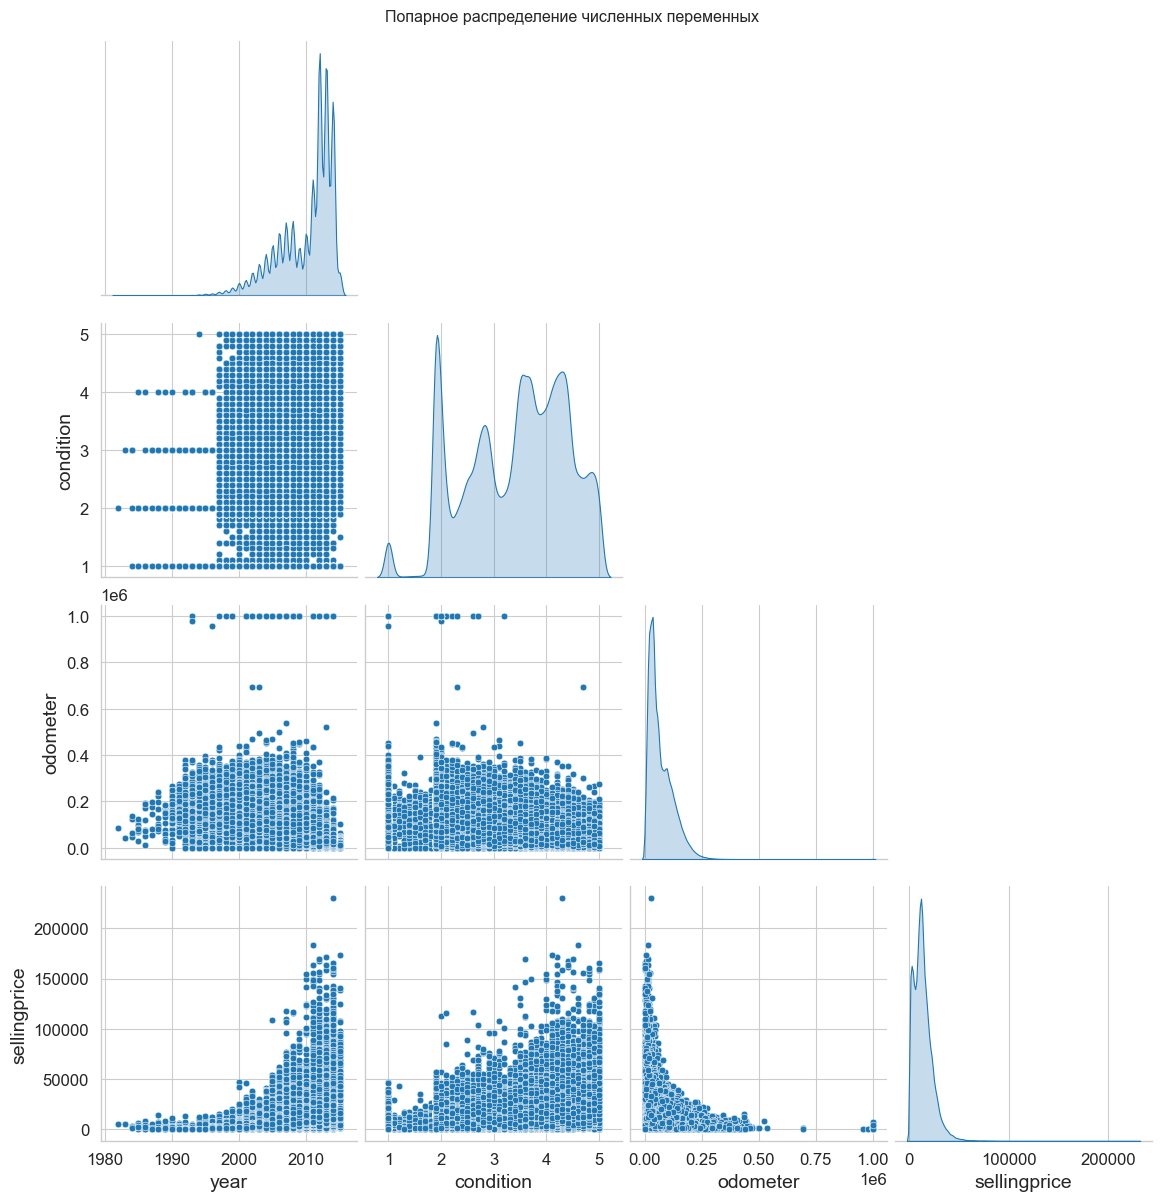

In [12]:
plot_scatter_matrix(train)

##### test

In [13]:
describe_data(test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
95650,2007,Chevrolet,TrailBlazer,LS,SUV,automatic,1gnds13s172212698,ga,2.7,134540.0,silver,gray,santander consumer,2015-01-06 01:30:00+08:00
97829,2012,Hyundai,Elantra,Limited,Sedan,NaN,kmhdh4ae1cu313398,pa,4.4,33549.0,red,black,hyundai motor finance,2015-01-16 01:00:00+08:00
77461,2013,Ford,Explorer,XLT,SUV,automatic,1fm5k7d86dgb56304,fl,3.5,40024.0,black,black,onesource/kendall toyota,2015-02-10 01:30:00+08:00
50339,2014,Chrysler,200,Limited,Sedan,NaN,1c3ccbcgxen178117,on,5.0,30240.0,white,black,chrysler canada inc,2015-01-13 12:00:00+08:00
59179,2013,Toyota,Sienna,LE 7-Passenger Mobility Auto Access,Minivan,automatic,5tdkk3dcxds338470,mo,3.6,61295.0,black,gray,the hertz corporation,2015-02-04 02:00:00+08:00


**********
Информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          110058 non-null  int64              
 1   make          107997 non-null  object             
 2   model         107979 non-null  object             
 3   trim          107944 non-null  object             
 4   body          107464 non-null  object             
 5   transmission  97047 non-null   object             
 6   vin           110058 non-null  object             
 7   state         110058 non-null  object             
 8   condition     107679 non-null  float64            
 9   odometer      110039 non-null  float64            
 10  color         109900 non-null  object             
 11  interior      109900 non-null  object             
 12  seller        110058 non-null  object             
 13  saledat

None

**********
Кол-во уникальных значений по столбцам:


year                34
make                92
model              959
trim              1922
body                85
transmission         2
vin             440236
state               38
condition           41
odometer        159364
color               20
interior            17
seller           13025
sellingprice      1735
saledate          3597
dtype: int64

**********
Распределение признаков:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
year,110058.0,NaN,NaN,NaN,2010.060005,1982.0,2007.0,2012.0,2013.0,2015.0,3.96019
make,107997,85,Ford,18383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,107979,824,Altima,3736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trim,107944,1496,Base,11007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body,107464,77,Sedan,39255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,97047,2,automatic,93584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vin,110058,110058,1g6dp567450124779,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,110058,38,fl,16295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,107679.0,NaN,NaN,NaN,3.423222,1.0,2.7,3.6,4.2,5.0,0.951301
odometer,110039.0,NaN,NaN,NaN,68074.331601,1.0,28313.5,51922.0,98852.5,999999.0,53520.988173


**********
Линейные связи признаков:


,year,condition,odometer
year,1.000000,0.543107,-0.815717
condition,0.543107,1.000000,-0.563637
odometer,-0.815717,-0.563637,1.000000


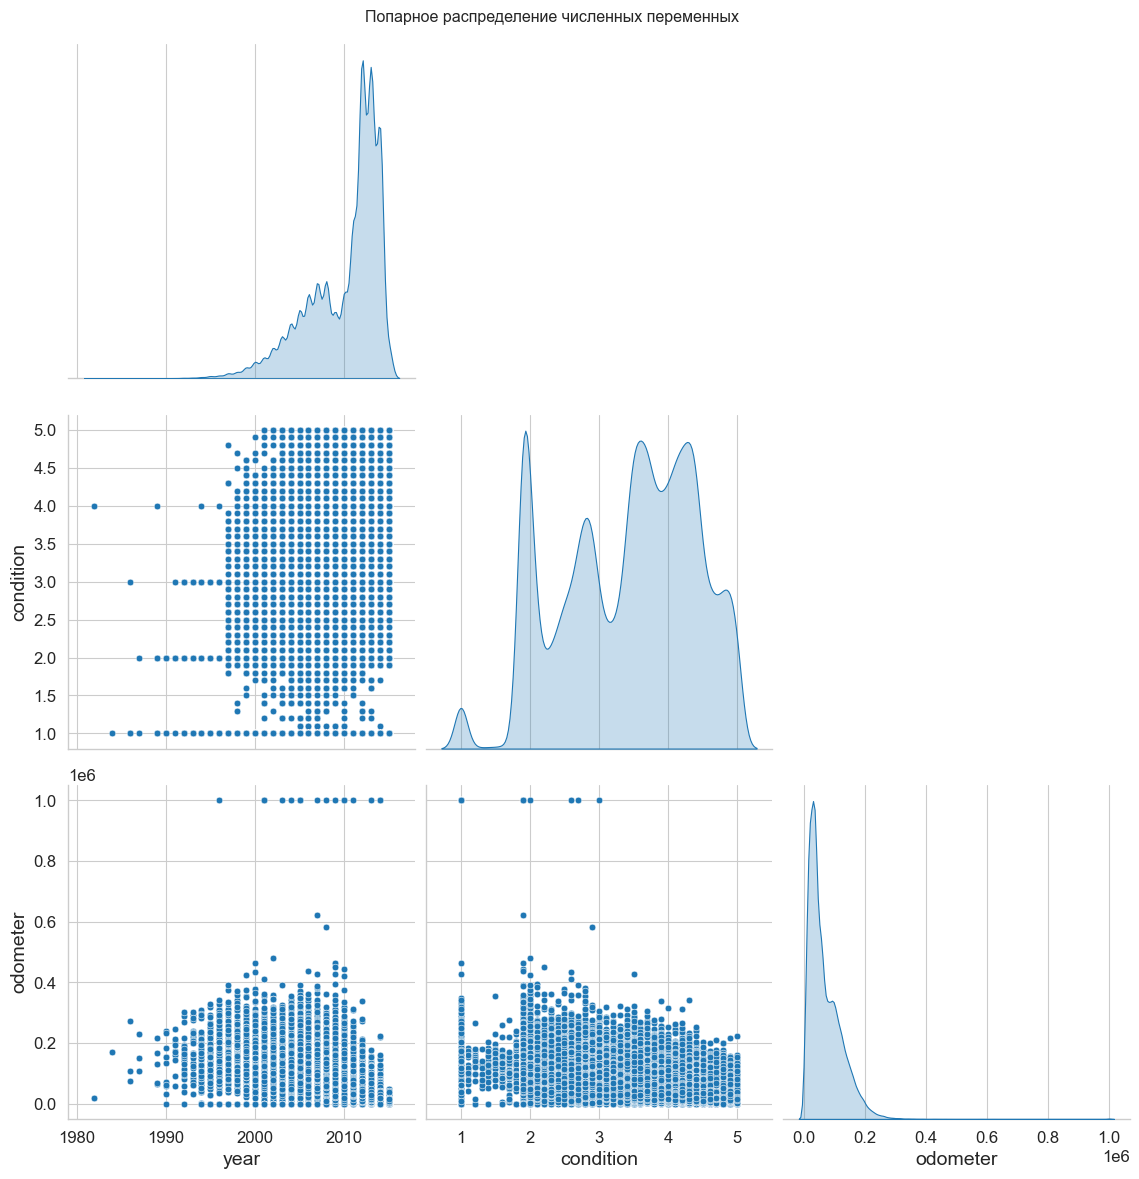

In [14]:
#plot_numeric(test)
plot_scatter_matrix(test)

### Interactive Data Profiling
[В начало](#0)

#### train

In [321]:
report_train = sv.analyze(train)

                                             |      | [  0%]   00:00 -> (? left)

In [322]:
#report_train.show_notebook() - запустить, если потребуется увидеть отчет прямо в блокноте

In [324]:
#report_train.show_html('train_analysis.html') - отчет приложен к ноутбуку отдельным файлом html

#### test

In [325]:
report_test = sv.analyze(test)

                                             |      | [  0%]   00:00 -> (? left)

In [326]:
#report_test.show_notebook() - запустить, если потребуется увидеть отчет прямо в блокноте

In [331]:
#report_test.show_html('test_analysis.html') - отчет приложен к ноутбуку отдельным файлом html

#### comparison

In [328]:
compare_report = sv.compare(train,test)

                                             |      | [  0%]   00:00 -> (? left)

In [329]:
#compare_report.show_notebook() - запустить, если потребуется увидеть отчет прямо в блокноте

In [332]:
#compare_report.show_html('train_test_compare_analysis.html') - отчет приложен к ноутбуку отдельным файлом html

### Preprocessing
[В начало](#0)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          432193 non-null  object             
 2   model         432113 non-null  object             
 3   trim          431899 non-null  object             
 4   body          429843 non-null  object             
 5   transmission  388775 non-null  object             
 6   vin           440236 non-null  object             
 7   state         440236 non-null  object             
 8   condition     430831 non-null  float64            
 9   odometer      440167 non-null  float64            
 10  color         439650 non-null  object             
 11  interior      439650 non-null  object             
 12  seller        440236 non-null  object             
 13  sellingprice  440236 non-null  int64        

#### DTYPES
[В начало](#0)

In [22]:
train['saledate'] = pd.to_datetime(train['saledate'], utc=True)
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)

#### MISSING VALUES (PART_1)
[В начало](#0)

##### Common

In [23]:
def data_isna(data):
    print('Кол-во пропусков по столбцам:')
    display(data.isna().sum())
    plt.figure(figsize = (8, 4))
    data.isna().mean()[data.isna().mean() > 0].plot(kind='bar', grid=True)
    plt.title('Пропуски в данных по признакам')
    plt.show();

###### train

Кол-во пропусков по столбцам:


year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

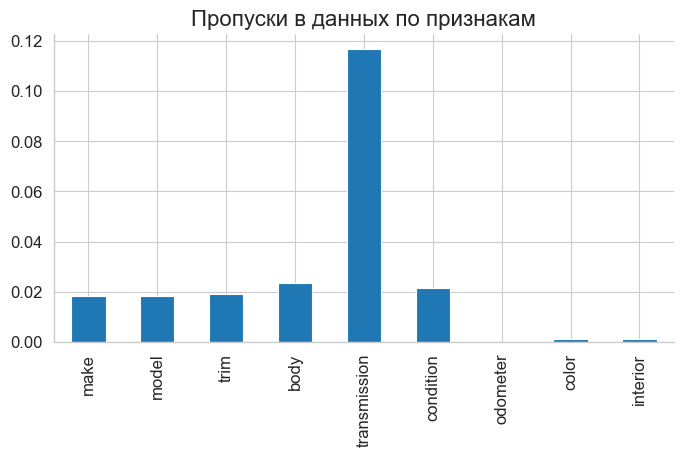

In [24]:
data_isna(train)

###### test

Кол-во пропусков по столбцам:


year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

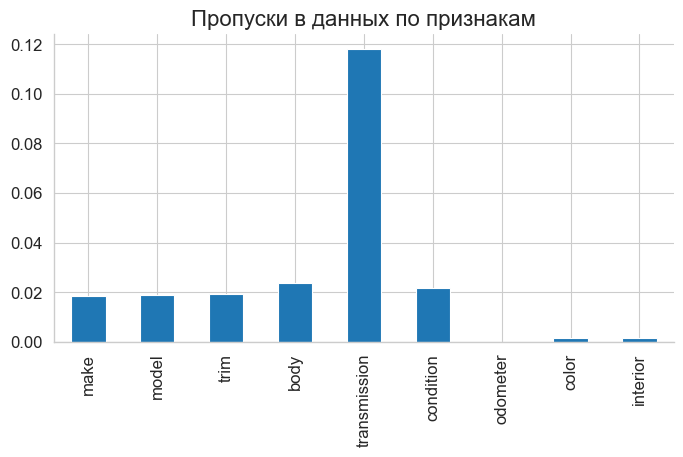

In [25]:
data_isna(test)

##### make

Для начала попробуем восстановить информацию о пропусках в марках машин по информации о моделях и комплектациях.

In [26]:
def find_isna_clue(data):
    print('**********')
    print('Модели машин с пропусками в марке:')
    display(data[data['make'].isna()].model.unique())
    print('**********')
    print('Комплектации машин с пропусками в марке:')
    display(data[data['make'].isna()].trim.unique())

VIN-номера содержат в себе различную информацию об авто, а также в этом поле нет пропусков. Как минимум можно попробовать заполнить пропуски в данных о марке авто, тем более, что в большинстве случаев модели этих машин также неизвестны.

In [27]:
def get_make_from_vin(data):
    mask = data['make'].isna()
    data['vin'] = data['vin'].astype(str)
    data['make'][mask] = data['vin'][mask].apply(lambda x: Vin(x).manufacturer)
    return data

In [28]:
def col_isna(data):
    for col in cols:
        print('**********')
        print(f'Кол-во пропусков в столбце {col} после заполнения:')
        display(data[col].isna().sum())
        print('**********')
        print(f'Список уникальных значений {col} после заполнения:')
        display(data[col].sort_values().unique())

In [29]:
cols = ['make']

###### train

In [33]:
find_isna_clue(train)

**********
Модели машин с пропусками в марке:


array([nan], dtype=object)

**********
Комплектации машин с пропусками в марке:


array([nan], dtype=object)

Безуспешно, переходим к заполнению пропусков через информацию в VIN

In [34]:
train = get_make_from_vin(train)
col_isna(train)

**********
Кол-во пропусков в столбце make после заполнения:


0

**********
Список уникальных значений make после заполнения:


array(['AM', 'Acura', 'Aston Martin', 'Audi', 'BMW', 'BMW M', 'Bentley',
       'Buick', 'CAMI', 'Cadillac', 'Chevrolet', 'Chevrolet Canada',
       'Chevrolet Mexico', 'Chevrolet USA', 'Chrysler', 'Chrysler Canada',
       'Daewoo', 'Daimler AG (Sprinter)', 'DaimlerChrysler AG/Daimler AG',
       'Dodge', 'Dodge Canada', 'Dodge Mexico', 'FIAT', 'Ferrari', 'Fiat',
       'Fisker', 'Ford', 'GMC', 'GMC Truck', 'Genesis', 'Geo', 'HUMMER',
       'Honda', 'Hummer', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar',
       'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln',
       'MINI', 'Maserati', 'Mazda', 'Mercedes-Benz',
       'Mercedes-Benz (Sprinter)', 'Mercury', 'Mitsubishi', 'Nissan',
       'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Porsche SUV',
       'Porsche car', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn', 'Scion',
       'Smart', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'UnsupportedBrand',
       'Volkswagen', 'Volkswagen Commercial Vehicles', 'Volvo', 'acura',
       'a

In [35]:
train[train['make'] == 'UnsupportedBrand'].shape[0]

4

###### test

In [36]:
find_isna_clue(test)

**********
Модели машин с пропусками в марке:


array([nan], dtype=object)

**********
Комплектации машин с пропусками в марке:


array([nan], dtype=object)

Безуспешно, переходим к заполнению пропусков через информацию в VIN

In [37]:
test = get_make_from_vin(test)
col_isna(test)

**********
Кол-во пропусков в столбце make после заполнения:


0

**********
Список уникальных значений make после заполнения:


array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick', 'CAMI',
       'Cadillac', 'Chevrolet', 'Chevrolet Canada', 'Chevrolet Mexico',
       'Chevrolet USA', 'Chrysler', 'Chrysler Canada', 'Daewoo',
       'DaimlerChrysler AG/Daimler AG', 'Dodge', 'Dodge Canada',
       'Dodge Mexico', 'FIAT', 'Ferrari', 'Fisker', 'Ford', 'GMC',
       'GMC Truck', 'Genesis', 'Geo', 'HUMMER', 'Honda', 'Hyundai',
       'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Land Rover',
       'Lexus', 'Lexus Canada', 'Lincoln', 'Lotus', 'MINI', 'Maserati',
       'Mazda', 'Mercedes-Benz', 'Mercedes-Benz (Sprinter)', 'Mercury',
       'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac',
       'Porsche', 'Porsche car', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn',
       'Scion', 'Smart', 'Subaru', 'Suzuki', 'Tesla', 'Toyota',
       'Volkswagen', 'Volvo', 'acura', 'audi', 'bmw', 'buick', 'cadillac',
       'chev truck', 'chevrolet', 'chrysler', 'dodge', 'ford', 'ford tk',
       'gmc', 'honda', 

In [38]:
test[test['make'] == 'UnsupportedBrand'].shape[0]

0

##### Transmission

In [41]:
train['transmission'].value_counts(normalize=True)

automatic    0.964725
manual       0.035275
Name: transmission, dtype: float64

In [42]:
test['transmission'].value_counts(normalize=True)

automatic    0.964316
manual       0.035684
Name: transmission, dtype: float64

In [43]:
# заполняем пропуски самым распространенным значением, так как второе практически не фигурирует
train['transmission'].fillna('automatic', inplace=True)
test['transmission'].fillna('automatic', inplace=True)

In [44]:
train['transmission'].isna().sum(), test['transmission'].isna().sum()

(0, 0)

#### DUPLICATES
[В начало](#0)

In [45]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

##### functions

In [46]:
# приведение к нижнему регистру значений в кат. переменных
def lowercase_values(data):
    print('**********')
    print('Кол-во уникальных значений до снижения регистра:')
    display(data.select_dtypes('object').nunique())
    for col in data.select_dtypes('object').columns:
        data[col] = data[col].str.lower()
    print('**********')
    print('Кол-во уникальных значений после снижения регистра:')
    display(data.select_dtypes('object').nunique())

In [47]:
def unique_research(data):
    for col in cols:
        print('**********')
        print('Кол-во уникальных значений:')
        display(len(data[col].unique()))
        print('**********')
        print('Список уникальных значений:') 
        display(data[col].sort_values().unique())
        print('**********')
        print('Частота уникальных значений:') 
        display(data[col].value_counts(dropna=False, normalize=True))

In [48]:
# для подбора возможных неявных дубликатов в переменных make и model
def find_close_pairs(col):
    possible_duplicates = []
    for item in col:
        col = np.delete(col, 0)
        for elem in col:
            try:
                if fuzz.partial_ratio(item, elem) >= 70:
                    possible_duplicates.append((item, elem))
            except: continue
    return possible_duplicates

In [49]:
# для переменной body
def clear_body(row):
    try:
        for body_type in body_types:
            if body_type in row:
                return body_type
        return row
    except:
        return row

In [50]:
# замена неявных дубликатов
def replace_duplicates(data):
    for col in cols:
        data[col] = data[col].replace(to_replace_list, replacement_list)
        print('Кол-во уникальных значений после замены')
        display(data[col].nunique())

In [51]:
# удаление лишних символов
def delete_duplicates(data):
    for col in cols:
        for duplicate in duplicates:
            data[col] = data[col].str.replace(duplicate,'')
        print('Кол-во уникальных значений после удаления')
        display(data[col].nunique())

In [52]:
#  удаление из строк лишних символов с помощью решулярных выражений
def clear_text(text):
    raw_text = re.sub(r'[^0-9a-z ]', ' ', text) 
    final_text = " ".join(raw_text.split())
    return final_text

##### common

Часть неявных дубликатов поможет отбросить приведение строковых значений к нижнему регистру.

###### train

In [53]:
lowercase_values(train)

**********
Кол-во уникальных значений до снижения регистра:


make               113
model              959
trim              1922
body                85
transmission         2
vin             440236
state               38
color               20
interior            17
seller           13025
dtype: int64

**********
Кол-во уникальных значений после снижения регистра:


make                79
model              839
trim              1850
body                45
transmission         2
vin             440236
state               38
color               20
interior            17
seller           13025
dtype: int64

###### test

In [54]:
lowercase_values(test)

**********
Кол-во уникальных значений до снижения регистра:


make                99
model              824
trim              1496
body                77
transmission         2
vin             110058
state               38
color               20
interior            17
seller            7623
dtype: int64

**********
Кол-во уникальных значений после снижения регистра:


make                71
model              746
trim              1457
body                42
transmission         2
vin             110058
state               38
color               20
interior            17
seller            7623
dtype: int64

##### make

С помощью нечеткого подбора (библиотека fuzzywuzzy) на основе измерения расстояния Левенштейна отбираем возможные пары неявных дубликатов и заменяем их через функцию

In [55]:
cols = ['make']

In [56]:
duplicates = [
    '(', ')', ' truck', ' tk', ' usa', ' mexico', ' canada', 
    ' sprinter', ' commercial vehicles', ' car', ' suv'
]

In [57]:
to_replace_list = [
    'daimler ag', 'mercedes-b', 'mercedes', 'vw', 'bmw m', 'dot',
    'landrover', 'daimlerchrysler ag/daimler ag', 'am', 'cami', 'chev'
]
replacement_list = [
    'mercedes-benz', 'mercedes-benz', 'mercedes-benz', 'volkswagen', 'bmw',
    'dodge', 'land rover', 'chrysler', 'hummer', 'gmc', 'chevrolet'
]

In [58]:
find_close_pairs(train['make'].unique())

[('ford', 'ford truck'),
 ('chevrolet', 'chevrolet usa'),
 ('chevrolet', 'chevrolet mexico'),
 ('chevrolet', 'chevrolet canada'),
 ('acura', 'ram'),
 ('cadillac', 'audi'),
 ('cadillac', 'cami'),
 ('gmc', 'gmc truck'),
 ('dodge', 'dodge canada'),
 ('dodge', 'dodge mexico'),
 ('dodge', 'geo'),
 ('dodge', 'dodge tk'),
 ('mercedes-benz', 'mercedes'),
 ('mercedes-benz', 'mercedes-benz (sprinter)'),
 ('mercedes-benz', 'mercedes-b'),
 ('volkswagen', 'volkswagen commercial vehicles'),
 ('mazda', 'mazda tk'),
 ('bmw', 'bmw m'),
 ('infiniti', 'mini'),
 ('chrysler', 'chrysler canada'),
 ('chrysler', 'daimlerchrysler ag/daimler ag'),
 ('kia', 'suzuki'),
 ('chevrolet usa', 'chevrolet mexico'),
 ('chevrolet usa', 'chevrolet canada'),
 ('mercedes', 'mercedes-benz (sprinter)'),
 ('mercedes', 'mercedes-b'),
 ('chevrolet mexico', 'dodge mexico'),
 ('suzuki', 'isuzu'),
 ('land rover', 'landrover'),
 ('cami', 'am'),
 ('mini', 'lamborghini'),
 ('chrysler canada', 'daimlerchrysler ag/daimler ag'),
 ('chrysl

###### train

In [59]:
delete_duplicates(train)

Кол-во уникальных значений после удаления


65

In [60]:
replace_duplicates(train)

Кол-во уникальных значений после замены


55

In [61]:
unique_research(train)

**********
Кол-во уникальных значений:


55

**********
Список уникальных значений:


array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'ferrari', 'fiat', 'fisker', 'ford', 'genesis', 'geo', 'gmc',
       'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar',
       'jeep', 'kia', 'lamborghini', 'land rover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mercedes-benz', 'mercury', 'mini',
       'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac',
       'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion',
       'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'unsupportedbrand',
       'volkswagen', 'volvo'], dtype=object)

**********
Частота уникальных значений:


ford                0.171047
chevrolet           0.111131
nissan              0.097770
toyota              0.072495
dodge               0.056776
honda               0.049807
hyundai             0.039129
bmw                 0.037782
chrysler            0.032978
kia                 0.032619
mercedes-benz       0.030820
jeep                0.028092
infiniti            0.027538
volkswagen          0.022704
lexus               0.022013
gmc                 0.019262
mazda               0.016057
cadillac            0.014152
acura               0.010744
audi                0.010608
lincoln             0.010542
buick               0.009193
subaru              0.009131
mitsubishi          0.008689
pontiac             0.008307
ram                 0.008159
volvo               0.006719
mini                0.005617
saturn              0.005113
land rover          0.004270
mercury             0.003753
scion               0.003380
porsche             0.002676
jaguar              0.002505
suzuki        

###### test

In [64]:
delete_duplicates(test)

Кол-во уникальных значений после удаления


59

In [65]:
replace_duplicates(test)

Кол-во уникальных значений после замены


53

In [66]:
unique_research(test)

**********
Кол-во уникальных значений:


53

**********
Список уникальных значений:


array(['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick',
       'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge', 'ferrari',
       'fiat', 'fisker', 'ford', 'genesis', 'geo', 'gmc', 'honda',
       'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia',
       'land rover', 'lexus', 'lincoln', 'lotus', 'maserati', 'mazda',
       'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo'], dtype=object)

**********
Частота уникальных значений:


ford             0.170946
chevrolet        0.109824
nissan           0.095640
toyota           0.070781
dodge            0.057770
honda            0.049710
hyundai          0.040170
bmw              0.038380
chrysler         0.032919
kia              0.032501
mercedes-benz    0.031820
jeep             0.028467
infiniti         0.027277
volkswagen       0.023051
lexus            0.022906
gmc              0.019090
mazda            0.016092
cadillac         0.014083
lincoln          0.010676
acura            0.010603
audi             0.010304
buick            0.009331
subaru           0.009231
mitsubishi       0.008468
ram              0.008078
pontiac          0.008050
volvo            0.006951
mini             0.006124
saturn           0.004952
land rover       0.004289
mercury          0.004134
scion            0.003189
porsche          0.002708
jaguar           0.002699
suzuki           0.002035
fiat             0.001645
hummer           0.001581
oldsmobile       0.000845
saab        

##### model

С помощью нечеткого подбора (библиотека fuzzywuzzy) на основе измерения расстояния Левенштейна отбираем возможные пары неявных дубликатов и заменяем их через функцию

In [69]:
cols = ['model']

In [70]:
duplicates = [
    ' pickup', ' convertible', ' coupe', ' sedan', ' cargo', ' van', ' wagon', ' truck'
]

In [71]:
to_replace_list = [
    'twn/cntry', 'twn&country', 'town &', 'rangerover', 'expedit', 
    'pathfind', 'siera', 'subrbn', 'uplandr', 'mountnr', 
    'mazdaspeed 3', 'mazdaspeed3', 'grand v', 'grand carav', 'grand caravn', 
    'grand cher', 'capt', 'excurs', 'expeditn', 'ram3500',
    'pt', '3', '6', 'b9 tribeca'
]

replacement_list = [
    'town and country', 'town and country', 'town and country', 'range rover', 'expedition',
    'pathfinder', 'sierra', 'suburban', 'uplander', 'mountaineer',
    'mazdaspeed mazda3', 'mazdaspeed mazda3', 'grand vitara', 'grand caravan', 'grand caravan',
    'grand cherokee', 'captiva sport', 'excursion', 'expedition', 'ram 3500',
    'pt cruiser', 'mazda3', 'mazda6', 'tribeca'
]

In [74]:
find_close_pairs(train['model'].unique())

[('edge', 'rendezvous'),
 ('edge', 'avenger'),
 ('edge', 'challenger'),
 ('edge', 'protege'),
 ('edge', 'endeavor'),
 ('edge', 'ridgeline'),
 ('edge', 'ascender'),
 ('edge', 'protege5'),
 ('edge', 'ridgelin'),
 ('edge', 'e'),
 ('edge', 'legend'),
 ('edge', 'mazdaspeed protege'),
 ('edge', 'nv passenger'),
 ('edge', 'regency'),
 ('fusion', 'fusion hybrid'),
 ('fusion', 'ion'),
 ('fusion', 'excursion'),
 ('fusion', 'fusion energi'),
 ('sentra', 'e'),
 ('sentra', 'ram'),
 ('h2', 'h2 sut'),
 ('mkz', 'm'),
 ('mkz', 'mkz hybrid'),
 ('g6', '6'),
 ('escape', 'escape hybrid'),
 ('escape', 'e'),
 ('escape', 'capt'),
 ('elantra', 'elantra touring'),
 ('elantra', 'elantra coupe'),
 ('elantra', 'santa'),
 ('elantra', 'astra'),
 ('elantra', 'elantra gt'),
 ('elantra', 'entourage'),
 ('elantra', 'freelander'),
 ('elantra', 'e'),
 ('elantra', 'el'),
 ('freestyle', 'freestar'),
 ('freestyle', 'e'),
 ('lucerne', 'e'),
 ('windstar', 'windstar cargo'),
 ('silverado 1500', '500l'),
 ('silverado 1500', 'ver

###### train

In [75]:
delete_duplicates(train)

Кол-во уникальных значений после удаления


811

In [76]:
replace_duplicates(train)

Кол-во уникальных значений после замены


793

In [77]:
unique_research(train)

**********
Кол-во уникальных значений:


794

**********
Список уникальных значений:


array(['1 series', '1500', '190-class', '2 series', '200', '200sx',
       '2500', '3 series', '3 series gran turismo', '300', '300-class',
       '3000gt', '300e', '300m', '300zx', '320i', '323i', '328i', '3500',
       '350z', '370z', '4 series', '4 series gran', '400-class',
       '420-class', '420sel', '42c', '458 italia', '4runner', '5 series',
       '5 series gran turismo', '500', '500-class', '500e', '500l',
       '6 series', '6 series gran', '626', '7', '7 series', '750i',
       '750li', '750lxi', '8 series', '850', '9-2x', '9-3', '9-5', '9-7x',
       '911', '940', '960', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'acadia',
       'accent', 'accord', 'accord crosstour', 'accord hybrid',
       'activehybrid 5', 'activehybrid 7', 'activehybrid x6', 'aerio',
       'alero', 'allroad', 'allroad quattro', 'alp', 'altima',
       'altima hybrid', 'amanti', 'amigo', 'armada', 'ascender', 'aspen',
       'aspire', 'astra', 'astro', 'ats', 'aura', 'aura hybrid', 'aurora',
       'avalanc

**********
Частота уникальных значений:


altima                           0.035104
f-150                            0.025913
fusion                           0.023269
camry                            0.022715
escape                           0.021459
focus                            0.018676
NaN                              0.018451
g                                0.016791
accord                           0.016414
3 series                         0.014551
impala                           0.014322
grand caravan                    0.014215
explorer                         0.013888
civic                            0.013509
corolla                          0.013288
malibu                           0.012839
sonata                           0.012343
maxima                           0.011807
cruze                            0.011587
elantra                          0.011455
silverado 1500                   0.011280
town and country                 0.010810
edge                             0.010635
rogue                            0

###### test

In [80]:
delete_duplicates(test)

Кол-во уникальных значений после удаления


724

In [81]:
replace_duplicates(test)

Кол-во уникальных значений после замены


714

In [82]:
unique_research(test)

**********
Кол-во уникальных значений:


715

**********
Список уникальных значений:


array(['1', '1 series', '1500', '2 series', '200', '200sx', '2500',
       '3 series', '3 series gran turismo', '300', '300-class', '3000gt',
       '300e', '300m', '300zx', '350', '3500', '350z', '360', '370z',
       '4 series', '4 series gran', '4runner', '5 series',
       '5 series gran turismo', '500', '500l', '6 series',
       '6 series gran', '626', '7 series', '750i', '750li', '850', '9-2x',
       '9-3', '9-5', '9-7x', '911', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8',
       'acadia', 'accent', 'accord', 'accord crosstour', 'accord hybrid',
       'achieva', 'activehybrid 5', 'activehybrid x6', 'aerio', 'alero',
       'allroad', 'allroad quattro', 'allure', 'alp', 'altima',
       'altima hybrid', 'amanti', 'armada', 'ascender', 'aspen', 'aspire',
       'astra', 'astro', 'ats', 'aura', 'aurora', 'avalanche', 'avalon',
       'avalon hybrid', 'avenger', 'aveo', 'aviator', 'axiom', 'azera',
       'aztek', 'b-class electric drive', 'b-series', 'b1500', 'baja',
       'beetle', 'bla

**********
Частота уникальных значений:


altima                           0.033946
f-150                            0.024869
fusion                           0.023197
camry                            0.022016
escape                           0.020862
NaN                              0.018890
focus                            0.018790
g                                0.016846
accord                           0.016573
3 series                         0.015101
grand caravan                    0.014556
explorer                         0.014183
impala                           0.014002
corolla                          0.013148
civic                            0.012866
sonata                           0.012848
malibu                           0.012821
maxima                           0.011985
elantra                          0.011576
silverado 1500                   0.011339
town and country                 0.010758
cruze                            0.010676
edge                             0.010222
c-class                          0

##### trim

In [85]:
cols = ['trim']

Здесь удаление лишних символов при помощи регулярных выражений убирает порядка 10 уникальных значений, однако при этом уходят в пропуски значения, состоящие только из знаков. Учитывая высокую кардинальность признака тут будет проще оставить только самые частотные категории, остальное объединить в редкие.

###### train

In [86]:
unique_research(train)

**********
Кол-во уникальных значений:


1851

**********
Список уникальных значений:


array(['!', '& coun fwd', '& coun fwd limited', ..., 'zx5 ses', 'zxw ses',
       nan], dtype=object)

**********
Частота уникальных значений:


base                      0.099665
se                        0.078363
lx                        0.037505
limited                   0.032973
lt                        0.030509
                            ...   
executive pzev            0.000002
4c base                   0.000002
3500 sh ceiling 158 wb    0.000002
chevy van base            0.000002
4x4 v6 xlt sport          0.000002
Name: trim, Length: 1851, dtype: float64

###### test

In [87]:
unique_research(test)

**********
Кол-во уникальных значений:


1458

**********
Список уникальных значений:


array(['!', '& coun fwd limited', '& country lx', ..., 'zx5 ses',
       'zxw ses', nan], dtype=object)

**********
Частота уникальных значений:


base                0.100029
se                  0.079276
lx                  0.037235
limited             0.032129
lt                  0.029802
                      ...   
4wd s               0.000009
hx                  0.000009
gr tr gr touring    0.000009
mr touring          0.000009
awd xs ll bean      0.000009
Name: trim, Length: 1458, dtype: float64

##### body

В данном столбце хорошо прослеживаются неявные дубликаты от основных 9 значений, приведем все значения к ним для удобства дальнейшей работы.

In [88]:
cols = ['body']

In [89]:
to_replace_list = ['koup', 'supercrew']

replacement_list = ['coupe', 'cab']

In [90]:
body_types = [
            'cab',
            'convertible',
            'coupe',
            'hatchback',
            'minivan',
            'sedan',
            'suv',
            'van',
            'wagon'
        ]

In [91]:
train['body'].value_counts(dropna=False).head(15)

sedan           190861
suv             113042
hatchback        20715
minivan          20114
coupe            13896
crew cab         12823
wagon            12600
NaN              10393
convertible       8183
supercrew         7081
g sedan           5859
supercab          4143
regular cab       3861
van               3544
extended cab      3500
Name: body, dtype: int64

###### train

In [92]:
train['body'] = train['body'].apply(clear_body)

In [93]:
train['body'].value_counts(dropna=False)

sedan          196720
suv            113042
cab             30162
hatchback       20715
minivan         20114
coupe           15656
wagon           12639
NaN             10393
convertible      8547
supercrew        7081
van              5032
koup              135
Name: body, dtype: int64

In [94]:
replace_duplicates(train)

Кол-во уникальных значений после замены


9

In [95]:
train['body'].value_counts(dropna=False)

sedan          196720
suv            113042
cab             37243
hatchback       20715
minivan         20114
coupe           15791
wagon           12639
NaN             10393
convertible      8547
van              5032
Name: body, dtype: int64

###### test

In [96]:
test['body'] = test['body'].apply(clear_body)

In [97]:
replace_duplicates(test)

Кол-во уникальных значений после замены


9

In [98]:
test['body'].value_counts(dropna=False)

sedan          48970
suv            28295
cab             9202
hatchback       5152
minivan         5091
coupe           3995
wagon           3287
NaN             2594
convertible     2149
van             1323
Name: body, dtype: int64

##### vin

Все значения вин-номеров уникальны.

In [99]:
train.vin.nunique(), test.vin.nunique()

(440236, 110058)

##### state

38 совпадающих уникальных штатов в каждой выборке.

In [100]:
cols = ['state']

###### train

In [101]:
unique_research(train)

**********
Кол-во уникальных значений:


38

**********
Список уникальных значений:


array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

**********
Частота уникальных значений:


fl    0.149052
ca    0.130401
pa    0.096453
tx    0.082011
ga    0.061651
nj    0.050205
il    0.042366
nc    0.038731
oh    0.038523
tn    0.036698
mo    0.028537
mi    0.028151
nv    0.022329
va    0.021452
md    0.020121
wi    0.017868
mn    0.016891
az    0.015680
co    0.013897
wa    0.013363
ma    0.012091
ny    0.010297
in    0.007844
sc    0.007530
ne    0.007298
on    0.006183
pr    0.004911
la    0.003955
ms    0.003335
ut    0.003296
qc    0.002272
hi    0.002253
or    0.002108
ab    0.001656
nm    0.000295
ok    0.000136
ns    0.000118
al    0.000043
Name: state, dtype: float64

###### test

In [102]:
unique_research(test)

**********
Кол-во уникальных значений:


38

**********
Список уникальных значений:


array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

**********
Частота уникальных значений:


fl    0.148058
ca    0.129059
pa    0.097621
tx    0.081266
ga    0.062349
nj    0.050174
il    0.042305
oh    0.038434
nc    0.038171
tn    0.037026
mo    0.029266
mi    0.027413
nv    0.023106
va    0.021589
md    0.019953
wi    0.017454
mn    0.017300
az    0.015737
co    0.014065
wa    0.013457
ma    0.012466
ny    0.010267
sc    0.008114
in    0.007660
ne    0.006942
on    0.006487
pr    0.004925
la    0.003916
ut    0.003371
ms    0.003362
hi    0.002190
qc    0.002181
or    0.001999
ab    0.001726
nm    0.000373
ok    0.000109
ns    0.000082
al    0.000027
Name: state, dtype: float64

##### color

Выявлены неявные пропуски в данных, привели их к соответствующему значению.

In [103]:
cols = ['color']

In [104]:
to_replace_list = ['—']

replacement_list = np.NaN

###### train

In [105]:
unique_research(train)

**********
Кол-во уникальных значений:


21

**********
Список уникальных значений:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

**********
Частота уникальных значений:


black        0.197882
white        0.191145
silver       0.149163
gray         0.148293
blue         0.091399
red          0.078399
—            0.044340
green        0.020387
gold         0.020294
beige        0.016484
burgundy     0.016035
brown        0.012084
orange       0.003700
purple       0.002839
off-white    0.002596
yellow       0.002224
NaN          0.001331
charcoal     0.000884
turquoise    0.000416
pink         0.000073
lime         0.000032
Name: color, dtype: float64

In [106]:
replace_duplicates(train)

Кол-во уникальных значений после замены


19

###### test

In [107]:
unique_research(test)

**********
Кол-во уникальных значений:


21

**********
Список уникальных значений:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

**********
Частота уникальных значений:


black        0.199949
white        0.190154
silver       0.148649
gray         0.148540
blue         0.092497
red          0.076178
—            0.044958
green        0.020625
gold         0.020053
beige        0.016591
burgundy     0.015982
brown        0.011812
orange       0.003698
purple       0.002580
off-white    0.002499
yellow       0.002490
NaN          0.001436
charcoal     0.000763
turquoise    0.000445
pink         0.000091
lime         0.000009
Name: color, dtype: float64

In [108]:
replace_duplicates(test)

Кол-во уникальных значений после замены


19

In [109]:
#test['ct_color'] = test.apply(recat, axis=1)

In [110]:
#test['ct_color'].nunique()

##### interior

Выявлены неявные пропуски в данных, привели их к соответствующему значению.

In [111]:
cols = ['interior']

In [112]:
to_replace_list = ['—']

replacement_list = np.NaN

###### train

In [113]:
unique_research(train)

**********
Кол-во уникальных значений:


18

**********
Список уникальных значений:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

**********
Частота уникальных значений:


black        0.437134
gray         0.319926
beige        0.106484
tan          0.078842
—            0.030808
brown        0.015487
red          0.002431
blue         0.002010
silver       0.001917
NaN          0.001331
off-white    0.000847
purple       0.000627
gold         0.000582
white        0.000488
green        0.000450
burgundy     0.000352
orange       0.000248
yellow       0.000036
Name: interior, dtype: float64

In [114]:
replace_duplicates(train)

Кол-во уникальных значений после замены


16

###### test

In [115]:
unique_research(test)

**********
Кол-во уникальных значений:


18

**********
Список уникальных значений:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

**********
Частота уникальных значений:


black        0.437733
gray         0.317869
beige        0.108406
tan          0.078668
—            0.030711
brown        0.015119
red          0.002399
blue         0.002190
silver       0.002044
NaN          0.001436
off-white    0.000972
gold         0.000582
purple       0.000527
green        0.000400
burgundy     0.000309
orange       0.000300
white        0.000300
yellow       0.000036
Name: interior, dtype: float64

In [116]:
replace_duplicates(test)

Кол-во уникальных значений после замены


16

##### seller

Очень высокая кардинальность, методы на основе расстояния Левенштейна отрабатывают такой список медленно, чистка регулярных выражений немного уменьшила кол-во значений, однако большую часть позволит сократить объединение низкочастотных категорий в значение "редкие".

In [117]:
cols = ['seller']

###### train

In [118]:
unique_research(train)

**********
Кол-во уникальных значений:


13025

**********
Список уникальных значений:


array(['1 cochran of monroeville', '1 for all auto sales',
       '1360250 alberta ltd.', ..., 'zonemotors.com inc', 'zoom auto',
       'zygi auto corp'], dtype=object)

**********
Частота уникальных значений:


nissan-infiniti lt                0.035942
ford motor credit company,llc     0.034700
the hertz corporation             0.033373
santander consumer                0.027781
avis corporation                  0.022938
                                    ...   
bay shore motors                  0.000002
thrifty rent a car systems inc    0.000002
volvo of wichita                  0.000002
wright way hyundai                0.000002
studio city auto group            0.000002
Name: seller, Length: 13025, dtype: float64

In [119]:
train['seller'] = train['seller'].apply(clear_text)

In [120]:
train['seller'].nunique()

12984

###### test

In [121]:
unique_research(test)

**********
Кол-во уникальных значений:


7623

**********
Список уникальных значений:


array(['1 cochran of monroeville', '101motors', '1360250 alberta ltd',
       ..., 'zinc used auto sales', 'zmax moto leasing inc',
       'zumbrota ford sales llc'], dtype=object)

**********
Частота уникальных значений:


ford motor credit company,llc    0.035054
nissan-infiniti lt               0.035000
the hertz corporation            0.032637
santander consumer               0.027649
avis corporation                 0.022079
                                   ...   
quinn motors of ellsworth        0.000009
ron tonkin honda                 0.000009
lewis motors                     0.000009
titlemax/henderson nv3           0.000009
autonation nissan dallas         0.000009
Name: seller, Length: 7623, dtype: float64

In [122]:
test['seller'] = test['seller'].apply(clear_text)

In [123]:
test['seller'].nunique()

7601

#### FEATURE EXTRACTION
[В начало](#0)

In [124]:
def values_study(data):
    for col in cols:
        print('**********')
        print(f'Кол-во уникальных значений {col}:')
        display(data[col].nunique())
        print('**********')
        print(f'Частота уникальных значений {col}:')
        display(data[col].value_counts(normalize=True))

##### Vin

С помощью библиотеки vininfo узнаем регион и страну производства авто. Распарсим и те части VIN, которые недоступны в библиотеке vininfo, так как они не выдают однозначных ответов, то используем их для улучшения точности заполнения пропусков в соответствующих столбцах оригинального датасета.

In [125]:
# парсинг частей Vin-номера
def vin_parse(data):
    data['region'] = data.apply(lambda x: Vin(x.vin).region, axis=1).str.lower()
    data['country'] = data.apply(lambda x: Vin(x.vin).country, axis=1).str.lower()
    data['vin_model'] = data['vin'].str[4:6]
    data['vin_body'] = data['vin'].str[7]
    data['vin_year'] = data['vin'].str[9]
    return data

In [126]:
cols = ['region', 'country', 'vin_body', 'vin_year', 'vin_model']

###### train

In [127]:
train = vin_parse(train)

In [128]:
values_study(train)

**********
Кол-во уникальных значений region:


5

**********
Частота уникальных значений region:


north america    0.740987
asia             0.159028
europe           0.099417
oceania          0.000382
south america    0.000186
Name: region, dtype: float64

**********
Кол-во уникальных значений country:


16

**********
Частота уникальных значений country:


united states     0.517132
canada            0.131121
japan             0.114886
mexico            0.092734
germany           0.083212
south korea       0.042552
united kingdom    0.007546
sweden            0.007485
turkey            0.001249
italy             0.000850
australia         0.000382
thailand          0.000341
hungary           0.000241
brazil            0.000186
france            0.000068
finland           0.000016
Name: country, dtype: float64

**********
Кол-во уникальных значений vin_body:


33

**********
Частота уникальных значений vin_body:


p    0.072947
5    0.068715
k    0.060240
b    0.058312
g    0.058237
e    0.055797
c    0.048642
3    0.038379
2    0.038275
7    0.036614
a    0.030440
f    0.029966
8    0.029861
t    0.029432
d    0.027524
v    0.026947
6    0.026883
r    0.024387
w    0.023353
4    0.021761
u    0.020818
j    0.019939
l    0.019351
1    0.018331
n    0.018327
x    0.017277
h    0.017234
9    0.016380
m    0.010958
s    0.010383
0    0.010213
y    0.007594
z    0.006481
Name: vin_body, dtype: float64

**********
Кол-во уникальных значений vin_year:


30

**********
Частота уникальных значений vin_year:


c    0.183147
d    0.176183
e    0.145906
b    0.086581
8    0.055997
7    0.054864
6    0.047970
a    0.046900
5    0.038148
9    0.036476
4    0.031024
3    0.023878
2    0.017550
f    0.016973
1    0.011691
y    0.009440
x    0.006038
w    0.003971
v    0.002783
t    0.001551
s    0.001288
r    0.000725
p    0.000382
n    0.000234
m    0.000127
l    0.000086
k    0.000034
j    0.000025
g    0.000018
h    0.000011
Name: vin_year, dtype: float64

**********
Кол-во уникальных значений vin_model:


529

**********
Частота уникальных значений vin_model:


p0    0.024553
l2    0.022870
p3    0.022147
a5    0.021273
f1    0.020748
c1    0.019846
k1    0.019158
v6    0.017911
l3    0.017566
w1    0.016705
p2    0.015748
c5    0.014613
u4    0.014576
k3    0.014433
s5    0.013902
f5    0.013795
u0    0.012346
b2    0.011167
g5    0.010944
h4    0.010662
dg    0.010485
l1    0.010074
u9    0.009772
b4    0.009731
b5    0.009397
m4    0.008829
f4    0.008216
d5    0.007941
c4    0.007819
p4    0.007575
p5    0.007471
k7    0.007457
p8    0.007435
a3    0.007264
x1    0.007219
e2    0.007069
u1    0.006769
e5    0.006699
k4    0.006497
cb    0.006440
p7    0.006144
a4    0.006142
b6    0.005954
e1    0.005917
l5    0.005831
r2    0.005824
r1    0.005788
s1    0.005715
e4    0.005688
f3    0.005686
t4    0.005538
dz    0.005531
f8    0.005513
b7    0.005499
k8    0.005420
a2    0.005240
a1    0.005234
k2    0.005165
t2    0.005165
e3    0.005152
b3    0.005145
n4    0.005065
f7    0.004943
z0    0.004904
k6    0.004879
t1    0.004854
a0    0.00

Кол-во уникальных моделей больше, чем уникальных кодов моделей, что логично, так как у каждого производителя и в разные годы коды могут обозначать разные модели.

In [129]:
train['model'].nunique()

793

###### test

In [130]:
test = vin_parse(test)

In [131]:
values_study(test)

**********
Кол-во уникальных значений region:


5

**********
Частота уникальных значений region:


north america    0.738283
asia             0.159788
europe           0.101356
oceania          0.000354
south america    0.000218
Name: region, dtype: float64

**********
Кол-во уникальных значений country:


16

**********
Частота уникальных значений country:


united states     0.516201
canada            0.130395
japan             0.115094
mexico            0.091688
germany           0.084755
south korea       0.043105
united kingdom    0.007678
sweden            0.007669
turkey            0.001254
italy             0.000863
australia         0.000354
thailand          0.000336
hungary           0.000291
brazil            0.000218
france            0.000082
finland           0.000018
Name: country, dtype: float64

**********
Кол-во уникальных значений vin_body:


33

**********
Частота уникальных значений vin_body:


p    0.069800
5    0.069200
k    0.059868
b    0.059023
g    0.058778
e    0.056025
c    0.049647
2    0.038916
3    0.038589
7    0.036517
a    0.031147
8    0.030130
t    0.029484
f    0.029385
d    0.027694
6    0.026650
v    0.025914
r    0.025014
w    0.023588
4    0.021725
u    0.020862
j    0.020689
l    0.019090
1    0.018899
n    0.018345
h    0.017391
x    0.016718
9    0.016173
m    0.011067
s    0.010622
0    0.009904
y    0.006860
z    0.006288
Name: vin_body, dtype: float64

**********
Кол-во уникальных значений vin_year:


29

**********
Частота уникальных значений vin_year:


c    0.183958
d    0.176543
e    0.146105
b    0.086591
8    0.055480
7    0.054380
6    0.047602
a    0.047420
5    0.038543
9    0.036653
4    0.031056
3    0.023606
f    0.017164
2    0.017155
1    0.011648
y    0.009322
x    0.006115
w    0.003525
v    0.002844
t    0.001517
s    0.001236
r    0.000663
p    0.000336
n    0.000236
m    0.000100
l    0.000100
k    0.000045
g    0.000027
h    0.000027
Name: vin_year, dtype: float64

**********
Кол-во уникальных значений vin_model:


493

**********
Частота уникальных значений vin_model:


p0    0.024487
p3    0.022252
a5    0.021816
l2    0.021743
f1    0.019753
c1    0.019617
k1    0.019054
v6    0.017854
l3    0.017318
w1    0.016355
p2    0.016101
u4    0.014674
c5    0.014574
k3    0.014420
f5    0.014156
s5    0.013929
u0    0.012248
b2    0.011467
dg    0.010703
h4    0.010585
l1    0.010267
b4    0.010240
g5    0.010204
u9    0.009231
b5    0.008941
m4    0.008477
f4    0.008377
c4    0.008232
p8    0.007896
d5    0.007850
p5    0.007814
k7    0.007732
p4    0.007387
a3    0.007378
e2    0.007151
x1    0.007014
e5    0.006497
cb    0.006460
u1    0.006233
k4    0.006160
p7    0.006142
e1    0.006070
b6    0.006024
a4    0.005997
e4    0.005970
l5    0.005942
k8    0.005906
r2    0.005824
f3    0.005806
s1    0.005679
r1    0.005642
dz    0.005543
t4    0.005497
f7    0.005488
a2    0.005379
b3    0.005370
e3    0.005370
f8    0.005343
k2    0.005343
b7    0.005152
t2    0.004997
a0    0.004997
n4    0.004988
a1    0.004925
t1    0.004925
k5    0.004879
h5    0.00

##### Datetime

Сама по себе дата продажи скорее даже вредна для обучения модели, но из нее можно распарсить, как минимум год продажи (а у нас в выборках представлены частично и 2014 и 2015гг.), чтобы посчитать возраст авто и не оглядываться на то, в каком году была продажа. Паринг месяца и дня недели продажи не дают интресных инсайтов в данном случае, так как годы представлены не полностью, сложно рассуждать о каких то сезонных трендах.

In [132]:
def date_parse(data):
    #data['sale_day'] = data['saledate'].dt.dayofweek
    #data['sale_month'] = data['saledate'].dt.month
    data['sale_year'] = data['saledate'].dt.year
    data['age'] = data['sale_year'] - data['year']
    return data

In [133]:
cols = ['sale_year', 'age'] #'sale_day', 'sale_month'

###### train

In [134]:
train = date_parse(train)

In [135]:
values_study(train)

**********
Кол-во уникальных значений sale_year:


2

**********
Частота уникальных значений sale_year:


2015    0.902511
2014    0.097489
Name: sale_year, dtype: float64

**********
Кол-во уникальных значений age:


35

**********
Частота уникальных значений age:


 3     0.178804
 2     0.177557
 1     0.148736
 4     0.082279
 7     0.056488
 8     0.054382
 9     0.046823
 5     0.046091
 6     0.038879
 10    0.037355
 11    0.030182
 0     0.025920
 12    0.023129
 13    0.016548
 14    0.011417
 15    0.008848
 16    0.005670
 17    0.003721
 18    0.002610
 19    0.001479
 20    0.001140
 21    0.000679
-1     0.000377
 22    0.000368
 23    0.000211
 24    0.000116
 25    0.000077
 27    0.000027
 26    0.000025
 29    0.000023
 30    0.000016
 28    0.000011
 31    0.000009
 32    0.000002
 33    0.000002
Name: age, dtype: float64

Выявлено аномальное значение возраста авто: "-1", при более подробном рассмотрении с привлечением данных о годе выпуска авто из VIN-номера (там f, как 5 буква алфавита всегда используется для машин 2015 года выпуска и никогда для 2014 (там идет 4 буква - е). Выходит, что ошибка закралась в год продажи. В тренировочной выборке на всякий случай удалим эту аномалию, но она присутствует и в тестовом наборе, в нем мы откорректируем возраст и год продажи на 1 год в строках с отрицательным значением.

In [136]:
train[train['year'] == 2014].vin_year.value_counts(), train[train['year'] == 2015].vin_year.value_counts()

(e    64224
 c        1
 Name: vin_year, dtype: int64,
 f    7462
 Name: vin_year, dtype: int64)

In [137]:
train[train['age'] == -1].year.value_counts(), train[train['age'] == -1].vin_year.value_counts()

(2015    166
 Name: year, dtype: int64,
 f    166
 Name: vin_year, dtype: int64)

In [138]:
train[train['age'] == -1].sale_year.value_counts()

2014    166
Name: sale_year, dtype: int64

###### test

In [139]:
test = date_parse(test)

In [140]:
values_study(test)

**********
Кол-во уникальных значений sale_year:


2

**********
Частота уникальных значений sale_year:


2015    0.902751
2014    0.097249
Name: sale_year, dtype: float64

**********
Кол-во уникальных значений age:


33

**********
Частота уникальных значений age:


 3     0.178978
 2     0.178470
 1     0.148867
 4     0.082447
 7     0.055752
 8     0.053844
 9     0.046857
 5     0.046639
 6     0.038843
 10    0.037626
 11    0.030111
 0     0.026313
 12    0.023197
 13    0.015928
 14    0.011230
 15    0.008795
 16    0.005652
 17    0.003435
 18    0.002699
 19    0.001472
 20    0.001081
 21    0.000627
-1     0.000318
 22    0.000318
 23    0.000191
 24    0.000118
 25    0.000073
 26    0.000045
 29    0.000027
 27    0.000018
 33    0.000009
 31    0.000009
 28    0.000009
Name: age, dtype: float64

In [141]:
test[test['age'] == -1].year.value_counts(), test[test['age'] == -1].vin_year.value_counts()

(2015    35
 Name: year, dtype: int64,
 f    35
 Name: vin_year, dtype: int64)

In [142]:
test[test['age'] == -1].sale_year.value_counts()

2014    35
Name: sale_year, dtype: int64

#### MISSING VALUES (PART_2)
[В начало](#0)

##### model

Заполняем пропуски в моделях модой по группировке производитель-год-вин_модели, если не все заполнено, то повторяем, но уже без группировки по году. Оставшееся заполняем 'unknown', так как без привязки к вину уже сильнее снижается точность заполнения. В тестовый датасет переносим значения моды для заполнения пропусков из трейна. 

In [143]:
cols = ['model']

###### train

In [144]:
train.groupby(['make', 'year', 'vin_model']).model.value_counts(dropna=False).head(100)

make   year  vin_model  model  
acura  1993  a7         legend       3
       1994  a7         legend       4
             b7         integra      2
             c4         integra      2
       1995  a7         legend       2
             b7         integra      3
             c4         integra      2
       1996  a2         tl           4
             a3         tl           1
             a9         rl           1
             b7         integra      2
             c4         integra      2
       1997  a1         cl           7
             a2         cl           7
             a3         tl           3
             a9         rl           4
             b7         integra      2
             c4         integra      1
       1998  a2         cl           4
                        tl           3
             a3         cl           1
                        tl           1
             a9         rl           8
             b7         integra      1
             c4         integra 

In [145]:
train['model'] = (
                  train
                  .groupby(['make', 'year', 'vin_model'])
                  .model
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [146]:
train['model'].isna().sum()

1065

In [147]:
train['model'] = (
                  train
                  .groupby(['make', 'vin_model'])
                  .model
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [148]:
train['model'].isna().sum()

593

In [149]:
# заполняем оставшиеся пропуски как 'unknown'
train['model'].fillna('unknown', inplace=True)

In [150]:
col_isna(train)

**********
Кол-во пропусков в столбце model после заполнения:


0

**********
Список уникальных значений model после заполнения:


array(['1 series', '1500', '190-class', '2 series', '200', '200sx',
       '2500', '3 series', '3 series gran turismo', '300', '300-class',
       '3000gt', '300e', '300m', '300zx', '320i', '323i', '328i', '3500',
       '350z', '370z', '4 series', '4 series gran', '400-class',
       '420-class', '420sel', '42c', '458 italia', '4runner', '5 series',
       '5 series gran turismo', '500', '500-class', '500e', '500l',
       '6 series', '6 series gran', '626', '7', '7 series', '750i',
       '750li', '750lxi', '8 series', '850', '9-2x', '9-3', '9-5', '9-7x',
       '911', '940', '960', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'acadia',
       'accent', 'accord', 'accord crosstour', 'accord hybrid',
       'activehybrid 5', 'activehybrid 7', 'activehybrid x6', 'aerio',
       'alero', 'allroad', 'allroad quattro', 'alp', 'altima',
       'altima hybrid', 'amanti', 'amigo', 'armada', 'ascender', 'aspen',
       'aspire', 'astra', 'astro', 'ats', 'aura', 'aura hybrid', 'aurora',
       'avalanc

###### test

In [151]:
test['model'].isna().sum()

2079

In [152]:
model_grouped = train.groupby(
    ['make', 'year',
     'vin_model'])['model'].value_counts().reset_index(name='count')

In [153]:
model_grouped = model_grouped.groupby([
    'make', 'year', 'vin_model'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [154]:
model_merged = test.merge(model_grouped, on=['make', 'year', 'vin_model'], how='left')

In [155]:
model_merged.isna().sum()

year               0
make               0
model_x         2079
trim            2114
body            2594
transmission       0
vin                0
state              0
condition       2379
odometer          19
color           5106
interior        3538
seller             0
saledate           0
region             0
country            0
vin_model          0
vin_body           0
vin_year           0
sale_year          0
age                0
model_y          233
count            233
dtype: int64

In [156]:
model_merged['model'] = model_merged['model_x'].fillna(model_merged['model_y'])

In [157]:
model_merged['model'].isna().sum()

24

In [158]:
# опционально, на случай дальнейших преобразований
model_merged.drop(['count', 'model_x', 'model_y'], axis=1, inplace=True)

In [159]:
model_merged.shape

(110058, 21)

In [160]:
model_grouped = train.groupby(
    ['make', 'vin_model'])['model'].value_counts().reset_index(name='count')

In [161]:
model_grouped = model_grouped.groupby([
    'make', 'vin_model'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [162]:
model_merged = model_merged.merge(model_grouped, on=['make', 'vin_model'], how='left')

In [163]:
model_merged['model'] = model_merged['model_x'].fillna(model_merged['model_y'])

In [164]:
model_merged['model'].isna().sum()

8

In [165]:
test['model'] = model_merged['model']

In [166]:
test['model'].isna().sum()

8

In [167]:
# заполняем оставшиеся пропуски как 'unknown'
test['model'].fillna('unknown', inplace=True)

In [168]:
col_isna(test)

**********
Кол-во пропусков в столбце model после заполнения:


0

**********
Список уникальных значений model после заполнения:


array(['1', '1 series', '1500', '2 series', '200', '200sx', '2500',
       '3 series', '3 series gran turismo', '300', '300-class', '3000gt',
       '300e', '300m', '300zx', '323i', '350', '3500', '350z', '360',
       '370z', '4 series', '4 series gran', '420sel', '42c', '4runner',
       '5 series', '5 series gran turismo', '500', '500l', '6 series',
       '6 series gran', '626', '7 series', '750i', '750li', '750lxi',
       '850', '9-2x', '9-3', '9-5', '9-7x', '911', 'a3', 'a4', 'a5', 'a6',
       'a7', 'a8', 'acadia', 'accent', 'accord', 'accord crosstour',
       'accord hybrid', 'achieva', 'activehybrid 5', 'activehybrid x6',
       'aerio', 'alero', 'allroad', 'allroad quattro', 'allure', 'alp',
       'altima', 'altima hybrid', 'amanti', 'armada', 'ascender', 'aspen',
       'aspire', 'astra', 'astro', 'ats', 'aura', 'aurora', 'avalanche',
       'avalon', 'avalon hybrid', 'avenger', 'aveo', 'aviator', 'axiom',
       'azera', 'aztek', 'b-class electric drive', 'b-series', 'b1

##### trim

In [169]:
cols = ['trim']

###### train

In [170]:
train.groupby(['make', 'model', 'year']).trim.value_counts(dropna=False).head(100)

make   model    year  trim                                          
acura  cl       1997  3.0 premium                                         6
                      2.2 premium                                         5
                      2.2                                                 2
                      3.0                                                 1
                1998  3.0 premium                                         4
                      2.3 premium                                         1
                1999  3.0                                                 7
                      2.3                                                 3
                2001  3.2 type-s                                         16
                      3.2                                                14
                2002  3.2 type-s                                          2
                      3.2                                                 1
                200

In [171]:
train['trim'].isna().sum()

8337

In [172]:
train['trim'] = (
                  train
                  .groupby(['make', 'model', 'year'])
                  .trim
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [173]:
train['trim'].isna().sum()

1091

In [174]:
train['trim'] = (
                  train
                  .groupby(['make', 'model'])
                  .trim
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [175]:
train['trim'].isna().sum()

794

In [176]:
# заполняем оставшиеся пропуски как 'unknown'
train['trim'].fillna('unknown', inplace=True)

In [177]:
col_isna(train)

**********
Кол-во пропусков в столбце trim после заполнения:


0

**********
Список уникальных значений trim после заполнения:


array(['!', '& coun fwd', '& coun fwd limited', ..., 'zx5 se', 'zx5 ses',
       'zxw ses'], dtype=object)

###### test

In [178]:
test['trim'].isna().sum()

2114

In [179]:
trim_grouped = train.groupby(
    ['make', 'model', 'year'])['trim'].value_counts().reset_index(name='count')

In [180]:
trim_grouped = trim_grouped.groupby([
    'make', 'model', 'year'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [181]:
trim_merged = test.merge(trim_grouped, on=['make', 'model', 'year'], how='left')

In [182]:
trim_merged.isna().sum()

year               0
make               0
model              0
trim_x          2114
body            2594
transmission       0
vin                0
state              0
condition       2379
odometer          19
color           5106
interior        3538
seller             0
saledate           0
region             0
country            0
vin_model          0
vin_body           0
vin_year           0
sale_year          0
age                0
trim_y            89
count             89
dtype: int64

In [183]:
trim_merged['trim'] = trim_merged['trim_x'].fillna(trim_merged['trim_y'])

In [184]:
trim_merged['trim'].isna().sum()

13

In [185]:
# опционально, на случай дальнейших преобразований
trim_merged.drop(['count', 'trim_x', 'trim_y'], axis=1, inplace=True)

In [186]:
trim_merged.shape

(110058, 21)

In [187]:
trim_grouped = train.groupby(
    ['make', 'model'])['trim'].value_counts().reset_index(name='count')

In [188]:
trim_grouped = trim_grouped.groupby([
    'make', 'model'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [189]:
trim_merged = trim_merged.merge(trim_grouped, on=['make', 'model'], how='left')

In [190]:
trim_merged['trim'] = trim_merged['trim_x'].fillna(trim_merged['trim_y'])

In [191]:
trim_merged['trim'].isna().sum()

2

In [192]:
test['trim'] = trim_merged['trim']

In [193]:
test['trim'].isna().sum()

2

In [194]:
# заполняем оставшиеся пропуски как 'unknown'
test['trim'].fillna('unknown', inplace=True)

In [195]:
col_isna(test)

**********
Кол-во пропусков в столбце trim после заполнения:


0

**********
Список уникальных значений trim после заполнения:


array(['!', '& coun fwd limited', '& coun fwd lx', ..., 'zx5 se',
       'zx5 ses', 'zxw ses'], dtype=object)

##### body

In [196]:
cols = ['body']

###### train

In [197]:
train.groupby(['make', 'model', 'year', 'vin_body']).body.value_counts(dropna=False).head(100)

make   model    year  vin_body  body     
acura  cl       1997  4         coupe         3
                      5         coupe        11
                1998  5         coupe         5
                1999  5         coupe        10
                2001  4         coupe        14
                      6         coupe        12
                      7         coupe         4
                2002  4         coupe         1
                      6         coupe         1
                      7         coupe         1
                2003  4         coupe         7
                      6         coupe         5
                      7         coupe         3
       el       2001  8         NaN           2
                2002  6         NaN           1
                2003  8         NaN           1
                2004  8         NaN           2
       ilx      2013  3         sedan        14
                      5         sedan        33
                      7         sedan        3

In [198]:
train['body'].isna().sum()

10393

In [199]:
train['body'] = (
                  train
                  .groupby(['make', 'model', 'year', 'vin_body'])
                  .body
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [200]:
train['body'].isna().sum()

7337

In [201]:
train['body'] = (
                  train
                  .groupby(['make', 'model', 'vin_body'])
                  .body
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [202]:
train['body'].isna().sum()

3752

In [203]:
train['body'] = (
                  train
                  .groupby(['make', 'model'])
                  .body
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [204]:
train['body'].isna().sum()

2656

In [205]:
# заполняем пропуски
train['body'].fillna('unknown', inplace=True)

In [206]:
col_isna(train)

**********
Кол-во пропусков в столбце body после заполнения:


0

**********
Список уникальных значений body после заполнения:


array(['cab', 'convertible', 'coupe', 'hatchback', 'minivan', 'sedan',
       'suv', 'unknown', 'van', 'wagon'], dtype=object)

###### test

In [207]:
test['body'].isna().sum()

2594

In [208]:
body_grouped = train.groupby(
    ['make', 'model', 'year', 'vin_body'])['body'].value_counts().reset_index(name='count')

In [209]:
body_grouped = body_grouped.groupby([
    'make', 'model', 'year', 'vin_body'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [210]:
body_merged = test.merge(body_grouped, on=['make', 'model', 'year', 'vin_body'], how='left')

In [211]:
body_merged.isna().sum()

year               0
make               0
model              0
trim               0
body_x          2594
transmission       0
vin                0
state              0
condition       2379
odometer          19
color           5106
interior        3538
seller             0
saledate           0
region             0
country            0
vin_model          0
vin_body           0
vin_year           0
sale_year          0
age                0
body_y           200
count            200
dtype: int64

In [212]:
body_merged['body'] = body_merged['body_x'].fillna(body_merged['body_y'])

In [213]:
body_merged['body'].isna().sum()

62

In [214]:
body_merged.drop(['count', 'body_x', 'body_y'], axis=1, inplace=True)

In [215]:
body_merged.shape

(110058, 21)

In [216]:
body_grouped = train.groupby(
    ['make', 'model', 'vin_body'])['body'].value_counts().reset_index(name='count')

In [217]:
body_grouped = body_grouped.groupby([
    'make', 'model', 'vin_body'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [218]:
body_merged = body_merged.merge(body_grouped, on=['make', 'model', 'vin_body'], how='left')

In [219]:
body_merged['body'] = body_merged['body_x'].fillna(body_merged['body_y'])

In [220]:
body_merged['body'].isna().sum()

27

In [221]:
body_merged.drop(['count', 'body_x', 'body_y'], axis=1, inplace=True)

In [222]:
body_merged.shape

(110058, 21)

In [223]:
body_grouped = train.groupby(
    ['make', 'model'])['body'].value_counts().reset_index(name='count')

In [224]:
body_grouped = body_grouped.groupby([
    'make', 'model'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [225]:
body_merged = body_merged.merge(body_grouped, on=['make', 'model'], how='left')

In [226]:
body_merged['body'] = body_merged['body_x'].fillna(body_merged['body_y'])

In [227]:
body_merged['body'].isna().sum()

6

In [228]:
test['body'] = body_merged['body']

In [229]:
test['body'].isna().sum()

6

In [230]:
# заполняем оставшиеся пропуски
test['body'].fillna('unknown', inplace=True)

In [231]:
col_isna(test)

**********
Кол-во пропусков в столбце body после заполнения:


0

**********
Список уникальных значений body после заполнения:


array(['cab', 'convertible', 'coupe', 'hatchback', 'minivan', 'sedan',
       'suv', 'unknown', 'van', 'wagon'], dtype=object)

##### color

In [232]:
cols = ['color']

###### train

In [233]:
train['color'].isna().sum()

20106

In [234]:
train['color'] = (
                  train
                  .groupby(['make', 'model', 'year'])
                  .color
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [235]:
train['color'].isna().sum()

11

In [236]:
train['color'] = (
                  train
                  .groupby(['make', 'model'])
                  .color
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [237]:
train['color'].isna().sum()

2

In [238]:
train['color'].value_counts().idxmax()

'black'

In [239]:
# чтобы не оставлять хвост из 2 неизвестных цветов заполним оставшиеся пропуски модой - черным цветом
train['color'].fillna('black', inplace=True)

In [240]:
col_isna(train)

**********
Кол-во пропусков в столбце color после заполнения:


0

**********
Список уникальных значений color после заполнения:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow'], dtype=object)

###### test

In [241]:
test['color'].isna().sum()

5106

In [242]:
color_grouped = train.groupby(
    ['make', 'model', 'year'])['color'].value_counts().reset_index(name='count')

In [243]:
color_grouped = color_grouped.groupby([
    'make', 'model', 'year'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [244]:
color_merged = test.merge(color_grouped, on=['make', 'model', 'year'], how='left')

In [245]:
color_merged.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       2379
odometer          19
color_x         5106
interior        3538
seller             0
saledate           0
region             0
country            0
vin_model          0
vin_body           0
vin_year           0
sale_year          0
age                0
color_y           89
count             89
dtype: int64

In [246]:
color_merged['color'] = color_merged['color_x'].fillna(color_merged['color_y'])

In [247]:
color_merged['color'].isna().sum()

4

In [248]:
color_merged.drop(['count', 'color_x', 'color_y'], axis=1, inplace=True)

In [249]:
color_merged.shape

(110058, 21)

In [250]:
color_grouped = train.groupby(
    ['make', 'model'])['color'].value_counts().reset_index(name='count')

In [251]:
color_grouped = color_grouped.groupby([
    'make', 'model'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [252]:
color_merged = color_merged.merge(color_grouped, on=['make', 'model'], how='left')

In [253]:
color_merged['color'] = color_merged['color_x'].fillna(color_merged['color_y'])

In [254]:
color_merged['color'].isna().sum()

0

In [255]:
test['color'] = color_merged['color']

In [256]:
test['color'].isna().sum()

0

##### interior

In [257]:
cols = ['interior']

###### train

In [258]:
train['interior'].isna().sum()

14149

In [259]:
train['interior'] = (
                  train
                  .groupby(['make', 'model', 'color'])
                  .interior
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [260]:
train['interior'].isna().sum()

93

In [261]:
train['interior'] = (
                  train
                  .groupby(['make', 'model'])
                  .interior
                  .transform(lambda x: x.fillna(x.value_counts().idxmax())
                              if len(x.value_counts()) > 0 else x)
)

In [262]:
train['interior'].isna().sum()

11

In [263]:
train['interior'].value_counts().idxmax()

'black'

In [264]:
# чтобы не оставлять хвост из 11 неизвестных цветов заполним оставшиеся пропуски модой - черным цветом
train['interior'].fillna('black', inplace=True)

In [265]:
col_isna(train)

**********
Кол-во пропусков в столбце interior после заполнения:


0

**********
Список уникальных значений interior после заполнения:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow'], dtype=object)

###### test

In [266]:
test['interior'].isna().sum()

3538

In [267]:
interior_grouped = train.groupby(
    ['make', 'model', 'color'])['interior'].value_counts().reset_index(name='count')

In [268]:
interior_grouped = interior_grouped.groupby([
    'make', 'model', 'color'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [269]:
interior_merged = test.merge(interior_grouped, on=['make', 'model', 'color'], how='left')

In [270]:
interior_merged.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       2379
odometer          19
color              0
interior_x      3538
seller             0
saledate           0
region             0
country            0
vin_model          0
vin_body           0
vin_year           0
sale_year          0
age                0
interior_y       341
count            341
dtype: int64

In [271]:
interior_merged['interior'] = interior_merged['interior_x'].fillna(interior_merged['interior_y'])

In [272]:
interior_merged['interior'].isna().sum()

16

In [273]:
interior_merged.drop(['count', 'interior_x', 'interior_y'], axis=1, inplace=True)

In [274]:
interior_merged.shape

(110058, 21)

In [275]:
interior_grouped = train.groupby(
    ['make', 'model'])['interior'].value_counts().reset_index(name='count')

In [276]:
interior_grouped = interior_grouped.groupby([
    'make', 'model'
]).apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

In [277]:
interior_merged = interior_merged.merge(interior_grouped, on=['make', 'model'], how='left')

In [278]:
interior_merged['interior'] = interior_merged['interior_x'].fillna(interior_merged['interior_y'])

In [279]:
interior_merged['interior'].isna().sum()

1

In [280]:
test['interior'] = interior_merged['interior']

In [281]:
test['interior'].isna().sum()

1

In [282]:
# чтобы не оставлять хвост из 1 неизвестного цвета заполним оставшиеся пропуски модой - черным цветом
test['interior'].fillna('black', inplace=True)

In [283]:
col_isna(test)

**********
Кол-во пропусков в столбце interior после заполнения:


0

**********
Список уникальных значений interior после заполнения:


array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow'], dtype=object)

#### CAT_FEATURES CARDINALITY DECREASE
[В начало](#0)

Многие категориальные признаки имеют высокую кардинальность, сокращаем количество уникальных значений, объединяя низкочастотные значения в категорию "редкие" ("rare"). Это должно упростить жизнь моделям классического ML, уменьшить риски переобучения, а также упростить подбор значений для заполнения пропусков.

##### Part 1

In [284]:
cols = ['trim', 'state', 'color', 'interior', 'seller', 'region', 'country']

In [285]:
def reduce_cardinality(data):
    
    for col in cols:
        value_counts = train[col].value_counts(dropna=False, normalize=True)
        top_categories = value_counts[value_counts >= CT].index.tolist()
        data['ct_' + col] = data[col].apply(lambda x: 'rare' if x not in top_categories else x)

    return data

In [286]:
def compare_cardinality(data):
    
    for col in cols:
        print('**********')
        print(f'Кол-во уникальных значений {col}:')
        display(data[col].nunique())

In [287]:
compare_cardinality(train)

**********
Кол-во уникальных значений trim:


1851

**********
Кол-во уникальных значений state:


38

**********
Кол-во уникальных значений color:


19

**********
Кол-во уникальных значений interior:


16

**********
Кол-во уникальных значений seller:


12984

**********
Кол-во уникальных значений region:


5

**********
Кол-во уникальных значений country:


16

In [288]:
compare_cardinality(test)

**********
Кол-во уникальных значений trim:


1488

**********
Кол-во уникальных значений state:


38

**********
Кол-во уникальных значений color:


19

**********
Кол-во уникальных значений interior:


16

**********
Кол-во уникальных значений seller:


7601

**********
Кол-во уникальных значений region:


5

**********
Кол-во уникальных значений country:


16

In [289]:
train = reduce_cardinality(train)

In [290]:
test = reduce_cardinality(test)

In [291]:
cols = ['ct_trim', 'ct_state', 'ct_color', 'ct_interior', 'ct_seller', 'ct_region', 'ct_country']

In [292]:
compare_cardinality(train)

**********
Кол-во уникальных значений ct_trim:


20

**********
Кол-во уникальных значений ct_state:


23

**********
Кол-во уникальных значений ct_color:


12

**********
Кол-во уникальных значений ct_interior:


6

**********
Кол-во уникальных значений ct_seller:


16

**********
Кол-во уникальных значений ct_region:


4

**********
Кол-во уникальных значений ct_country:


7

In [293]:
compare_cardinality(test)

**********
Кол-во уникальных значений ct_trim:


20

**********
Кол-во уникальных значений ct_state:


23

**********
Кол-во уникальных значений ct_color:


12

**********
Кол-во уникальных значений ct_interior:


6

**********
Кол-во уникальных значений ct_seller:


16

**********
Кол-во уникальных значений ct_region:


4

**********
Кол-во уникальных значений ct_country:


7

##### Part 2

In [294]:
cols = ['make', 'model']

In [295]:
def reduce_cardinality2(data):
    
    for col in cols:
        value_counts = train[col].value_counts(dropna=False)
        top_categories = value_counts[value_counts >= CT2].index.tolist()
        data['ct_' + col] = data[col].apply(lambda x: 'rare' if x not in top_categories else x)

    return data

In [296]:
compare_cardinality(train)

**********
Кол-во уникальных значений make:


55

**********
Кол-во уникальных значений model:


794

In [297]:
compare_cardinality(test)

**********
Кол-во уникальных значений make:


53

**********
Кол-во уникальных значений model:


722

In [298]:
train = reduce_cardinality2(train)

In [299]:
test = reduce_cardinality2(test)

In [300]:
cols = ['ct_make', 'ct_model']

In [301]:
compare_cardinality(train)

**********
Кол-во уникальных значений ct_make:


35

**********
Кол-во уникальных значений ct_model:


104

In [302]:
compare_cardinality(test)

**********
Кол-во уникальных значений ct_make:


35

**********
Кол-во уникальных значений ct_model:


104

#### MISSING VALUES (PART_3)
[В начало](#0)

##### condition

###### train

In [303]:
train['condition'].isna().sum()

9405

In [304]:
train['condition'] = (
                     train
                     .groupby(['year','model','state'])
                     .condition
                     .transform(lambda x: x.fillna(x.median()) )
                    )

In [305]:
train['condition'].isna().sum()

1863

In [306]:
train['condition'] = (
                     train
                     .groupby(['year','model'])
                     .condition
                     .transform(lambda x: x.fillna(x.median()) )
                    )

In [307]:
train['condition'].isna().sum()

54

In [308]:
train['condition'] = (
                     train
                     .groupby(['year','ct_model'])
                     .condition
                     .transform(lambda x: x.fillna(x.median()) )
                    )

In [309]:
train['condition'].isna().sum()

7

In [310]:
train['condition'] = (
                     train
                     .groupby(['year'])
                     .condition
                     .transform(lambda x: x.fillna(x.median()) )
                    )

In [311]:
train['condition'].isna().sum()

0

###### test

In [312]:
test['condition'].isna().sum()

2379

In [313]:
condition_grouped = train.groupby(
    ['year','model','state'])['condition'].agg('median').reset_index(name='median')

In [314]:
condition_merged = test.merge(condition_grouped, on=['year','model','state'], how='left')

In [315]:
test['condition'] = condition_merged['condition'].fillna(condition_merged['median'])

In [316]:
test['condition'].isna().sum()

402

In [317]:
condition_merged.drop(['median'], axis=1, inplace=True)

In [318]:
condition_grouped = train.groupby(
    ['year','model'])['condition'].agg('median').reset_index(name='median')

In [319]:
condition_merged = condition_merged.merge(condition_grouped, on=['year','model'], how='left')

In [320]:
test['condition'] = condition_merged['condition'].fillna(condition_merged['median'])

In [321]:
test['condition'].isna().sum()

7

In [322]:
condition_merged.drop(['median'], axis=1, inplace=True)

In [323]:
condition_grouped = train.groupby(
    ['year','ct_model'])['condition'].agg('median').reset_index(name='median')

In [324]:
condition_merged = condition_merged.merge(condition_grouped, on=['year','ct_model'], how='left')

In [325]:
test['condition'] = condition_merged['condition'].fillna(condition_merged['median'])

In [326]:
test['condition'].isna().sum()

0

##### odometer

###### train

In [327]:
train['odometer'].isna().sum()

69

In [328]:
train['odometer'] = (
                     train
                     .groupby(['year','model','state'])
                     .odometer
                     .transform(lambda x: x.fillna(x.median()) )
                    )

In [329]:
train['odometer'].isna().sum()

14

In [330]:
train['odometer'] = (
                     train
                     .groupby(['year','model'])
                     .odometer
                     .transform(lambda x: x.fillna(x.median()) )
                    )

In [331]:
train['odometer'].isna().sum()

0

In [332]:
train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
region          0
country         0
vin_model       0
vin_body        0
vin_year        0
sale_year       0
age             0
ct_trim         0
ct_state        0
ct_color        0
ct_interior     0
ct_seller       0
ct_region       0
ct_country      0
ct_make         0
ct_model        0
dtype: int64

###### test

In [333]:
test['odometer'].isna().sum()

19

In [334]:
odometer_grouped = train.groupby(
    ['year','model','state'])['odometer'].agg('median').reset_index(name='median')

In [335]:
odometer_merged = test.merge(odometer_grouped, on=['year','model','state'], how='left')

In [336]:
test['odometer'] = odometer_merged['odometer'].fillna(odometer_merged['median'])

In [337]:
test['odometer'].isna().sum()

9

In [338]:
odometer_merged.drop(['median'], axis=1, inplace=True)

In [339]:
odometer_grouped = train.groupby(
    ['year','model'])['odometer'].agg('median').reset_index(name='median')

In [340]:
odometer_merged = odometer_merged.merge(odometer_grouped, on=['year','model'], how='left')

In [341]:
test['odometer'] = odometer_merged['odometer'].fillna(odometer_merged['median'])

In [342]:
test['odometer'].isna().sum()

0

In [343]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
region          0
country         0
vin_model       0
vin_body        0
vin_year        0
sale_year       0
age             0
ct_trim         0
ct_state        0
ct_color        0
ct_interior     0
ct_seller       0
ct_region       0
ct_country      0
ct_make         0
ct_model        0
dtype: int64

#### OUTLIERS
[В начало](#0)

In [344]:
num_cols_list = train.drop(['saledate', 'sale_year'], axis=1).select_dtypes(exclude='object').columns.to_list()
num_cols_list

['year', 'condition', 'odometer', 'sellingprice', 'age']

In [348]:
def plot_num(data):
    for col in num_cols_list:
        try:
            f, (ax_box, ax_hist) = plt.subplots(
                2,
                sharex=True,
                figsize=(14, 6),
                gridspec_kw={'height_ratios': (.15, .85)})

            sns.boxplot(x=data[col], ax=ax_box)
            sns.histplot(x=data[col], ax=ax_hist, bins=15, kde=True)

            ax_box.set(xlabel='')
            ax_box.set_title(f'Разброс значений {col} (box-plot)')
            ax_hist.set_title(f'Гистограмма {col}')
            ax_hist.set_xlabel(f'{col}')
            ax_hist.set_ylabel('Частота')

            plt.show()

        except:
            pass

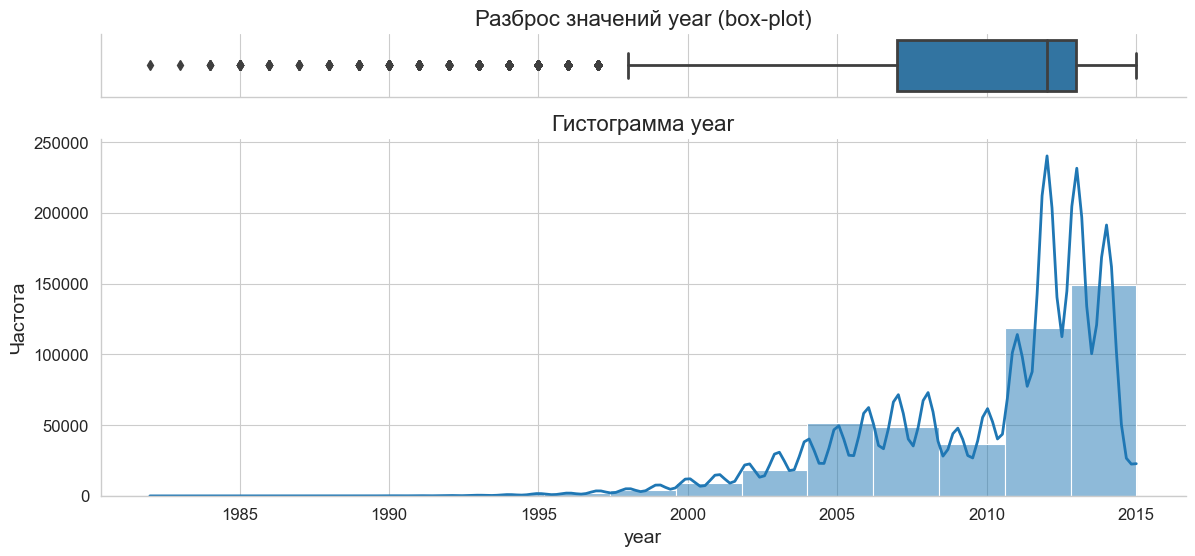

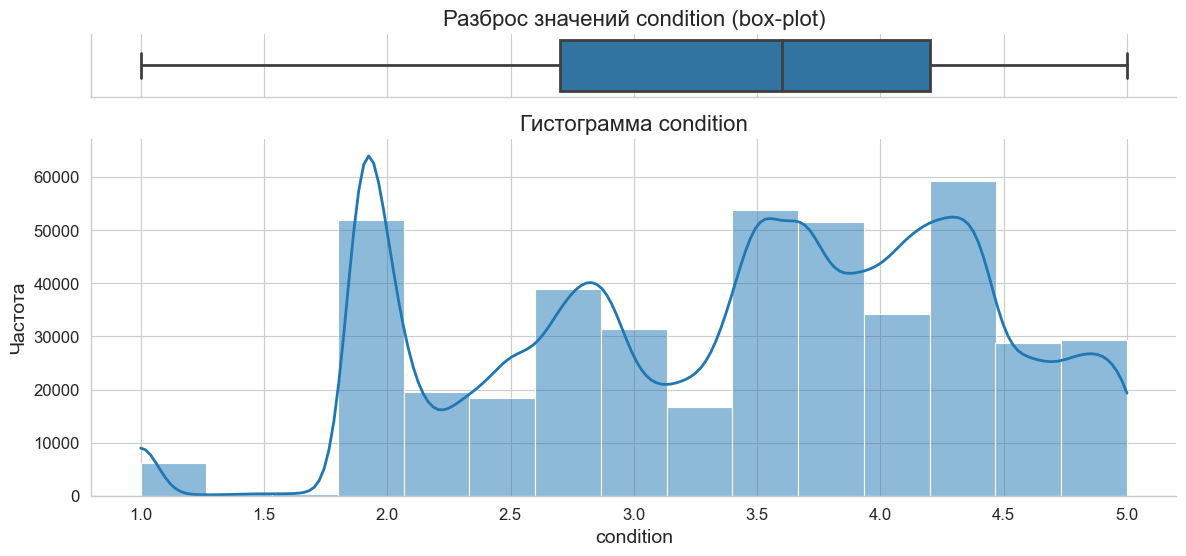

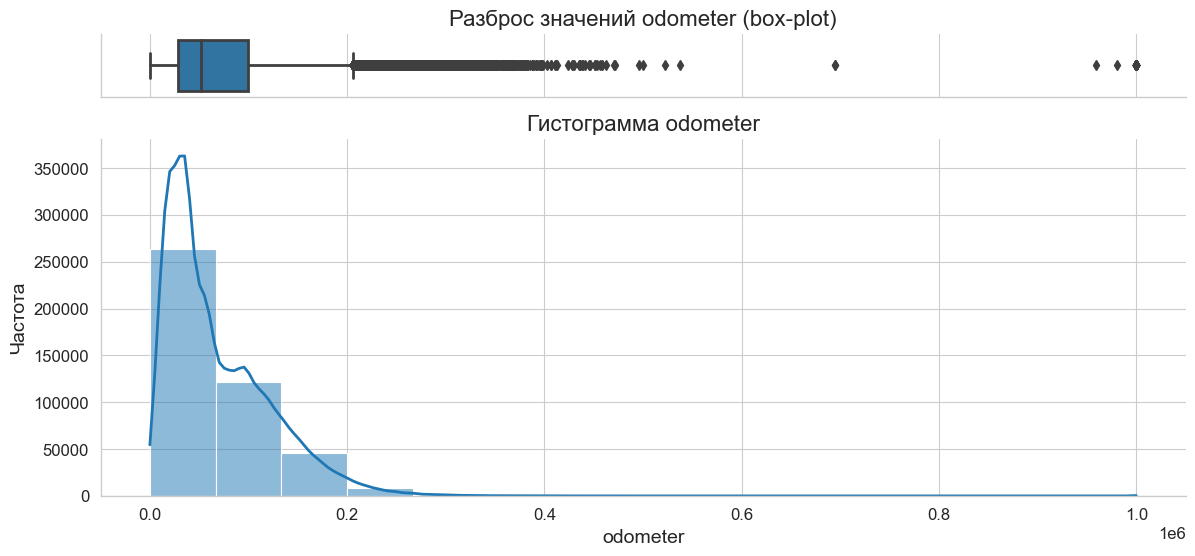

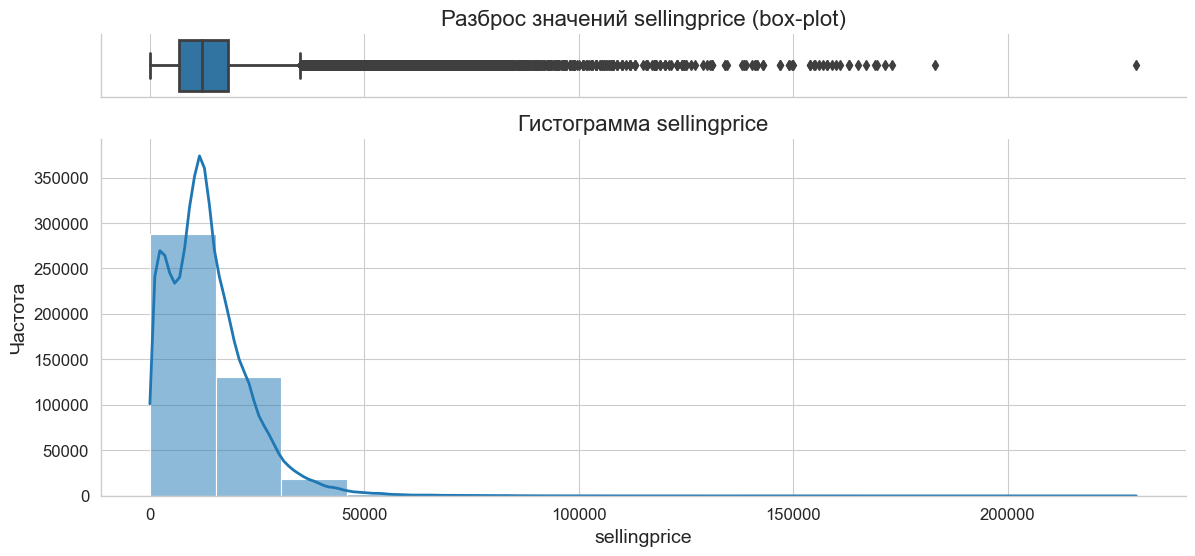

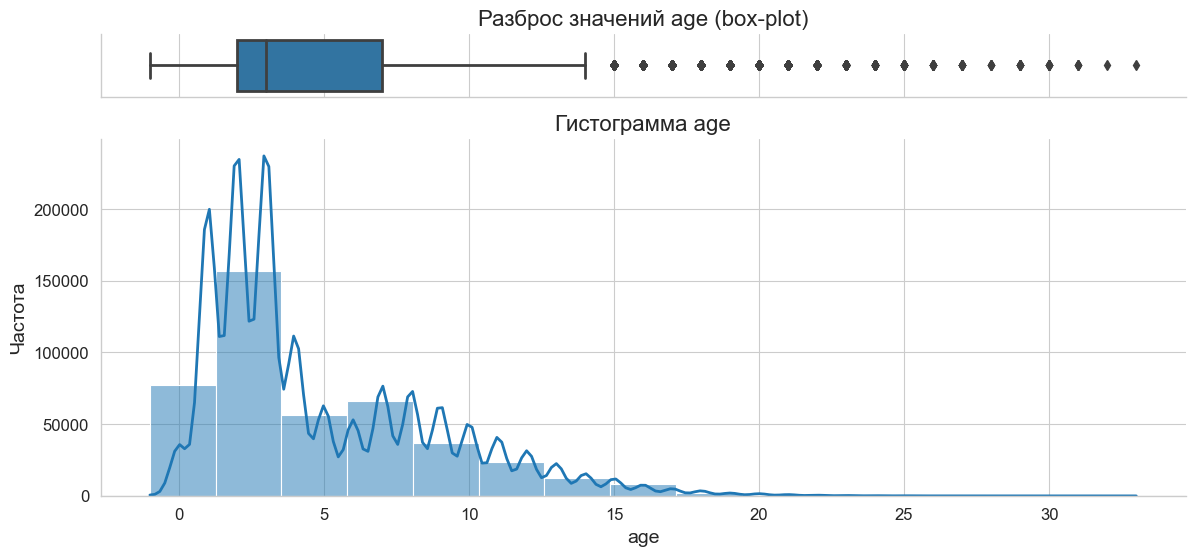

In [349]:
plot_num(train)

##### Sellingprice

Явной аномалией был Форд, как единственная машина дороже 200К единиц, а также пара машин по околонулевой стоимости, которые и были удалены, в остальном свыше 100К дорогие бренды и все выглядит логично.

In [350]:
train[train['sellingprice'] < 100]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,age,ct_trim,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,ct_make,ct_model
137962,2003,mercedes-benz,e-class,e500,sedan,automatic,wdbuf70j73a269529,ga,2.1,1.0,...,12,rare,ga,black,black,rare,europe,germany,mercedes-benz,e-class
418021,2002,ford,f-350 super duty,xlt,cab,automatic,1ftsw31f52ed16477,ca,2.0,171687.0,...,13,xlt,ca,white,gray,rare,north america,united states,ford,rare


In [351]:
train = train[train['sellingprice'] >= 100]

In [352]:
train[train['sellingprice'] > 200000]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,age,ct_trim,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,ct_make,ct_model
392004,2014,ford,escape,titanium,suv,automatic,1fmcu9j98eua23833,mo,4.3,27802.0,...,1,rare,mo,green,tan,rare,north america,united states,ford,escape


In [353]:
train = train[train['sellingprice'] <= 200000]

In [354]:
q75, q25 = np.percentile(train['sellingprice'], [75 ,25])
iqr = q75 - q25
bottom_treshold = q25 - 1.5 * iqr   #1.5
top_treshold = q75 + 3 * iqr
bottom_treshold, top_treshold

(-10050.0, 52100.0)

In [355]:
train[train['sellingprice'] > 52100].shape[0]  #65000

2295

In [356]:
train[train['sellingprice'] > 100000].make.value_counts()

mercedes-benz    29
bentley          21
ferrari          16
land rover       15
bmw              14
rolls-royce      14
audi             13
porsche           6
lamborghini       4
aston martin      1
Name: make, dtype: int64

##### Condition

Распределение неравномерное, однако явных аномалий не наблюдается.

##### Odometer

In [357]:
q75, q25 = np.percentile(train['odometer'], [75 ,25])
iqr = q75 - q25
bottom_treshold = q25 - 1.5 * iqr
top_treshold = q75 + 3 * iqr
bottom_treshold, top_treshold

(-78274.0, 312347.0)

In [358]:
train[train['odometer'] > 300000].shape[0] # 312359 312347

586

In [359]:
train[train['odometer'] > 400000].shape[0]

92

In [360]:
train[train['odometer'] == 999999].shape[0]

55

In [361]:
train['odometer'].describe()

count    440233.000000
mean      68353.117596
std       53545.981352
min           1.000000
25%       28259.000000
50%       52103.000000
75%       99281.000000
max      999999.000000
Name: odometer, dtype: float64

In [362]:
test['odometer'].describe()

count    110058.000000
mean      68087.076950
std       53526.582034
min           1.000000
25%       28317.000000
50%       51935.000000
75%       98877.500000
max      999999.000000
Name: odometer, dtype: float64

In [363]:
train = train[train['odometer'] <= 312000]

##### Year

In [364]:
q75, q25 = np.percentile(train['year'], [75 ,25])
iqr = q75 - q25
bottom_treshold = q25 - 1.5 * iqr
top_treshold = q75 + 1.5 * iqr
bottom_treshold, top_treshold

(1998.0, 2022.0)

In [365]:
train[train['year'] < 1998].shape[0]  #1995

3161

In [366]:
train = train[train['year'] >= 1998]

##### Age

In [367]:
train = train[train['age'] >= 0]

In [368]:
train[train['age'] < 0].shape[0]

0

In [369]:
test.loc[test['age'] < 0, ['age', 'sale_year']] = [0, 2015]

In [370]:
test[test['age'] < 0].shape[0]

0

### Infographics
[В начало](#0)

В этом разделе собрана инфографика по переменным не представленная ранее для лучшего представления о данных.

#### Low cardinality cat_features representation

In [371]:
cat_cols = train.drop([
    'vin', 'saledate', 'make', 'model', 'trim', 'state', 'seller',
    'color', 'interior', 'region', 'country', 'vin_model', 'vin_body',
    'vin_year', 'ct_make', 'ct_model', 'ct_trim', 'ct_state', 'ct_seller'
],
    axis=1).select_dtypes(include='object').columns.to_list()

In [372]:
cat_cols

['body', 'transmission', 'ct_color', 'ct_interior', 'ct_region', 'ct_country']

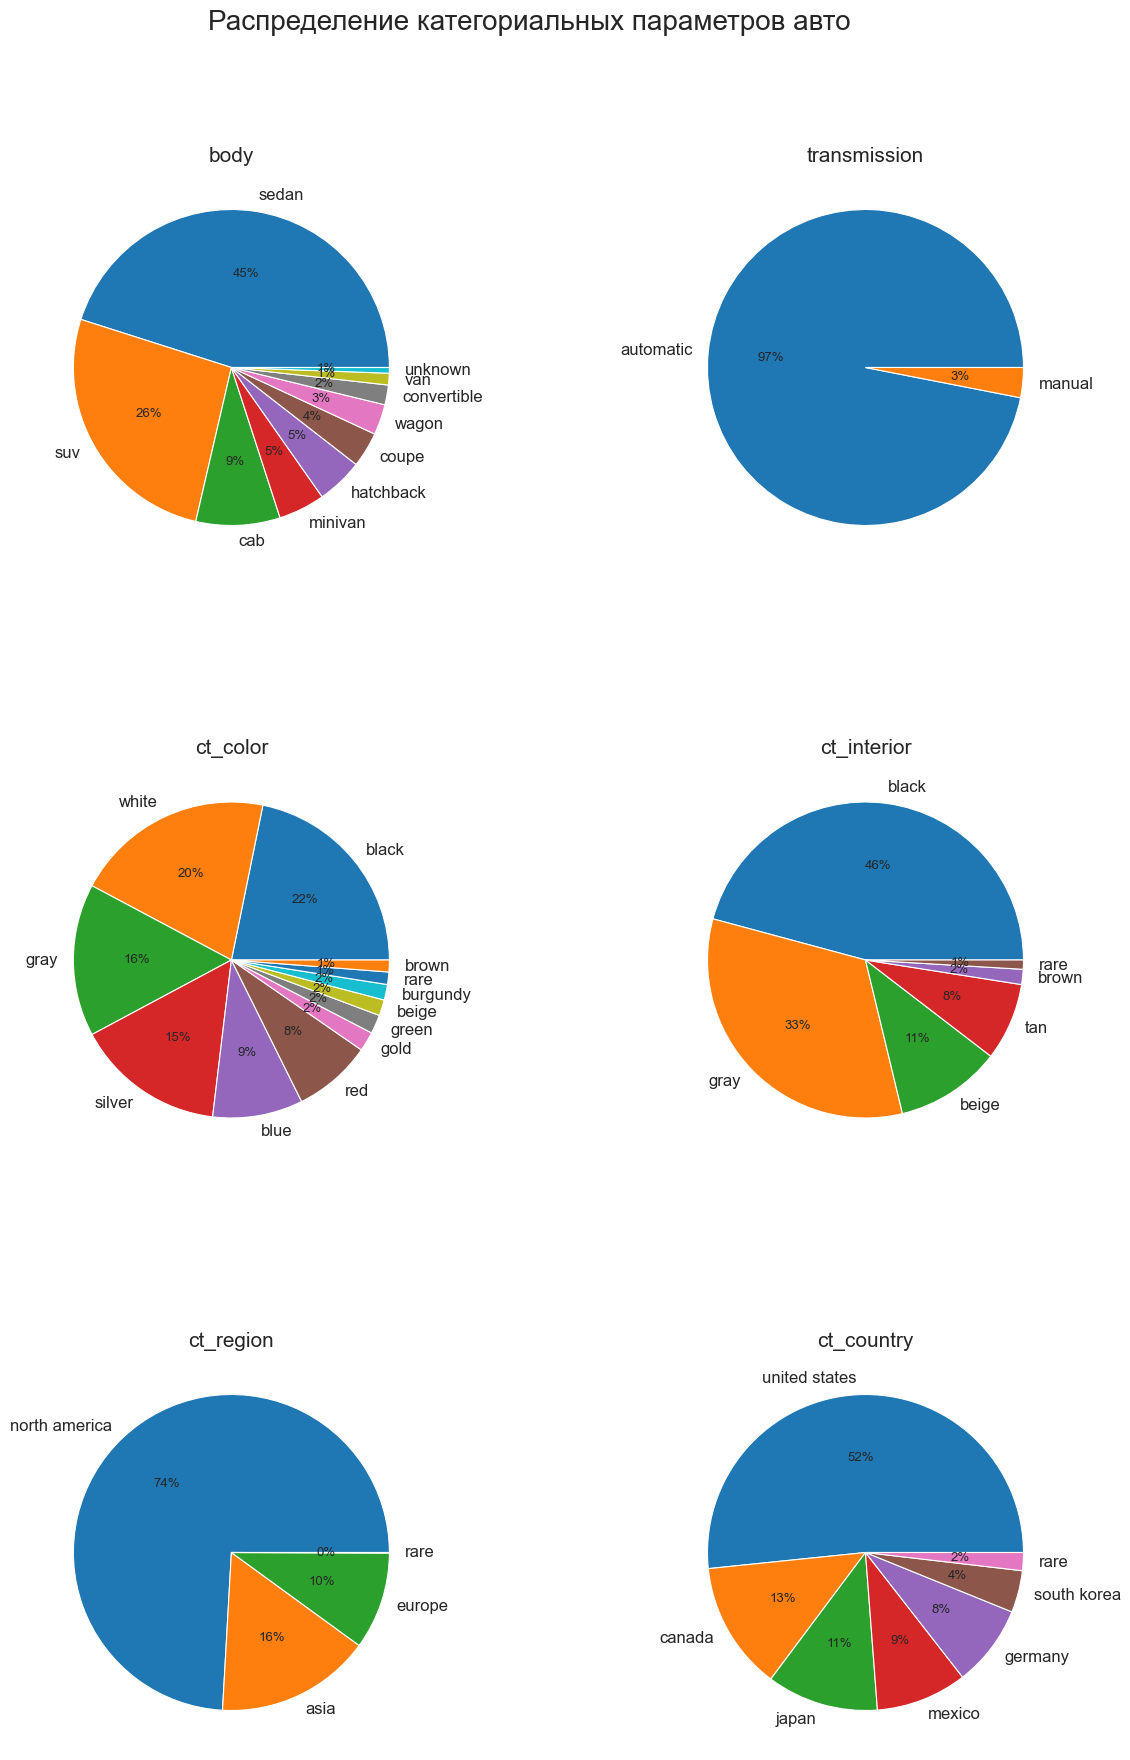

In [373]:
plt.figure(figsize=[15, 20])
plt.suptitle('Распределение категориальных параметров авто', fontsize=20)
plt.subplots_adjust(top=0.9, hspace=0.5)

num_plots = len(cat_cols)
num_rows = np.ceil(num_plots / 2).astype('int')

for i, col in enumerate(cat_cols, 1):
    plt.subplot(num_rows, 2, i)
    plt.title(f'{col}', fontsize=15)
    train[col].value_counts().plot(kind='pie', ylabel='', autopct="%1.0f%%")

for j in range(num_plots + 1, num_rows * 2 + 1):
    plt.subplot(num_rows, 2, j)
    plt.axis('off')

plt.show();

#### High cardinality cat_features representation

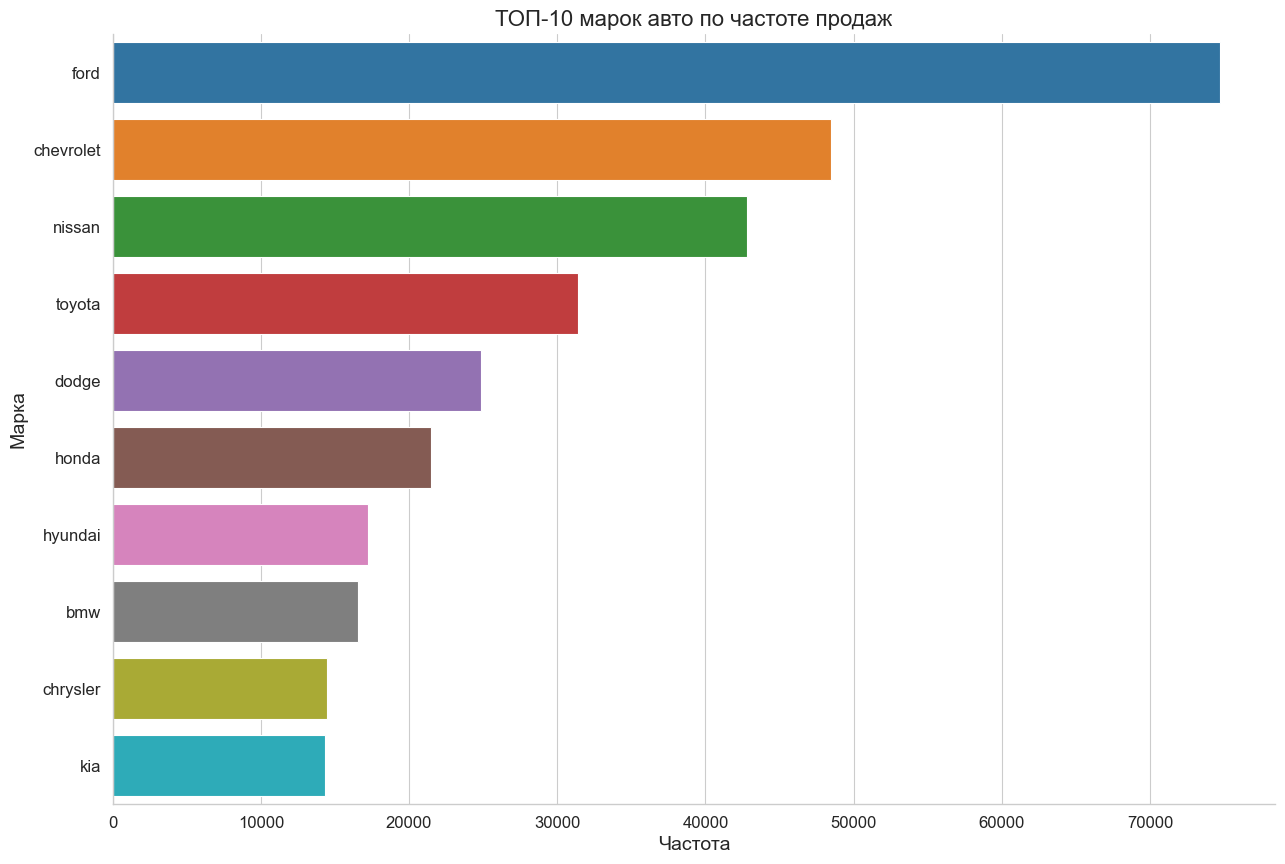

In [374]:
top_10_make = train['make'].value_counts().reset_index().head(10)

plt.figure(figsize=(15, 10))
ax = sns.barplot(x='make',
            y='index',
            data=top_10_make)

ax.set_title('ТОП-10 марок авто по частоте продаж')
ax.set(xlabel='Частота', ylabel='Марка');

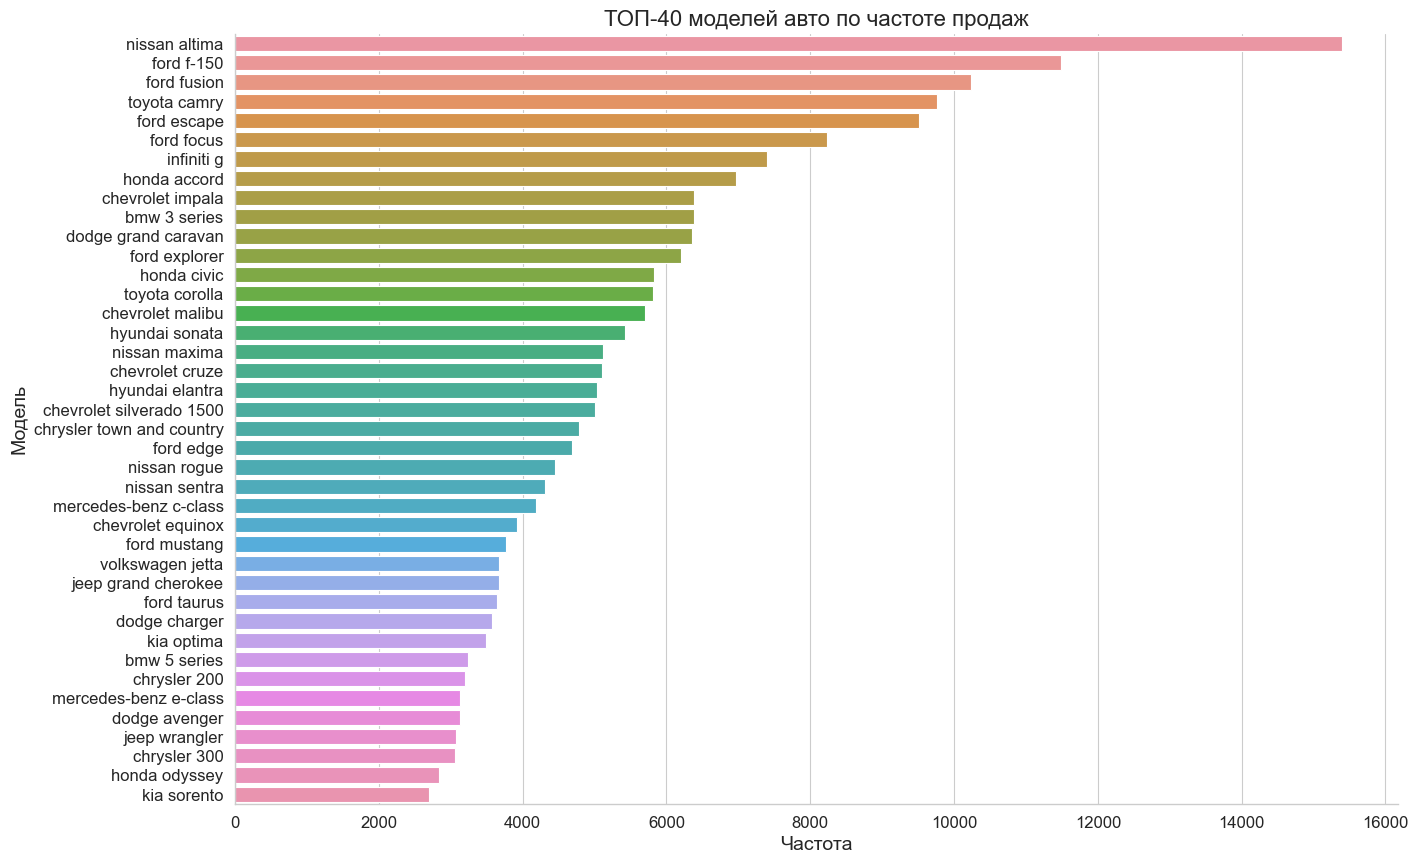

In [375]:
top_40_cars = train[['make', 'model']].value_counts().reset_index().head(40)
top_40_cars['model'] = top_40_cars['make'] + ' ' + top_40_cars['model']

plt.figure(figsize=(15, 10))
ax = sns.barplot(x=0,
            y='model',
            data=top_40_cars)

ax.set_title('ТОП-40 моделей авто по частоте продаж')
ax.set(xlabel='Частота', ylabel='Модель');

### CONNECTIONS RESEARCH
[В начало](#0)

#### phik

In [379]:
train_phik = train.drop([
    'vin', 'saledate', 'sale_year', 'make', 'model', 'trim', 'state', 'seller',
    'color', 'interior', 'region', 'country', 'vin_model', 'vin_body', 'vin_year'
],
    axis=1).copy()
num = train_phik.select_dtypes(exclude='object').columns.to_list()
# num.remove('churn')

In [380]:
phik_overview = train_phik.phik_matrix(interval_cols=num)
phik_overview

,year,body,transmission,condition,odometer,sellingprice,age,ct_trim,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,ct_make,ct_model
year,1.000000,0.250481,0.108728,0.563389,0.760860,0.388932,0.998018,0.364743,0.239004,0.193575,0.232527,0.441587,0.110156,0.137816,0.363631,0.524258
body,0.250481,1.000000,0.283022,0.143062,0.208467,0.315859,0.245716,0.620176,0.195792,0.223473,0.213608,0.252897,0.316761,0.392756,0.671428,0.941503
transmission,0.108728,0.283022,1.000000,0.045531,0.052299,0.034267,0.109575,0.138863,0.054150,0.083425,0.086288,0.097339,0.115185,0.074208,0.234212,0.311893
condition,0.563389,0.143062,0.045531,1.000000,0.563408,0.401481,0.564593,0.177216,0.222035,0.113992,0.143114,0.232157,0.052848,0.067850,0.235248,0.300205
odometer,0.760860,0.208467,0.052299,0.563408,1.000000,0.425220,0.760779,0.244771,0.242487,0.146987,0.214682,0.396668,0.068439,0.090165,0.270538,0.395649
sellingprice,0.388932,0.315859,0.034267,0.401481,0.425220,1.000000,0.387712,0.317277,0.155241,0.132775,0.144058,0.247236,0.232452,0.221166,0.462778,0.486663
age,0.998018,0.245716,0.109575,0.564593,0.760779,0.387712,1.000000,0.357984,0.240651,0.197020,0.234985,0.438785,0.106730,0.135837,0.358119,0.516389
ct_trim,0.364743,0.620176,0.138863,0.177216,0.244771,0.317277,0.357984,1.000000,0.197202,0.165281,0.299246,0.555734,0.509130,0.572048,0.897020,0.953859
ct_state,0.239004,0.195792,0.054150,0.222035,0.242487,0.155241,0.240651,0.197202,1.000000,0.143270,0.188455,0.394625,0.216872,0.214101,0.344611,0.403779
ct_color,0.193575,0.223473,0.083425,0.113992,0.146987,0.132775,0.197020,0.165281,0.143270,1.000000,0.377058,0.178797,0.153977,0.134503,0.295211,0.393479


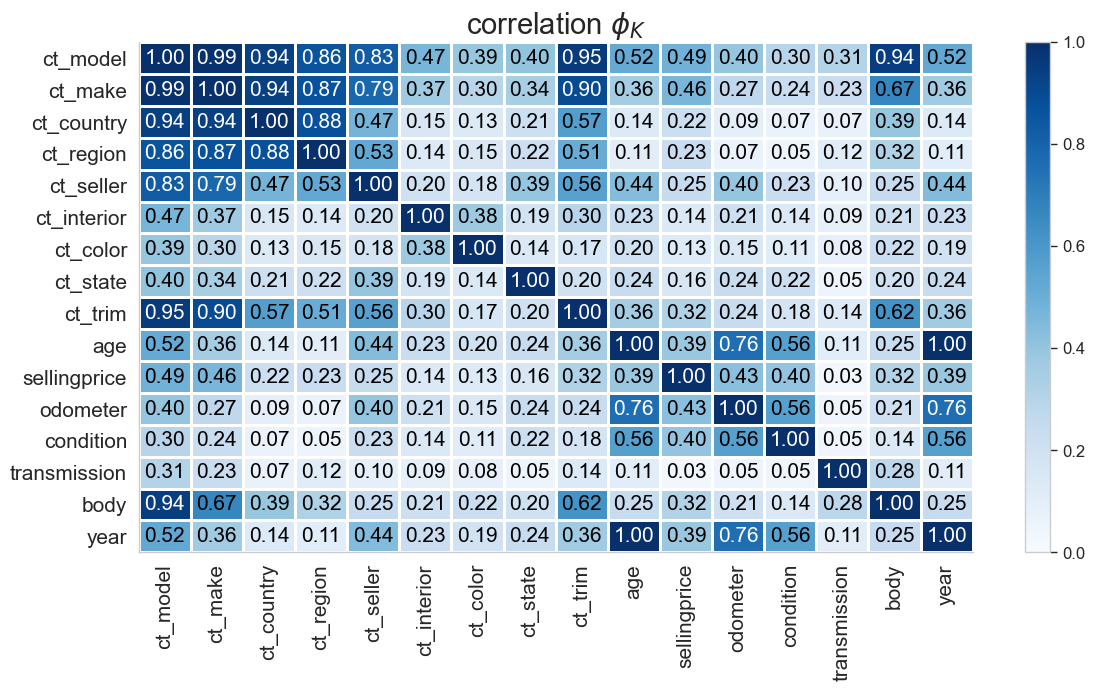

In [381]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(12,7))

In [382]:
target_corr = phik_overview.sellingprice.round(2).sort_values(ascending=False).reset_index()
target_corr = target_corr.rename(columns={'index': 'feature', 'sellingprice': 'corr'})

In [383]:
target_corr

,feature,corr
0,sellingprice,1.00
1,ct_model,0.49
2,ct_make,0.46
3,odometer,0.43
4,condition,0.40
5,year,0.39
6,age,0.39
7,body,0.32
8,ct_trim,0.32
9,ct_seller,0.25


#### significance_overview

In [384]:
significance_overview = train_phik.significance_matrix(interval_cols=num)
significance_overview

,year,body,transmission,condition,odometer,sellingprice,age,ct_trim,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,ct_make,ct_model
year,1274.379591,150.837421,52.228053,401.719910,655.444175,279.687477,1207.418456,247.465333,174.289470,149.301657,185.626703,389.330715,73.873071,114.572571,260.822954,403.281325
body,150.837421,1181.602597,115.855462,86.721619,126.463198,196.582551,148.378881,434.757479,135.932595,174.854712,165.384836,209.372710,232.513891,333.160436,524.720185,937.096107
transmission,52.228053,115.855462,345.952055,22.026815,25.839118,16.927998,52.563950,75.234121,30.065250,39.978171,40.779236,61.773260,45.915428,49.609301,104.601950,140.551357
condition,401.719910,86.721619,22.026815,1349.087607,403.744633,269.731287,403.001054,108.796682,162.237395,91.071923,110.682044,188.915037,35.332739,53.748574,158.688443,194.991205
odometer,655.444175,126.463198,25.839118,403.744633,1224.965426,304.224190,654.941405,159.619979,180.001173,117.265123,170.762425,349.869252,46.176380,73.705934,188.404915,280.628715
sellingprice,279.687477,196.582551,16.927998,269.731287,304.224190,755.724652,279.703994,231.691712,117.559459,110.178558,108.179791,185.099443,132.858016,159.777238,292.721878,359.635441
age,1207.418456,148.378881,52.563950,403.001054,654.941405,279.703994,1278.943880,241.976975,175.603452,151.238939,188.251176,386.048204,71.680909,113.049382,256.860989,396.018303
ct_trim,247.465333,434.757479,75.234121,108.796682,159.619979,231.691712,241.976975,1384.428284,152.760855,119.648640,217.931626,389.720216,323.446250,448.699160,931.294082,1004.726882
ct_state,174.289470,135.932595,30.065250,162.237395,180.001173,117.559459,175.603452,152.760855,1571.871188,101.331442,127.218238,328.388037,135.594385,151.658727,267.455247,273.314755
ct_color,149.301657,174.854712,39.978171,91.071923,117.265123,110.178558,151.238939,119.648640,101.331442,1337.996489,221.864818,142.238437,81.381664,103.683788,206.027023,257.332183


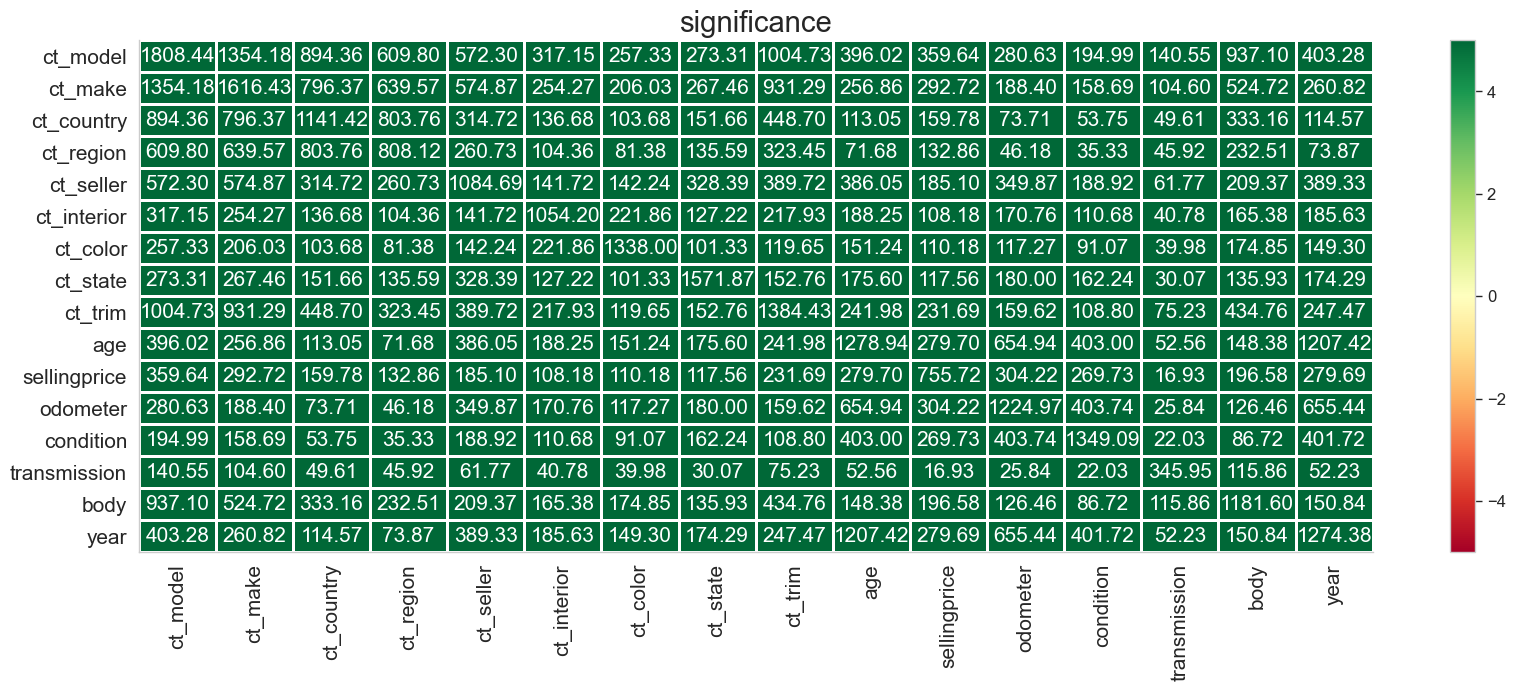

In [385]:
plot_correlation_matrix(significance_overview.values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(17,7))
plt.tight_layout()

In [386]:
target_significance = significance_overview.sellingprice.round(2).sort_values(ascending=False).reset_index()
target_significance = target_significance.rename(columns={'index': 'feature', 'sellingprice': 'significance'})

In [387]:
target_report = target_corr.merge(target_significance,
                                  on=['feature'],
                                  how='left').drop(labels=0,
                                                   axis=0)

In [388]:
target_report

,feature,corr,significance
1,ct_model,0.49,359.64
2,ct_make,0.46,292.72
3,odometer,0.43,304.22
4,condition,0.40,269.73
5,year,0.39,279.69
6,age,0.39,279.70
7,body,0.32,196.58
8,ct_trim,0.32,231.69
9,ct_seller,0.25,185.10
10,ct_region,0.23,132.86


### OUTPUT

In [377]:
#train.to_csv('baseline_train.csv', index=False)

In [378]:
#test.to_csv('baseline_test.csv', index=False)

## Baseline
[В начало](#0)

**Комментарий:** В качестве первых бейзлайн моделей используем линейную Lasso (хоть уровень линейных связей признаков и таргета не особо велик, но будет полезно посмотреть, каких результатов сможет добиться более простая линейная модель, хотя бы в качестве бейзлайна + L1 регуляризация обычно обнуляет веса наименее информативных фичей) и Случайный лес (деревянная модель должна лучше проявить себя при наличии нелинейных связей + также помочь с отбором более информативных признаков).

### INPUT

In [11]:
train_b = pd.read_csv('baseline_train.csv')
test_b = pd.read_csv('baseline_test.csv')

### Feature preparation

In [390]:
features = train_b.drop([
    'vin', 'saledate', 'sale_year', 'make', 'model', 'trim', 'state', 'seller',
    'color', 'interior', 'region', 'country', 'vin_model', 'vin_body', 'vin_year',
    'year', 'sellingprice'
],
    axis=1).copy()

In [238]:
target = train_b['sellingprice']

In [392]:
num_features = features.select_dtypes(exclude='object').columns.to_list()

In [393]:
cat_features = features.select_dtypes(include='object').columns.to_list()

In [394]:
features.shape

(436469, 14)

In [395]:
num_features

['condition', 'odometer', 'age']

In [396]:
cat_features

['body',
 'transmission',
 'ct_trim',
 'ct_state',
 'ct_color',
 'ct_interior',
 'ct_seller',
 'ct_region',
 'ct_country',
 'ct_make',
 'ct_model']

### Lasso

#### cv pipeline

In [401]:
preprocessor_ls = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), num_features),
    ('encode', OneHotEncoder(handle_unknown='ignore'), cat_features),
])

lasso = Pipeline(steps=[('preprocessor',
                         preprocessor_ls), ('regressor',
                                            Lasso(random_state=RS))])

lasso_score = -cross_val_score(
    lasso,
    features,
    target,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [402]:
lasso_score

0.6102342464976479

In [305]:
score_list = list()
score_list.append(('Lasso_baseline', 'MAPE', 0.6102342464976479))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234


In [403]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=TS, random_state=RS) # отделяем 25% данных для валидационной выборки

In [404]:
lasso.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['condition', 'odometer',
                                                   'age']),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body', 'transmission',
                                                   'ct_trim', 'ct_state',
                                                   'ct_color', 'ct_interior',
                                                   'ct_seller', 'ct_region',
                                                   'ct_country', 'ct_make',
                                                   'ct_model'])])),
                ('regressor', Lasso(random_state=42))])

#### feature inportances

In [405]:
importances_ls_model = lasso.steps[-1][1].coef_
imp_ls_model = list(zip(features_train.columns, importances_ls_model))

In [406]:
imp_ls_model.sort(key = lambda x:abs(x[1]), reverse=True)
imp_ls_model

[('odometer', 6326.950004528248),
 ('condition', -3938.559270384798),
 ('ct_state', -3669.492278474033),
 ('transmission', -2454.257244466106),
 ('ct_make', -1980.2558941204459),
 ('ct_trim', 1776.2553751673177),
 ('age', 1680.7600137832783),
 ('body', 1508.441599860485),
 ('ct_interior', -1479.7642087016984),
 ('ct_seller', 1320.8800919458458),
 ('ct_region', -491.3569547544576),
 ('ct_model', -487.6270795971284),
 ('ct_color', -277.022280514894),
 ('ct_country', 0.0)]

**Комментарий:** Есть странности в распределении коэффициентов модели, например логичны высокие значения у пробега и состояния, однако также высокий коэффициент у трансмиссии, которая практически имеет одно значение в датасете, низкие значения у марки, возраста и особенно модели авто, тем не менее второстепенные признаки в основном собрались в нижней половине списка. Такие странности могут быть связаны с тем, что вид связей признаков с таргетом скорее нелинейный. Посмотрим важность признаков через permutation_importance.

#### permutation importance

In [407]:
result_ls = permutation_importance(lasso, features_valid, target_valid, random_state=RS)
importances_ls = result_ls.importances_mean

In [408]:
imp_ls = list(zip(features_valid.columns, importances_ls))
imp_ls.sort(key = lambda x:abs(x[1]), reverse=True)
imp_ls

[('age', 0.3293230506382572),
 ('ct_make', 0.2544016739486673),
 ('ct_region', 0.18376631840029212),
 ('ct_model', 0.1526134439336009),
 ('ct_country', 0.14142603092159292),
 ('odometer', 0.1286328536053736),
 ('body', 0.12575666206792904),
 ('condition', 0.04855214927124245),
 ('ct_trim', 0.021569192002535775),
 ('ct_seller', 0.010856113045875282),
 ('ct_interior', 0.0048017523306239426),
 ('ct_color', 0.0014472688543418321),
 ('ct_state', 0.0013582204766599214),
 ('transmission', 0.0002427017810236798)]

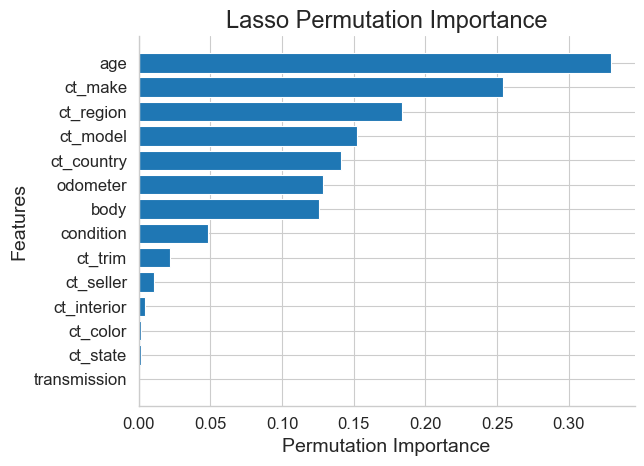

In [409]:
sorted_idx_ls = importances_ls.argsort()
plt.title('Lasso Permutation Importance', fontsize=17)
plt.barh(features_valid.columns[sorted_idx_ls], importances_ls[sorted_idx_ls])
plt.xlabel('Permutation Importance')
plt.ylabel('Features');

**Комментарий:** Оценка важности через перестановки признаков дала более логичные результаты, наименее контрастные признаки оказались внизу списка с еле заметным вкладом. Попробуем также произвести отбор признаков с помощью случайного леса.

### Random forest

#### cv pipeline, num_features unscaled

In [410]:
preprocessor_rfns = ColumnTransformer(transformers=[
    ('encode',
     OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
     cat_features),
])

ranfor_ns = Pipeline(steps=[(
    'preprocessor',
    preprocessor_rfns), ('regressor', RandomForestRegressor(random_state=RS))])

ranfor_ns_score = -cross_val_score(
    ranfor_ns,
    features,
    target,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [411]:
ranfor_ns_score

0.6779098267647354

In [306]:
score_list.append(('RandomForest_baseline_num_not_scaled', 'MAPE', 0.6779098267647354))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910


**Комментарий:** Для начала не стал масштабировать числовые признаки, так как деревянные модели должны сами с этим справляться, однако различный масштаб числовых в нашей задаче и оставшиеся выбросы могут усложнить жизнь модели, возможно с этим связана метрика хуже, чем у линейной модели. Попробуем разобраться в причинах.

In [412]:
ranfor_ns.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['body', 'transmission',
                                                   'ct_trim', 'ct_state',
                                                   'ct_color', 'ct_interior',
                                                   'ct_seller', 'ct_region',
                                                   'ct_country', 'ct_make',
                                                   'ct_model'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

##### feature importances

In [413]:
importances_rfns_model = ranfor_ns.steps[-1][1].feature_importances_
imp_rfns_model = list(zip(features_train.columns, importances_rfns_model))

In [414]:
imp_rfns_model.sort(key = lambda x:abs(x[1]), reverse=True)
imp_rfns_model

[('ct_seller', 0.18507906089686843),
 ('odometer', 0.14341078168760454),
 ('body', 0.11859378225152406),
 ('ct_region', 0.11109242583732848),
 ('age', 0.09316012531729118),
 ('ct_trim', 0.08880054358207223),
 ('ct_state', 0.0875702438300214),
 ('condition', 0.080343626293117),
 ('ct_interior', 0.050433807967476534),
 ('ct_color', 0.032325211984444095),
 ('transmission', 0.009190390352252125)]

**Комментарий:** В список вообще не попали марка, модель и страна, возможно это связано с высокой взаимной корреляцией. Продавец нелогично на первом месте, скорее всего из-за высокой кардинальности признака. По последним 3 местам вроде все логично, по остальным позициям есть вопросы. Посмотрим на permutation_importance.

##### permutation importance

In [415]:
result_rfns = permutation_importance(ranfor_ns, features_valid, target_valid, random_state=RS)
importances_rfns = result_rfns.importances_mean

In [416]:
imp_rfns = list(zip(features_valid.columns, importances_rfns))
imp_rfns.sort(key = lambda x:abs(x[1]), reverse=True)
imp_rfns

[('ct_make', 0.644327916512166),
 ('body', 0.5966500415673777),
 ('ct_model', 0.41430217362141536),
 ('ct_trim', 0.3065221470365624),
 ('ct_country', 0.22996520285806019),
 ('ct_seller', 0.17745522349826529),
 ('ct_region', 0.1495367580513063),
 ('ct_interior', 0.14053902919722516),
 ('ct_state', 0.10559591264451407),
 ('ct_color', 0.05506577975730633),
 ('transmission', 0.006407018116255103),
 ('condition', 0.0),
 ('odometer', 0.0),
 ('age', 0.0)]

**Комментарий:** Судя по нулевым коэффициентам у числовых переменных все таки модель с ними не справилась и нужно ей помочь, масштабировав до обучения. Посмотрим, как изменятся результаты после этого.

#### cv pipeline, num_features scaled

In [417]:
preprocessor_rf = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), num_features),
    ('encode',
     OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
     cat_features),
])

ranfor = Pipeline(steps=[(
    'preprocessor',
    preprocessor_rf), ('regressor', RandomForestRegressor(random_state=RS))])

ranfor_score = -cross_val_score(
    ranfor,
    features,
    target,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [418]:
ranfor_score

0.1919763143202207

In [307]:
score_list.append(('RandomForest_baseline_num_scaled', 'MAPE', 0.1919763143202207))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976


**Комментарий:** Уже по метрике видно, что результаты разительно отличаются. Однако тут еще может быть переобучение, которым грешат деревянные модели.

##### feature importances

In [423]:
importances_rf_model = ranfor.steps[-1][1].feature_importances_
imp_rf_model = list(zip(features_train.columns, importances_rf_model))

In [424]:
imp_rf_model.sort(key = lambda x:abs(x[1]), reverse=True)
imp_rf_model

[('transmission', 0.36702816488127593),
 ('ct_make', 0.13623287234459028),
 ('odometer', 0.11308862948592174),
 ('condition', 0.10543439020879167),
 ('ct_model', 0.0759891886226939),
 ('body', 0.06713281269137403),
 ('ct_country', 0.038779483934954506),
 ('ct_trim', 0.03506815430803166),
 ('ct_region', 0.021295520638611197),
 ('ct_state', 0.013053955797314937),
 ('ct_interior', 0.010483338292405333),
 ('ct_color', 0.008933720670626095),
 ('ct_seller', 0.005897784320502703),
 ('age', 0.0015819838029060402)]

**Комментарий:** В список вернулись все признаки, однако возраст на последнем месте и трансмиссия на первом вызыают серьезные вопросы... посмотрим, что там с permutation_importance.

##### permutation importance

In [425]:
result_rf = permutation_importance(ranfor, features_valid, target_valid, random_state=RS)
importances_rf = result_rf.importances_mean

In [426]:
imp_rf = list(zip(features_valid.columns, importances_rf))
imp_rf.sort(key = lambda x:abs(x[1]), reverse=True)
imp_rf

[('body', 0.5467170799794812),
 ('ct_make', 0.40554990178571454),
 ('ct_model', 0.32123106573879456),
 ('odometer', 0.3178870603300852),
 ('age', 0.3063932212600978),
 ('ct_country', 0.2375357386708595),
 ('ct_trim', 0.10173665220821038),
 ('ct_region', 0.07375690230126397),
 ('condition', 0.05074629504819701),
 ('ct_interior', 0.011440777352665155),
 ('ct_seller', 0.005507074078260876),
 ('ct_state', 0.00418186898147539),
 ('ct_color', 0.0029500926838607277),
 ('transmission', 0.0013451957010289783)]

**Комментарий:** Здесь уже все логичнее, однако тип кузова на первом месте вызывает небольшие сомнения.

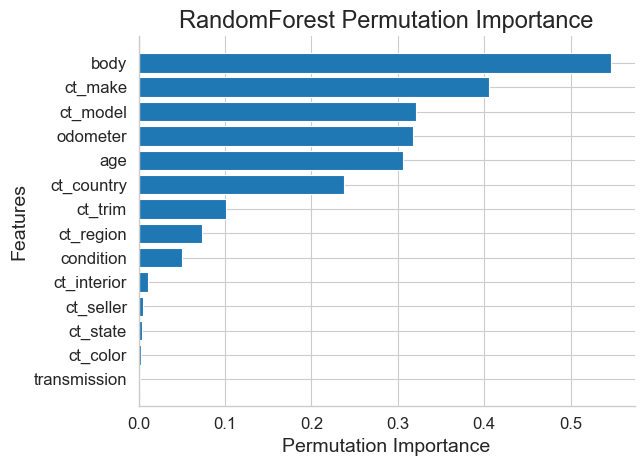

In [427]:
sorted_idx_rf = importances_rf.argsort()
plt.title('RandomForest Permutation Importance', fontsize=17)
plt.barh(features_valid.columns[sorted_idx_rf], importances_rf[sorted_idx_rf])
plt.xlabel('Permutation Importance')
plt.ylabel('Features');

### Catboost

#### raw features

**Комментарий:** Для чистоты эксперимента проверим сначала метрику на изначальном наборе фичей. Случайный лес так не запустить, иначе он задумается очень надолго, а катбуст под капотом скорее всего и сам оптимизирует высококардинальные фичи.

In [232]:
features_cb = train_b.drop([
    'vin', 'saledate', 'sale_year', 'ct_make', 'ct_model', 'ct_trim', 'ct_state', 'ct_seller',
    'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year',
    'age', 'sellingprice', 'region', 'country'
],
    axis=1).copy()

In [233]:
features_cb

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars avis budget group
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan infiniti lt
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart
...,...,...,...,...,...,...,...,...,...,...,...,...
436464,2013,kia,optima,ex hybrid,sedan,automatic,ca,4.5,20434.0,white,beige,kia motors america inc
436465,2014,mini,cooper countryman,s all4,wagon,automatic,wi,2.9,14675.0,white,black,bmw mini financial services
436466,2008,bmw,6 series,650i,coupe,automatic,ca,3.7,102552.0,gray,black,studio city auto group
436467,2014,ram,2500,slt,cab,automatic,tx,3.0,29367.0,white,gray,express car truck rental


In [234]:
cat_features_cb = features_cb.select_dtypes(include='object').columns.to_list()

In [235]:
cb = CatBoostRegressor(random_seed=RS, cat_features=cat_features_cb)

In [239]:
cb_score = -cross_val_score(cb, features_cb, target, cv=3, scoring='neg_mean_absolute_percentage_error').mean()

Learning rate set to 0.100339
0:	learn: 9121.5280262	total: 420ms	remaining: 6m 59s
1:	learn: 8567.6408183	total: 1.23s	remaining: 10m 12s
2:	learn: 8042.5248220	total: 1.72s	remaining: 9m 33s
3:	learn: 7618.4263670	total: 2.17s	remaining: 8m 59s
4:	learn: 7256.7482896	total: 2.58s	remaining: 8m 33s
5:	learn: 6921.5211829	total: 2.98s	remaining: 8m 13s
6:	learn: 6588.6199135	total: 3.41s	remaining: 8m 4s
7:	learn: 6327.2004423	total: 3.81s	remaining: 7m 52s
8:	learn: 6091.9135520	total: 4.25s	remaining: 7m 47s
9:	learn: 5842.5174714	total: 4.67s	remaining: 7m 42s
10:	learn: 5657.3766090	total: 5.28s	remaining: 7m 55s
11:	learn: 5489.1808607	total: 5.75s	remaining: 7m 53s
12:	learn: 5347.4555537	total: 6.22s	remaining: 7m 52s
13:	learn: 5192.0907877	total: 6.66s	remaining: 7m 49s
14:	learn: 5056.6039048	total: 7.06s	remaining: 7m 43s
15:	learn: 4951.7705064	total: 7.45s	remaining: 7m 38s
16:	learn: 4866.3636650	total: 7.87s	remaining: 7m 35s
17:	learn: 4776.0733441	total: 8.21s	remainin

149:	learn: 3163.8098286	total: 52.1s	remaining: 4m 55s
150:	learn: 3160.0863648	total: 52.4s	remaining: 4m 54s
151:	learn: 3154.6216907	total: 52.7s	remaining: 4m 54s
152:	learn: 3153.7412812	total: 52.9s	remaining: 4m 53s
153:	learn: 3149.8740572	total: 53.2s	remaining: 4m 52s
154:	learn: 3147.6737334	total: 53.5s	remaining: 4m 51s
155:	learn: 3142.3534723	total: 53.9s	remaining: 4m 51s
156:	learn: 3137.8432359	total: 54.2s	remaining: 4m 50s
157:	learn: 3133.8403791	total: 54.5s	remaining: 4m 50s
158:	learn: 3130.0516571	total: 54.8s	remaining: 4m 49s
159:	learn: 3128.1572180	total: 55s	remaining: 4m 48s
160:	learn: 3123.6417204	total: 55.3s	remaining: 4m 48s
161:	learn: 3119.5301151	total: 55.7s	remaining: 4m 48s
162:	learn: 3118.2434058	total: 56.1s	remaining: 4m 47s
163:	learn: 3116.7125756	total: 56.4s	remaining: 4m 47s
164:	learn: 3108.3940015	total: 56.8s	remaining: 4m 47s
165:	learn: 3105.9950191	total: 57.4s	remaining: 4m 48s
166:	learn: 3100.5489563	total: 57.8s	remaining: 4

294:	learn: 2845.1601754	total: 1m 45s	remaining: 4m 12s
295:	learn: 2843.7912866	total: 1m 46s	remaining: 4m 13s
296:	learn: 2840.9595379	total: 1m 47s	remaining: 4m 13s
297:	learn: 2838.1292178	total: 1m 47s	remaining: 4m 13s
298:	learn: 2835.5713639	total: 1m 47s	remaining: 4m 12s
299:	learn: 2833.8276272	total: 1m 48s	remaining: 4m 12s
300:	learn: 2829.3812158	total: 1m 48s	remaining: 4m 12s
301:	learn: 2827.7586220	total: 1m 49s	remaining: 4m 11s
302:	learn: 2826.9048292	total: 1m 49s	remaining: 4m 11s
303:	learn: 2826.1597111	total: 1m 49s	remaining: 4m 11s
304:	learn: 2824.3067062	total: 1m 50s	remaining: 4m 10s
305:	learn: 2823.6591968	total: 1m 50s	remaining: 4m 10s
306:	learn: 2821.6467757	total: 1m 50s	remaining: 4m 9s
307:	learn: 2820.2993924	total: 1m 51s	remaining: 4m 9s
308:	learn: 2818.7324375	total: 1m 51s	remaining: 4m 9s
309:	learn: 2818.3510780	total: 1m 51s	remaining: 4m 8s
310:	learn: 2817.7397528	total: 1m 52s	remaining: 4m 8s
311:	learn: 2812.8059490	total: 1m 5

439:	learn: 2673.3550795	total: 2m 45s	remaining: 3m 30s
440:	learn: 2672.3541892	total: 2m 45s	remaining: 3m 29s
441:	learn: 2671.7610753	total: 2m 46s	remaining: 3m 29s
442:	learn: 2671.2116346	total: 2m 46s	remaining: 3m 29s
443:	learn: 2670.5494377	total: 2m 47s	remaining: 3m 29s
444:	learn: 2670.1805975	total: 2m 47s	remaining: 3m 29s
445:	learn: 2667.3926860	total: 2m 48s	remaining: 3m 28s
446:	learn: 2666.3756141	total: 2m 48s	remaining: 3m 28s
447:	learn: 2665.7917858	total: 2m 49s	remaining: 3m 28s
448:	learn: 2665.4109964	total: 2m 49s	remaining: 3m 28s
449:	learn: 2664.9025485	total: 2m 50s	remaining: 3m 27s
450:	learn: 2664.5433500	total: 2m 50s	remaining: 3m 27s
451:	learn: 2662.1769166	total: 2m 51s	remaining: 3m 27s
452:	learn: 2661.0971393	total: 2m 51s	remaining: 3m 27s
453:	learn: 2660.6300473	total: 2m 51s	remaining: 3m 26s
454:	learn: 2660.1091027	total: 2m 52s	remaining: 3m 26s
455:	learn: 2659.4840378	total: 2m 52s	remaining: 3m 26s
456:	learn: 2659.2263957	total:

584:	learn: 2565.1084988	total: 3m 52s	remaining: 2m 44s
585:	learn: 2564.6280995	total: 3m 52s	remaining: 2m 44s
586:	learn: 2563.9249906	total: 3m 53s	remaining: 2m 44s
587:	learn: 2563.5359089	total: 3m 53s	remaining: 2m 43s
588:	learn: 2563.3493890	total: 3m 54s	remaining: 2m 43s
589:	learn: 2562.8728404	total: 3m 54s	remaining: 2m 43s
590:	learn: 2561.9815347	total: 3m 55s	remaining: 2m 42s
591:	learn: 2561.0952277	total: 3m 56s	remaining: 2m 42s
592:	learn: 2560.5610409	total: 3m 56s	remaining: 2m 42s
593:	learn: 2560.2128159	total: 3m 57s	remaining: 2m 42s
594:	learn: 2560.0013109	total: 3m 57s	remaining: 2m 41s
595:	learn: 2559.4230747	total: 3m 58s	remaining: 2m 41s
596:	learn: 2558.9322051	total: 3m 58s	remaining: 2m 41s
597:	learn: 2558.2784960	total: 3m 59s	remaining: 2m 40s
598:	learn: 2557.9911862	total: 3m 59s	remaining: 2m 40s
599:	learn: 2557.4621412	total: 4m	remaining: 2m 40s
600:	learn: 2557.1079975	total: 4m	remaining: 2m 39s
601:	learn: 2555.9122993	total: 4m 1s	r

730:	learn: 2486.6871348	total: 4m 58s	remaining: 1m 49s
731:	learn: 2486.4920782	total: 4m 59s	remaining: 1m 49s
732:	learn: 2486.2107508	total: 4m 59s	remaining: 1m 49s
733:	learn: 2485.3573827	total: 4m 59s	remaining: 1m 48s
734:	learn: 2485.3126800	total: 4m 59s	remaining: 1m 48s
735:	learn: 2484.7976429	total: 5m	remaining: 1m 47s
736:	learn: 2484.2328270	total: 5m	remaining: 1m 47s
737:	learn: 2484.0525828	total: 5m	remaining: 1m 46s
738:	learn: 2483.8835665	total: 5m 1s	remaining: 1m 46s
739:	learn: 2483.1036564	total: 5m 1s	remaining: 1m 45s
740:	learn: 2482.3949277	total: 5m 1s	remaining: 1m 45s
741:	learn: 2481.8679368	total: 5m 1s	remaining: 1m 45s
742:	learn: 2481.6525595	total: 5m 2s	remaining: 1m 44s
743:	learn: 2481.1350029	total: 5m 2s	remaining: 1m 44s
744:	learn: 2480.7322115	total: 5m 2s	remaining: 1m 43s
745:	learn: 2480.5071323	total: 5m 3s	remaining: 1m 43s
746:	learn: 2479.8009535	total: 5m 3s	remaining: 1m 42s
747:	learn: 2478.9541545	total: 5m 3s	remaining: 1m 

876:	learn: 2424.2311316	total: 5m 48s	remaining: 48.9s
877:	learn: 2423.4069976	total: 5m 48s	remaining: 48.5s
878:	learn: 2423.1976188	total: 5m 49s	remaining: 48.1s
879:	learn: 2423.0083563	total: 5m 49s	remaining: 47.6s
880:	learn: 2422.7494344	total: 5m 49s	remaining: 47.3s
881:	learn: 2422.2696084	total: 5m 50s	remaining: 46.8s
882:	learn: 2422.0409272	total: 5m 50s	remaining: 46.5s
883:	learn: 2421.2320188	total: 5m 50s	remaining: 46s
884:	learn: 2421.0896461	total: 5m 51s	remaining: 45.6s
885:	learn: 2420.7448670	total: 5m 51s	remaining: 45.2s
886:	learn: 2420.2295080	total: 5m 51s	remaining: 44.8s
887:	learn: 2419.4259645	total: 5m 52s	remaining: 44.4s
888:	learn: 2419.1154790	total: 5m 52s	remaining: 44s
889:	learn: 2419.0756490	total: 5m 52s	remaining: 43.6s
890:	learn: 2418.8258266	total: 5m 53s	remaining: 43.2s
891:	learn: 2418.3482373	total: 5m 53s	remaining: 42.8s
892:	learn: 2417.3730456	total: 5m 53s	remaining: 42.4s
893:	learn: 2417.0837330	total: 5m 54s	remaining: 42

24:	learn: 4372.9090709	total: 9.22s	remaining: 5m 59s
25:	learn: 4334.7115693	total: 9.52s	remaining: 5m 56s
26:	learn: 4299.1552027	total: 9.78s	remaining: 5m 52s
27:	learn: 4265.2469058	total: 10.1s	remaining: 5m 52s
28:	learn: 4238.7331017	total: 10.3s	remaining: 5m 46s
29:	learn: 4210.7489276	total: 10.6s	remaining: 5m 43s
30:	learn: 4184.8777845	total: 10.9s	remaining: 5m 42s
31:	learn: 4149.3689024	total: 11.3s	remaining: 5m 41s
32:	learn: 4128.2596892	total: 11.7s	remaining: 5m 44s
33:	learn: 4103.6549098	total: 12.1s	remaining: 5m 43s
34:	learn: 4087.9824689	total: 12.4s	remaining: 5m 41s
35:	learn: 4067.1352250	total: 12.7s	remaining: 5m 39s
36:	learn: 4051.4376107	total: 12.9s	remaining: 5m 36s
37:	learn: 4038.2907111	total: 13.2s	remaining: 5m 34s
38:	learn: 4024.2160794	total: 13.5s	remaining: 5m 32s
39:	learn: 4001.7477049	total: 13.8s	remaining: 5m 32s
40:	learn: 3988.6292897	total: 14.1s	remaining: 5m 29s
41:	learn: 3964.1098699	total: 14.4s	remaining: 5m 28s
42:	learn:

173:	learn: 3102.7121200	total: 55.6s	remaining: 4m 24s
174:	learn: 3097.1747948	total: 55.9s	remaining: 4m 23s
175:	learn: 3095.5738052	total: 56.3s	remaining: 4m 23s
176:	learn: 3092.8929446	total: 56.6s	remaining: 4m 23s
177:	learn: 3091.2419632	total: 56.9s	remaining: 4m 22s
178:	learn: 3089.1081662	total: 57.1s	remaining: 4m 22s
179:	learn: 3087.5870358	total: 57.5s	remaining: 4m 21s
180:	learn: 3084.3743403	total: 57.8s	remaining: 4m 21s
181:	learn: 3081.8162090	total: 58s	remaining: 4m 20s
182:	learn: 3080.0128192	total: 58.4s	remaining: 4m 20s
183:	learn: 3078.1543118	total: 58.8s	remaining: 4m 20s
184:	learn: 3075.8657603	total: 59.1s	remaining: 4m 20s
185:	learn: 3073.3470929	total: 59.4s	remaining: 4m 20s
186:	learn: 3069.4302334	total: 59.8s	remaining: 4m 19s
187:	learn: 3065.9289609	total: 1m	remaining: 4m 19s
188:	learn: 3064.2407345	total: 1m	remaining: 4m 19s
189:	learn: 3060.4526842	total: 1m	remaining: 4m 19s
190:	learn: 3058.1894403	total: 1m 1s	remaining: 4m 19s
191

319:	learn: 2790.5631749	total: 1m 41s	remaining: 3m 36s
320:	learn: 2788.6131362	total: 1m 42s	remaining: 3m 35s
321:	learn: 2787.8731802	total: 1m 42s	remaining: 3m 35s
322:	learn: 2787.2953936	total: 1m 42s	remaining: 3m 35s
323:	learn: 2786.6386520	total: 1m 42s	remaining: 3m 34s
324:	learn: 2786.2323161	total: 1m 43s	remaining: 3m 34s
325:	learn: 2785.2297113	total: 1m 43s	remaining: 3m 33s
326:	learn: 2784.8951692	total: 1m 43s	remaining: 3m 33s
327:	learn: 2783.0823188	total: 1m 44s	remaining: 3m 33s
328:	learn: 2782.5206052	total: 1m 44s	remaining: 3m 32s
329:	learn: 2781.6032307	total: 1m 44s	remaining: 3m 32s
330:	learn: 2781.1622634	total: 1m 44s	remaining: 3m 32s
331:	learn: 2779.4983581	total: 1m 45s	remaining: 3m 31s
332:	learn: 2778.4129930	total: 1m 45s	remaining: 3m 31s
333:	learn: 2777.4809165	total: 1m 45s	remaining: 3m 31s
334:	learn: 2775.9533749	total: 1m 46s	remaining: 3m 30s
335:	learn: 2775.3110571	total: 1m 46s	remaining: 3m 30s
336:	learn: 2772.9097071	total:

464:	learn: 2636.8900225	total: 2m 32s	remaining: 2m 55s
465:	learn: 2636.2556225	total: 2m 32s	remaining: 2m 55s
466:	learn: 2636.0112376	total: 2m 33s	remaining: 2m 54s
467:	learn: 2635.3384346	total: 2m 33s	remaining: 2m 54s
468:	learn: 2635.0841912	total: 2m 33s	remaining: 2m 53s
469:	learn: 2634.4268187	total: 2m 33s	remaining: 2m 53s
470:	learn: 2634.0006257	total: 2m 34s	remaining: 2m 53s
471:	learn: 2633.6597500	total: 2m 34s	remaining: 2m 52s
472:	learn: 2633.2036676	total: 2m 34s	remaining: 2m 52s
473:	learn: 2632.5101760	total: 2m 35s	remaining: 2m 52s
474:	learn: 2631.8525947	total: 2m 35s	remaining: 2m 52s
475:	learn: 2630.8437652	total: 2m 36s	remaining: 2m 51s
476:	learn: 2630.0428572	total: 2m 36s	remaining: 2m 51s
477:	learn: 2629.4699295	total: 2m 36s	remaining: 2m 51s
478:	learn: 2627.8210212	total: 2m 37s	remaining: 2m 50s
479:	learn: 2627.2498169	total: 2m 37s	remaining: 2m 50s
480:	learn: 2626.8232103	total: 2m 37s	remaining: 2m 50s
481:	learn: 2626.2654766	total:

609:	learn: 2532.7074676	total: 3m 22s	remaining: 2m 9s
610:	learn: 2532.2841103	total: 3m 23s	remaining: 2m 9s
611:	learn: 2531.7036237	total: 3m 23s	remaining: 2m 8s
612:	learn: 2530.6519654	total: 3m 23s	remaining: 2m 8s
613:	learn: 2530.4711429	total: 3m 24s	remaining: 2m 8s
614:	learn: 2528.7687842	total: 3m 24s	remaining: 2m 8s
615:	learn: 2527.8815964	total: 3m 25s	remaining: 2m 7s
616:	learn: 2527.5909792	total: 3m 25s	remaining: 2m 7s
617:	learn: 2527.3843603	total: 3m 25s	remaining: 2m 7s
618:	learn: 2526.8648667	total: 3m 26s	remaining: 2m 7s
619:	learn: 2526.0697902	total: 3m 26s	remaining: 2m 6s
620:	learn: 2525.3647529	total: 3m 27s	remaining: 2m 6s
621:	learn: 2524.8265163	total: 3m 27s	remaining: 2m 6s
622:	learn: 2523.9605768	total: 3m 27s	remaining: 2m 5s
623:	learn: 2523.2694627	total: 3m 28s	remaining: 2m 5s
624:	learn: 2521.8701723	total: 3m 28s	remaining: 2m 5s
625:	learn: 2521.1929095	total: 3m 28s	remaining: 2m 4s
626:	learn: 2519.8041663	total: 3m 28s	remaining

755:	learn: 2451.6170389	total: 4m 18s	remaining: 1m 23s
756:	learn: 2451.4339256	total: 4m 19s	remaining: 1m 23s
757:	learn: 2451.2598403	total: 4m 19s	remaining: 1m 22s
758:	learn: 2450.8305358	total: 4m 19s	remaining: 1m 22s
759:	learn: 2450.5166009	total: 4m 20s	remaining: 1m 22s
760:	learn: 2449.4357841	total: 4m 20s	remaining: 1m 21s
761:	learn: 2448.8117628	total: 4m 20s	remaining: 1m 21s
762:	learn: 2448.0488591	total: 4m 21s	remaining: 1m 21s
763:	learn: 2447.5742068	total: 4m 21s	remaining: 1m 20s
764:	learn: 2447.0645965	total: 4m 22s	remaining: 1m 20s
765:	learn: 2446.3064877	total: 4m 22s	remaining: 1m 20s
766:	learn: 2445.1361892	total: 4m 22s	remaining: 1m 19s
767:	learn: 2444.8886343	total: 4m 23s	remaining: 1m 19s
768:	learn: 2443.5301849	total: 4m 23s	remaining: 1m 19s
769:	learn: 2442.6401450	total: 4m 24s	remaining: 1m 18s
770:	learn: 2442.1432545	total: 4m 24s	remaining: 1m 18s
771:	learn: 2441.9039627	total: 4m 24s	remaining: 1m 18s
772:	learn: 2441.3395729	total:

902:	learn: 2391.2526211	total: 5m 6s	remaining: 33s
903:	learn: 2390.7733231	total: 5m 7s	remaining: 32.6s
904:	learn: 2390.3073079	total: 5m 7s	remaining: 32.3s
905:	learn: 2390.1551115	total: 5m 7s	remaining: 31.9s
906:	learn: 2389.9158202	total: 5m 8s	remaining: 31.6s
907:	learn: 2389.6700884	total: 5m 8s	remaining: 31.2s
908:	learn: 2389.3235594	total: 5m 8s	remaining: 30.9s
909:	learn: 2389.1267797	total: 5m 8s	remaining: 30.6s
910:	learn: 2388.9858397	total: 5m 9s	remaining: 30.2s
911:	learn: 2388.9338146	total: 5m 9s	remaining: 29.9s
912:	learn: 2388.5612381	total: 5m 9s	remaining: 29.5s
913:	learn: 2387.9378274	total: 5m 10s	remaining: 29.2s
914:	learn: 2387.3796064	total: 5m 10s	remaining: 28.9s
915:	learn: 2386.5879704	total: 5m 11s	remaining: 28.5s
916:	learn: 2386.3956219	total: 5m 11s	remaining: 28.2s
917:	learn: 2386.2138033	total: 5m 11s	remaining: 27.9s
918:	learn: 2386.1018509	total: 5m 12s	remaining: 27.5s
919:	learn: 2385.8873620	total: 5m 12s	remaining: 27.2s
920:	

50:	learn: 3806.4582863	total: 19.4s	remaining: 6m
51:	learn: 3793.2844481	total: 19.9s	remaining: 6m 1s
52:	learn: 3779.0171546	total: 20.2s	remaining: 6m 1s
53:	learn: 3765.5992183	total: 20.6s	remaining: 6m 1s
54:	learn: 3756.2041822	total: 21.2s	remaining: 6m 3s
55:	learn: 3747.4032669	total: 21.5s	remaining: 6m 2s
56:	learn: 3738.9819934	total: 21.9s	remaining: 6m 2s
57:	learn: 3730.1622345	total: 22.3s	remaining: 6m 1s
58:	learn: 3718.4057868	total: 22.6s	remaining: 6m 1s
59:	learn: 3712.5473733	total: 23s	remaining: 5m 59s
60:	learn: 3705.9878551	total: 23.7s	remaining: 6m 5s
61:	learn: 3691.7108430	total: 24.1s	remaining: 6m 4s
62:	learn: 3681.9733002	total: 24.6s	remaining: 6m 5s
63:	learn: 3673.3982774	total: 24.8s	remaining: 6m 2s
64:	learn: 3662.4956020	total: 25.2s	remaining: 6m 2s
65:	learn: 3651.9429037	total: 25.6s	remaining: 6m 1s
66:	learn: 3644.7697528	total: 25.8s	remaining: 5m 59s
67:	learn: 3631.8533951	total: 26s	remaining: 5m 56s
68:	learn: 3625.1889805	total: 2

199:	learn: 3015.2215764	total: 1m 12s	remaining: 4m 51s
200:	learn: 3013.8234541	total: 1m 13s	remaining: 4m 50s
201:	learn: 3009.8146180	total: 1m 13s	remaining: 4m 49s
202:	learn: 3004.9075080	total: 1m 13s	remaining: 4m 48s
203:	learn: 3001.7442302	total: 1m 13s	remaining: 4m 47s
204:	learn: 2998.7079262	total: 1m 14s	remaining: 4m 47s
205:	learn: 2997.3495542	total: 1m 14s	remaining: 4m 46s
206:	learn: 2996.4014958	total: 1m 14s	remaining: 4m 46s
207:	learn: 2993.7411601	total: 1m 14s	remaining: 4m 45s
208:	learn: 2992.4266422	total: 1m 15s	remaining: 4m 44s
209:	learn: 2991.4610946	total: 1m 15s	remaining: 4m 43s
210:	learn: 2988.7836907	total: 1m 15s	remaining: 4m 43s
211:	learn: 2983.7181688	total: 1m 16s	remaining: 4m 42s
212:	learn: 2981.5861760	total: 1m 16s	remaining: 4m 43s
213:	learn: 2980.8005005	total: 1m 16s	remaining: 4m 42s
214:	learn: 2979.5422257	total: 1m 17s	remaining: 4m 42s
215:	learn: 2977.4260073	total: 1m 17s	remaining: 4m 42s
216:	learn: 2974.7567568	total:

344:	learn: 2756.0630166	total: 2m 3s	remaining: 3m 53s
345:	learn: 2755.2913831	total: 2m 3s	remaining: 3m 53s
346:	learn: 2752.8300314	total: 2m 4s	remaining: 3m 53s
347:	learn: 2752.0040934	total: 2m 4s	remaining: 3m 53s
348:	learn: 2750.9388178	total: 2m 5s	remaining: 3m 53s
349:	learn: 2749.9686275	total: 2m 5s	remaining: 3m 52s
350:	learn: 2747.0473785	total: 2m 6s	remaining: 3m 53s
351:	learn: 2745.7450198	total: 2m 6s	remaining: 3m 52s
352:	learn: 2744.7055444	total: 2m 6s	remaining: 3m 52s
353:	learn: 2743.5956526	total: 2m 7s	remaining: 3m 52s
354:	learn: 2742.2703146	total: 2m 7s	remaining: 3m 52s
355:	learn: 2741.0054893	total: 2m 8s	remaining: 3m 51s
356:	learn: 2739.9472912	total: 2m 8s	remaining: 3m 51s
357:	learn: 2739.4242134	total: 2m 9s	remaining: 3m 52s
358:	learn: 2738.5740556	total: 2m 10s	remaining: 3m 52s
359:	learn: 2737.9473801	total: 2m 10s	remaining: 3m 52s
360:	learn: 2737.6084522	total: 2m 11s	remaining: 3m 52s
361:	learn: 2736.7391030	total: 2m 11s	remain

489:	learn: 2618.7294800	total: 3m 1s	remaining: 3m 8s
490:	learn: 2618.0477527	total: 3m 1s	remaining: 3m 8s
491:	learn: 2617.5037109	total: 3m 1s	remaining: 3m 7s
492:	learn: 2617.0397232	total: 3m 2s	remaining: 3m 7s
493:	learn: 2616.3093838	total: 3m 2s	remaining: 3m 7s
494:	learn: 2615.3921005	total: 3m 3s	remaining: 3m 6s
495:	learn: 2614.0744773	total: 3m 3s	remaining: 3m 6s
496:	learn: 2611.7032403	total: 3m 4s	remaining: 3m 6s
497:	learn: 2610.4044530	total: 3m 4s	remaining: 3m 5s
498:	learn: 2609.5472071	total: 3m 4s	remaining: 3m 5s
499:	learn: 2608.1220092	total: 3m 5s	remaining: 3m 5s
500:	learn: 2607.1671601	total: 3m 5s	remaining: 3m 4s
501:	learn: 2606.5150390	total: 3m 5s	remaining: 3m 4s
502:	learn: 2606.2527541	total: 3m 6s	remaining: 3m 3s
503:	learn: 2605.6077082	total: 3m 6s	remaining: 3m 3s
504:	learn: 2605.0653000	total: 3m 7s	remaining: 3m 3s
505:	learn: 2604.3630075	total: 3m 7s	remaining: 3m 3s
506:	learn: 2603.8580960	total: 3m 7s	remaining: 3m 2s
507:	learn

634:	learn: 2524.3032621	total: 3m 59s	remaining: 2m 17s
635:	learn: 2523.4644952	total: 3m 59s	remaining: 2m 17s
636:	learn: 2523.2176623	total: 4m	remaining: 2m 16s
637:	learn: 2522.8101562	total: 4m	remaining: 2m 16s
638:	learn: 2520.8832482	total: 4m	remaining: 2m 16s
639:	learn: 2520.3792039	total: 4m 1s	remaining: 2m 15s
640:	learn: 2520.0329567	total: 4m 1s	remaining: 2m 15s
641:	learn: 2519.5760005	total: 4m 1s	remaining: 2m 14s
642:	learn: 2519.4098429	total: 4m 2s	remaining: 2m 14s
643:	learn: 2519.1909719	total: 4m 2s	remaining: 2m 14s
644:	learn: 2518.7615638	total: 4m 2s	remaining: 2m 13s
645:	learn: 2518.4759437	total: 4m 3s	remaining: 2m 13s
646:	learn: 2517.8138657	total: 4m 3s	remaining: 2m 12s
647:	learn: 2516.7083704	total: 4m 3s	remaining: 2m 12s
648:	learn: 2515.0346337	total: 4m 4s	remaining: 2m 12s
649:	learn: 2514.5510890	total: 4m 4s	remaining: 2m 11s
650:	learn: 2514.2120258	total: 4m 4s	remaining: 2m 11s
651:	learn: 2513.7427587	total: 4m 5s	remaining: 2m 10s

780:	learn: 2449.8136288	total: 4m 43s	remaining: 1m 19s
781:	learn: 2449.7824745	total: 4m 44s	remaining: 1m 19s
782:	learn: 2449.5090092	total: 4m 44s	remaining: 1m 18s
783:	learn: 2448.9781621	total: 4m 44s	remaining: 1m 18s
784:	learn: 2448.7242382	total: 4m 44s	remaining: 1m 18s
785:	learn: 2447.9395451	total: 4m 45s	remaining: 1m 17s
786:	learn: 2447.6933471	total: 4m 45s	remaining: 1m 17s
787:	learn: 2447.2706878	total: 4m 45s	remaining: 1m 16s
788:	learn: 2446.9345538	total: 4m 46s	remaining: 1m 16s
789:	learn: 2446.8983147	total: 4m 46s	remaining: 1m 16s
790:	learn: 2445.4596750	total: 4m 46s	remaining: 1m 15s
791:	learn: 2445.2810391	total: 4m 46s	remaining: 1m 15s
792:	learn: 2445.1253471	total: 4m 47s	remaining: 1m 14s
793:	learn: 2444.8683046	total: 4m 47s	remaining: 1m 14s
794:	learn: 2443.8542366	total: 4m 47s	remaining: 1m 14s
795:	learn: 2443.6267370	total: 4m 48s	remaining: 1m 13s
796:	learn: 2443.4363294	total: 4m 48s	remaining: 1m 13s
797:	learn: 2443.2960011	total:

927:	learn: 2396.1524645	total: 5m 29s	remaining: 25.6s
928:	learn: 2395.7894908	total: 5m 30s	remaining: 25.2s
929:	learn: 2395.5629577	total: 5m 30s	remaining: 24.9s
930:	learn: 2395.3568295	total: 5m 30s	remaining: 24.5s
931:	learn: 2394.8495025	total: 5m 31s	remaining: 24.2s
932:	learn: 2394.7507703	total: 5m 31s	remaining: 23.8s
933:	learn: 2394.6649580	total: 5m 31s	remaining: 23.5s
934:	learn: 2394.3046373	total: 5m 32s	remaining: 23.1s
935:	learn: 2393.8328731	total: 5m 32s	remaining: 22.7s
936:	learn: 2393.1850534	total: 5m 32s	remaining: 22.4s
937:	learn: 2392.6412215	total: 5m 33s	remaining: 22s
938:	learn: 2392.4551881	total: 5m 33s	remaining: 21.7s
939:	learn: 2392.2075342	total: 5m 33s	remaining: 21.3s
940:	learn: 2391.7628970	total: 5m 34s	remaining: 20.9s
941:	learn: 2391.4340720	total: 5m 34s	remaining: 20.6s
942:	learn: 2391.3311713	total: 5m 34s	remaining: 20.2s
943:	learn: 2390.9703986	total: 5m 35s	remaining: 19.9s
944:	learn: 2390.7899775	total: 5m 35s	remaining: 

In [240]:
cb_score

0.17079253824029586

In [308]:
score_list.append(('CatBoost_original_features', 'MAPE', 0.17079253824029586))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793


In [243]:
cb.fit(features_cb, target)

Learning rate set to 0.106977
0:	learn: 9054.5866169	total: 727ms	remaining: 12m 6s
1:	learn: 8449.5105845	total: 1.5s	remaining: 12m 30s
2:	learn: 7900.5647682	total: 2s	remaining: 11m 5s
3:	learn: 7416.4892447	total: 2.45s	remaining: 10m 10s
4:	learn: 7013.2501617	total: 3.03s	remaining: 10m 3s
5:	learn: 6674.1614033	total: 3.48s	remaining: 9m 37s
6:	learn: 6348.2182944	total: 4.06s	remaining: 9m 35s
7:	learn: 6075.6486425	total: 4.58s	remaining: 9m 27s
8:	learn: 5844.6423534	total: 5.1s	remaining: 9m 21s
9:	learn: 5629.5273106	total: 5.58s	remaining: 9m 12s
10:	learn: 5458.2060147	total: 6.05s	remaining: 9m 3s
11:	learn: 5272.3324222	total: 6.51s	remaining: 8m 56s
12:	learn: 5138.0094199	total: 7.07s	remaining: 8m 56s
13:	learn: 5012.7071622	total: 7.62s	remaining: 8m 56s
14:	learn: 4897.2748823	total: 8.18s	remaining: 8m 56s
15:	learn: 4802.7100525	total: 8.61s	remaining: 8m 49s
16:	learn: 4682.2462951	total: 9.05s	remaining: 8m 43s
17:	learn: 4603.5720776	total: 9.47s	remaining: 8

148:	learn: 3113.0397708	total: 1m 33s	remaining: 8m 51s
149:	learn: 3110.8645912	total: 1m 33s	remaining: 8m 50s
150:	learn: 3107.9013866	total: 1m 34s	remaining: 8m 49s
151:	learn: 3105.6468434	total: 1m 34s	remaining: 8m 47s
152:	learn: 3101.6187175	total: 1m 34s	remaining: 8m 45s
153:	learn: 3099.9842458	total: 1m 35s	remaining: 8m 43s
154:	learn: 3094.3098238	total: 1m 35s	remaining: 8m 41s
155:	learn: 3092.5083347	total: 1m 36s	remaining: 8m 39s
156:	learn: 3090.8787367	total: 1m 36s	remaining: 8m 39s
157:	learn: 3087.1195355	total: 1m 37s	remaining: 8m 38s
158:	learn: 3084.9966769	total: 1m 37s	remaining: 8m 37s
159:	learn: 3081.9300410	total: 1m 38s	remaining: 8m 35s
160:	learn: 3079.8248984	total: 1m 38s	remaining: 8m 34s
161:	learn: 3078.1118597	total: 1m 39s	remaining: 8m 33s
162:	learn: 3073.7345528	total: 1m 39s	remaining: 8m 33s
163:	learn: 3070.7372835	total: 1m 40s	remaining: 8m 32s
164:	learn: 3069.0088480	total: 1m 41s	remaining: 8m 31s
165:	learn: 3066.6036972	total:

293:	learn: 2803.7145823	total: 2m 47s	remaining: 6m 41s
294:	learn: 2801.2120539	total: 2m 47s	remaining: 6m 40s
295:	learn: 2800.4835844	total: 2m 48s	remaining: 6m 40s
296:	learn: 2799.6255376	total: 2m 48s	remaining: 6m 39s
297:	learn: 2795.9619921	total: 2m 49s	remaining: 6m 38s
298:	learn: 2794.1153808	total: 2m 49s	remaining: 6m 38s
299:	learn: 2793.2473013	total: 2m 50s	remaining: 6m 37s
300:	learn: 2792.5267564	total: 2m 50s	remaining: 6m 36s
301:	learn: 2791.1781339	total: 2m 51s	remaining: 6m 35s
302:	learn: 2789.4051460	total: 2m 51s	remaining: 6m 34s
303:	learn: 2786.6328605	total: 2m 52s	remaining: 6m 34s
304:	learn: 2784.9074995	total: 2m 52s	remaining: 6m 33s
305:	learn: 2783.7658781	total: 2m 52s	remaining: 6m 32s
306:	learn: 2782.9424883	total: 2m 53s	remaining: 6m 31s
307:	learn: 2780.4958333	total: 2m 53s	remaining: 6m 30s
308:	learn: 2779.4518442	total: 2m 54s	remaining: 6m 29s
309:	learn: 2778.1083033	total: 2m 54s	remaining: 6m 29s
310:	learn: 2777.0855584	total:

438:	learn: 2629.5506377	total: 3m 52s	remaining: 4m 57s
439:	learn: 2628.7719674	total: 3m 53s	remaining: 4m 56s
440:	learn: 2628.2337082	total: 3m 53s	remaining: 4m 56s
441:	learn: 2627.3987228	total: 3m 54s	remaining: 4m 55s
442:	learn: 2625.5349500	total: 3m 54s	remaining: 4m 55s
443:	learn: 2625.1307679	total: 3m 55s	remaining: 4m 54s
444:	learn: 2624.4041036	total: 3m 55s	remaining: 4m 53s
445:	learn: 2623.1075266	total: 3m 56s	remaining: 4m 53s
446:	learn: 2622.4695950	total: 3m 56s	remaining: 4m 52s
447:	learn: 2621.8350345	total: 3m 56s	remaining: 4m 51s
448:	learn: 2621.5369348	total: 3m 57s	remaining: 4m 51s
449:	learn: 2621.0787142	total: 3m 57s	remaining: 4m 50s
450:	learn: 2620.2109318	total: 3m 58s	remaining: 4m 49s
451:	learn: 2619.7529663	total: 3m 58s	remaining: 4m 49s
452:	learn: 2618.0559270	total: 3m 59s	remaining: 4m 48s
453:	learn: 2616.9710706	total: 3m 59s	remaining: 4m 48s
454:	learn: 2616.0957764	total: 3m 59s	remaining: 4m 47s
455:	learn: 2615.4038595	total:

583:	learn: 2517.3535840	total: 4m 56s	remaining: 3m 31s
584:	learn: 2516.7382677	total: 4m 56s	remaining: 3m 30s
585:	learn: 2516.2917372	total: 4m 57s	remaining: 3m 30s
586:	learn: 2515.9557760	total: 4m 57s	remaining: 3m 29s
587:	learn: 2515.7458177	total: 4m 58s	remaining: 3m 28s
588:	learn: 2514.8781982	total: 4m 58s	remaining: 3m 28s
589:	learn: 2513.6289340	total: 4m 59s	remaining: 3m 27s
590:	learn: 2512.6758893	total: 4m 59s	remaining: 3m 27s
591:	learn: 2512.2532899	total: 4m 59s	remaining: 3m 26s
592:	learn: 2511.6883257	total: 5m	remaining: 3m 26s
593:	learn: 2510.6667795	total: 5m	remaining: 3m 25s
594:	learn: 2510.3686858	total: 5m 1s	remaining: 3m 24s
595:	learn: 2509.5891562	total: 5m 1s	remaining: 3m 24s
596:	learn: 2509.0383124	total: 5m 1s	remaining: 3m 23s
597:	learn: 2508.7966737	total: 5m 2s	remaining: 3m 23s
598:	learn: 2508.2606463	total: 5m 2s	remaining: 3m 22s
599:	learn: 2507.5438814	total: 5m 3s	remaining: 3m 22s
600:	learn: 2507.2163445	total: 5m 3s	remaini

728:	learn: 2442.1610446	total: 6m 1s	remaining: 2m 14s
729:	learn: 2441.5411803	total: 6m 2s	remaining: 2m 14s
730:	learn: 2441.1385376	total: 6m 2s	remaining: 2m 13s
731:	learn: 2440.7400317	total: 6m 3s	remaining: 2m 12s
732:	learn: 2440.0794427	total: 6m 3s	remaining: 2m 12s
733:	learn: 2439.7092488	total: 6m 3s	remaining: 2m 11s
734:	learn: 2439.6111803	total: 6m 4s	remaining: 2m 11s
735:	learn: 2439.1667688	total: 6m 4s	remaining: 2m 10s
736:	learn: 2438.7371826	total: 6m 5s	remaining: 2m 10s
737:	learn: 2437.6485505	total: 6m 5s	remaining: 2m 9s
738:	learn: 2436.9845921	total: 6m 6s	remaining: 2m 9s
739:	learn: 2436.8173542	total: 6m 6s	remaining: 2m 8s
740:	learn: 2436.6417888	total: 6m 6s	remaining: 2m 8s
741:	learn: 2436.4496232	total: 6m 7s	remaining: 2m 7s
742:	learn: 2436.2544572	total: 6m 7s	remaining: 2m 7s
743:	learn: 2435.6585189	total: 6m 8s	remaining: 2m 6s
744:	learn: 2433.8757739	total: 6m 8s	remaining: 2m 6s
745:	learn: 2433.6614635	total: 6m 8s	remaining: 2m 5s
7

874:	learn: 2381.7962548	total: 7m 14s	remaining: 1m 2s
875:	learn: 2381.5484891	total: 7m 15s	remaining: 1m 1s
876:	learn: 2381.2882247	total: 7m 15s	remaining: 1m 1s
877:	learn: 2381.0933834	total: 7m 16s	remaining: 1m
878:	learn: 2380.6749422	total: 7m 17s	remaining: 1m
879:	learn: 2380.4902169	total: 7m 17s	remaining: 59.7s
880:	learn: 2380.1022680	total: 7m 18s	remaining: 59.3s
881:	learn: 2379.9143798	total: 7m 19s	remaining: 58.8s
882:	learn: 2379.5194434	total: 7m 20s	remaining: 58.4s
883:	learn: 2379.4051782	total: 7m 21s	remaining: 57.9s
884:	learn: 2378.7812970	total: 7m 22s	remaining: 57.5s
885:	learn: 2378.2741350	total: 7m 23s	remaining: 57.1s
886:	learn: 2377.9843259	total: 7m 24s	remaining: 56.6s
887:	learn: 2377.7824070	total: 7m 25s	remaining: 56.1s
888:	learn: 2377.4143773	total: 7m 25s	remaining: 55.7s
889:	learn: 2376.8426912	total: 7m 26s	remaining: 55.2s
890:	learn: 2376.3049360	total: 7m 27s	remaining: 54.7s
891:	learn: 2376.0663723	total: 7m 27s	remaining: 54.2

In [244]:
feature_importance_cb = pd.DataFrame(cb.get_feature_importance(), index = features_cb.columns, 
                                  columns=['importance']).sort_values(by='importance', ascending=False)
feature_importance_cb

,importance
model,20.843388
year,18.616218
odometer,16.679562
make,16.525872
trim,8.764622
body,7.371370
condition,5.401071
seller,2.757950
interior,1.467918
state,0.925040


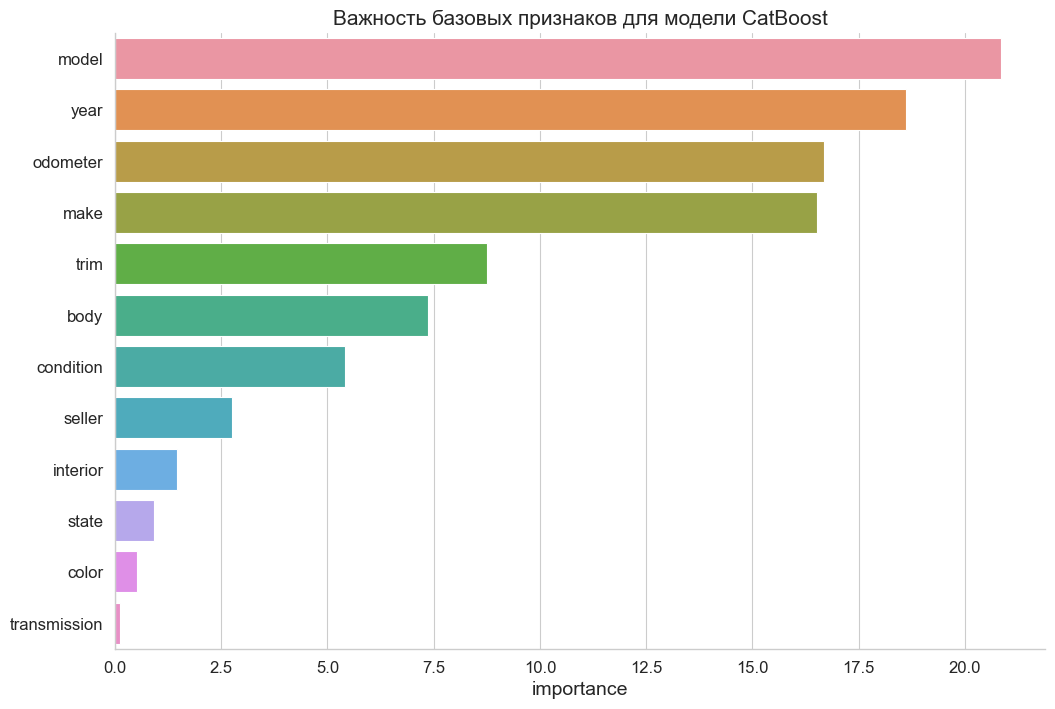

In [247]:
plt.figure(figsize=[12, 8])
plt.title('Важность базовых признаков для модели CatBoost', fontsize=15)
sns.barplot(y=feature_importance_cb.index, x=feature_importance_cb['importance']);

**Комментарий:** С важностью признаков все логично.

#### decreased cardinality data

In [439]:
cbr = CatBoostRegressor(random_seed=RS, cat_features=cat_features, verbose=False)

In [440]:
cbr_score = -cross_val_score(cbr, features, target, cv=3, scoring='neg_mean_absolute_percentage_error').mean()

In [441]:
cbr_score

0.19732972360560944

In [309]:
score_list.append(('CatBoost_lowcardinality_features', 'MAPE', 0.19732972360560944))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330


**Комментарий:** Да, метрика на изначальных данных ощутимо лучше, чем на облагороженных, но это может быть и переобучение, учитывая высокую кардинальность признаков. На тестовых данных будет понятнее. Что касается метрики на тренировочных данных, то еще есть, что оптимизировать, чтобы улучшить метрику катбуста "из коробки" на базовых фичах, например в данной задаче трансформация таргета модет улучшить метрику (логарифмирование, так как распределение таргета имеет длинный хвост справа).

## Feature engineering
[В начало](#0)

### Сlustering

**Комментарий:** Попробуем разбить объекты на 5 кластеров методом К-средних и используем эти кластеры как один из признаков для обучения моделей.

In [9]:
features_km = train_b.drop([
    'vin', 'saledate', 'sale_year', 'ct_make', 'ct_model', 'trim', 'ct_state', 'seller',
    'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year',
    'age', 'sellingprice'
],
    axis=1).copy()

In [10]:
features_km.shape

(436469, 14)

In [11]:
cat_features_km = features_km.select_dtypes(include='object').columns.to_list()

In [12]:
ohe_km = OneHotEncoder(handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
ohe_km.fit(features_km[cat_features_km])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_km[
    ohe_km.get_feature_names_out()
] = ohe_km.transform(features_km[cat_features_km])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_km = features_km.drop(cat_features_km, axis=1)

In [13]:
km = KMeans(n_clusters=5)

In [14]:
km.fit(features_km)

KMeans(n_clusters=5)

In [15]:
train_b['cluster'] = (km.predict(features_km)).astype('object')

In [16]:
train_b

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,ct_trim,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,ct_make,ct_model,cluster
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,sel,md,black,black,santander consumer,north america,canada,ford,edge,3
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,se,mo,black,black,rare,north america,mexico,ford,fusion,4
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,rare,nj,black,black,nissan infiniti lt,north america,mexico,nissan,sentra,4
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,base,tx,gold,beige,rare,north america,united states,rare,rare,2
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,...,sel,md,black,black,rare,north america,mexico,ford,fusion,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,2013,kia,optima,ex hybrid,sedan,automatic,knagm4ad4d5057805,ca,4.5,20434.0,...,rare,ca,white,beige,rare,asia,south korea,kia,optima,4
436465,2014,mini,cooper countryman,s all4,wagon,automatic,wmwzc5c55ewp36517,wi,2.9,14675.0,...,rare,wi,white,black,rare,europe,germany,mini,rare,4
436466,2008,bmw,6 series,650i,coupe,automatic,wbaea53588cv90110,ca,3.7,102552.0,...,rare,ca,gray,black,rare,europe,germany,bmw,rare,3
436467,2014,ram,2500,slt,cab,automatic,3c6ur5dl2eg243568,tx,3.0,29367.0,...,slt,tx,white,gray,rare,north america,mexico,ram,rare,4


### Engineering

**Комментарий:** Добавим признак "годовой пробег", поделив общий пробег на возраст авто.

In [17]:
train_b['odoyear'] = train_b.apply(
    lambda row: row['odometer']
    if row['age'] == 0 else round(row['odometer'] / row['age'], 2),
    axis=1)

In [18]:
train_b.sample(50)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,ct_make,ct_model,cluster,odoyear
49289,2013,chevrolet,sonic,lt,sedan,automatic,1g1jc5shxd4215257,mi,4.1,47753.0,...,mi,gray,black,the hertz corporation,north america,united states,chevrolet,sonic,0,23876.50
81793,2014,subaru,outback,2.5i premium pzev,wagon,automatic,4s4brbcc0e3325362,ca,4.8,19392.0,...,ca,blue,black,rare,north america,united states,subaru,outback,4,19392.00
367540,2014,kia,sorento,lx,suv,automatic,5xykt3a69eg483901,tx,4.6,40160.0,...,tx,brown,gray,avis corporation,north america,united states,kia,sorento,0,40160.00
2161,2014,toyota,camry,xle,sedan,automatic,4t1bf1fk3eu327266,sc,3.0,33959.0,...,rare,gray,gray,rare,north america,united states,toyota,camry,4,33959.00
349498,2013,chevrolet,silverado 1500,ls,cab,automatic,3gcpcrea4dg284097,tn,4.1,34422.0,...,tn,blue,black,rare,north america,mexico,chevrolet,silverado 1500,4,17211.00
13283,2012,chrysler,200,lx,sedan,automatic,1c3ccbab4cn295616,md,1.9,54428.0,...,md,silver,gray,rare,north america,united states,chrysler,200,0,18142.67
36897,2013,honda,odyssey,lx,minivan,automatic,5fnrl5h2xdb058769,il,1.9,33162.0,...,il,gray,gray,avis corporation,north america,united states,honda,odyssey,4,16581.00
281875,2012,honda,civic,lx,sedan,automatic,19xfb2f57ce321189,pa,3.6,30193.0,...,pa,gray,gray,ahfc honda lease trust hvt inc eot,north america,united states,honda,civic,4,10064.33
84084,2011,chevrolet,malibu,ltz,sedan,automatic,1g1ze5euxbf382094,tx,3.4,82768.0,...,tx,brown,black,rare,north america,united states,chevrolet,malibu,3,20692.00
215927,2012,cadillac,cts,premium,sedan,automatic,1g6ds5e35c0120346,mi,4.6,9956.0,...,mi,white,beige,rare,north america,united states,cadillac,cts,4,3318.67


### Target encoding

**Комментарий:** Применим кодирование основных категориальных фичей: марка и модель авто через среднее значение таргета, Catboost имеет подобный энкодер у себя под капотом, будет возможноть сравнить их в действии. Также в sklearn было готовое решение, но сейчас оно, как-будто, не работает.

In [19]:
train_b['make_te'] = train_b['make'].map(train_b.groupby('make')['sellingprice'].mean()).astype('int64')
#test['make_target'] = test['make'].map(df.groupby('make')['sellingprice'].mean()).fillna(0).astype('int64')

In [20]:
train_b['model_te'] = train_b['model'].map(train_b.groupby('model')['sellingprice'].mean()).astype('int64')
#test['model_target'] = test['model'].map(df.groupby('model')['sellingprice'].mean()).fillna(0).astype('int64')

### OUTPUT

In [35]:
#train_b.to_csv('modeling_train.csv', index=False)

In [ ]:
#test_b.to_csv('modeling_test.csv', index=False)

## Feature selection
[В начало](#0)

**Комментарий:** Попробуем различные методы отбора признаков, для удобства и скорости сравнения для начала закодируем все кат. переменные таргет энкодером от CatBoost, а потом все числовые признаки, включая полученные после Target Encoding масштабируем. 

### INPUT

In [158]:
train_m = pd.read_csv('modeling_train.csv')
#test_m = pd.read_csv('modeling_test.csv')

### Features

In [160]:
target_m = train_m['sellingprice']

In [161]:
target_m.shape

(436469,)

In [162]:
train_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436469 entries, 0 to 436468
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          436469 non-null  int64  
 1   make          436469 non-null  object 
 2   model         436469 non-null  object 
 3   trim          436469 non-null  object 
 4   body          436469 non-null  object 
 5   transmission  436469 non-null  object 
 6   vin           436469 non-null  object 
 7   state         436469 non-null  object 
 8   condition     436469 non-null  float64
 9   odometer      436469 non-null  float64
 10  color         436469 non-null  object 
 11  interior      436469 non-null  object 
 12  seller        436469 non-null  object 
 13  sellingprice  436469 non-null  int64  
 14  saledate      436469 non-null  object 
 15  region        436469 non-null  object 
 16  country       436469 non-null  object 
 17  vin_model     436469 non-null  object 
 18  vin_

In [163]:
train_m['cluster'] = train_m['cluster'].astype('object')

In [164]:
features_fs = train_m.drop([
    'year', 'ct_make', 'make_te', 'ct_model', 'model_te', 'trim', 'vin', 'ct_state', 'ct_color', 'ct_interior',
    'seller', 'sellingprice', 'saledate', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year', 
    'sale_year'
],
                          axis=1).copy()

In [165]:
features_fs

,make,model,body,transmission,state,condition,odometer,color,interior,region,country,age,ct_trim,ct_seller,cluster,odoyear
0,ford,edge,suv,automatic,md,4.2,111041.0,black,black,north america,canada,4,sel,santander consumer,3,27760.25
1,ford,fusion,sedan,automatic,mo,3.5,31034.0,black,black,north america,mexico,1,se,rare,4,31034.00
2,nissan,sentra,sedan,automatic,nj,2.2,35619.0,black,black,north america,mexico,3,rare,nissan infiniti lt,4,11873.00
3,hummer,h2,suv,automatic,tx,2.8,131301.0,gold,beige,north america,united states,12,base,rare,2,10941.75
4,ford,fusion,sedan,automatic,md,2.0,127709.0,black,black,north america,mexico,8,sel,rare,2,15963.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,kia,optima,sedan,automatic,ca,4.5,20434.0,white,beige,asia,south korea,2,rare,rare,4,10217.00
436465,mini,cooper countryman,wagon,automatic,wi,2.9,14675.0,white,black,europe,germany,1,rare,rare,4,14675.00
436466,bmw,6 series,coupe,automatic,ca,3.7,102552.0,gray,black,europe,germany,7,rare,rare,3,14650.29
436467,ram,2500,cab,automatic,tx,3.0,29367.0,white,gray,north america,mexico,1,slt,rare,4,29367.00


In [166]:
target_fs = train_m['sellingprice']

In [167]:
cat_features_fs = features_fs.select_dtypes(include='object').columns.to_list()

In [168]:
num_features_fs = features_fs.select_dtypes(exclude='object').columns.to_list()

In [169]:
all_features_fs = cat_features_fs + num_features_fs

In [170]:
#Catboost encoder
encoder_fs = CatBoostEncoder()
features_fs[cat_features_fs] = encoder_fs.fit_transform(features_fs[cat_features_fs], target_fs)

In [171]:
features_fs[cat_features_fs]

,make,model,body,transmission,state,color,interior,region,country,ct_trim,ct_seller,cluster
0,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209,13689.477209
1,13094.738605,13689.477209,13689.477209,13094.738605,13689.477209,13094.738605,13094.738605,13094.738605,13689.477209,13689.477209,13689.477209,13689.477209
2,13689.477209,13689.477209,14094.738605,13563.159070,13689.477209,13563.159070,13563.159070,13563.159070,14094.738605,13689.477209,13689.477209,14094.738605
3,13689.477209,13689.477209,13094.738605,12447.369302,13689.477209,13689.477209,13689.477209,12447.369302,13689.477209,13689.477209,14094.738605,13689.477209
4,13563.159070,14094.738605,12429.825736,12617.895442,13094.738605,12447.369302,12447.369302,12617.895442,12429.825736,13094.738605,13829.825736,13494.738605
...,...,...,...,...,...,...,...,...,...,...,...,...
436464,11822.675375,13414.766479,12026.554501,13763.924417,14671.471101,15004.511559,13415.164337,13202.491683,9766.956343,15253.693409,13016.611659,19683.237594
436465,12342.798009,19076.225534,9751.330847,13763.929703,13927.353115,15004.522736,15624.258841,19832.398708,20061.658365,15253.697243,13016.621335,19683.215023
436466,21946.660301,33405.275720,16587.741816,13763.954488,14671.494496,13998.130009,15624.301985,19832.500368,20061.773547,15253.743460,13016.657770,8790.727898
436467,25236.118239,32359.172783,17666.586539,13763.961546,13248.000656,15004.626544,10981.955038,12972.333812,12151.570486,15170.629939,13016.669879,19683.243008


In [172]:
scaler_fs = StandardScaler()                        
features_fs[all_features_fs] = scaler_fs.fit_transform(features_fs[all_features_fs])

In [173]:
features_fs

,make,model,body,transmission,state,condition,odometer,color,interior,region,country,age,ct_trim,ct_seller,cluster,odoyear
0,0.003171,0.003463,0.006968,0.038017,0.008556,0.824550,0.854954,0.005425,0.006429,0.004962,0.004683,-0.200315,0.007115,0.004749,0.000959,1.295124
1,-0.134022,0.003463,0.006968,-1.435436,0.008556,0.082635,-0.709904,-0.286879,-0.247325,-0.286802,0.004683,-0.998663,0.007115,0.004749,0.000959,1.659618
2,0.003171,0.003463,0.170669,-0.274934,0.008556,-1.295208,-0.620226,-0.056658,-0.047466,-0.057007,0.171636,-0.466431,0.007115,0.004749,0.071041,-0.473734
3,0.003171,0.003463,-0.233269,-3.039281,0.008556,-0.659280,1.251220,0.005425,0.006429,-0.604384,0.004683,1.928615,0.007115,0.152487,0.000959,-0.577418
4,-0.025968,0.066401,-0.501853,-2.616806,-0.262813,-1.507183,1.180964,-0.605051,-0.523536,-0.520729,-0.514247,0.864150,-0.265882,0.055913,-0.032717,-0.018292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,-0.427461,-0.039201,-0.664749,0.222458,0.456624,1.142514,-0.917230,0.651743,-0.110611,-0.233941,-1.611251,-0.732547,0.725125,-0.240544,1.037454,-0.658110
436465,-0.307479,0.840043,-1.583799,0.222472,0.117095,-0.553293,-1.029870,0.651749,0.831935,3.018522,2.629787,-0.998663,0.725126,-0.240540,1.037450,-0.161764
436466,1.907931,3.065392,1.177688,0.222533,0.456635,0.294611,0.688918,0.157123,0.831953,3.018572,2.629834,0.598034,0.725148,-0.240527,-0.846177,-0.164515
436467,2.666740,2.902929,1.613474,0.222550,-0.192882,-0.447305,-0.742509,0.651800,-1.148778,-0.346850,-0.628878,-0.998663,0.686997,-0.240522,1.037455,1.474017


### Mutual info regression

In [174]:
mutual_info_fs = mutual_info_regression(features_fs, target_fs)
mutual_info_fs = pd.Series(mutual_info_fs)
mutual_info_fs.index = features_fs.columns
mutual_info_fs.sort_values(ascending=False)

model           0.459640
age             0.430324
odometer        0.419595
cluster         0.372916
condition       0.269798
make            0.178433
ct_seller       0.136362
ct_trim         0.114216
body            0.084956
state           0.076886
country         0.061085
odoyear         0.053007
interior        0.044892
region          0.037442
color           0.032524
transmission    0.002927
dtype: float64

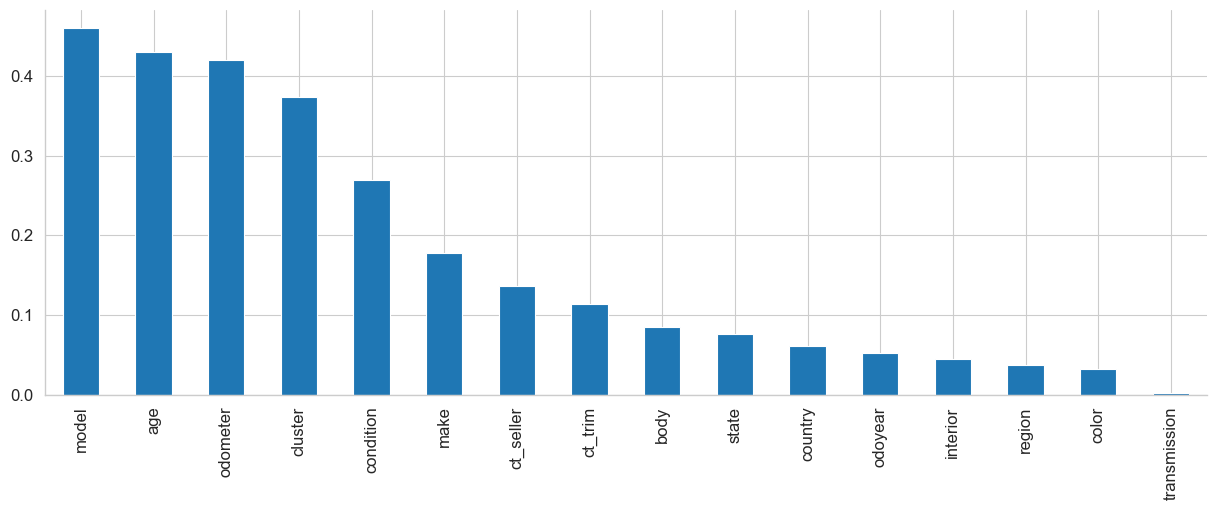

In [175]:
mutual_info_fs.sort_values(ascending=False).head(20).plot.bar(figsize=(15,5));

In [176]:
features_mir = features_fs.drop([
    'region', 'color', 'interior', 'transmission', 'odoyear'
],
                          axis=1).copy()

In [177]:
features_mir

,make,model,body,state,condition,odometer,country,age,ct_trim,ct_seller,cluster
0,0.003171,0.003463,0.006968,0.008556,0.824550,0.854954,0.004683,-0.200315,0.007115,0.004749,0.000959
1,-0.134022,0.003463,0.006968,0.008556,0.082635,-0.709904,0.004683,-0.998663,0.007115,0.004749,0.000959
2,0.003171,0.003463,0.170669,0.008556,-1.295208,-0.620226,0.171636,-0.466431,0.007115,0.004749,0.071041
3,0.003171,0.003463,-0.233269,0.008556,-0.659280,1.251220,0.004683,1.928615,0.007115,0.152487,0.000959
4,-0.025968,0.066401,-0.501853,-0.262813,-1.507183,1.180964,-0.514247,0.864150,-0.265882,0.055913,-0.032717
...,...,...,...,...,...,...,...,...,...,...,...
436464,-0.427461,-0.039201,-0.664749,0.456624,1.142514,-0.917230,-1.611251,-0.732547,0.725125,-0.240544,1.037454
436465,-0.307479,0.840043,-1.583799,0.117095,-0.553293,-1.029870,2.629787,-0.998663,0.725126,-0.240540,1.037450
436466,1.907931,3.065392,1.177688,0.456635,0.294611,0.688918,2.629834,0.598034,0.725148,-0.240527,-0.846177
436467,2.666740,2.902929,1.613474,-0.192882,-0.447305,-0.742509,-0.628878,-0.998663,0.686997,-0.240522,1.037455


### VIF

In [178]:
vif_fs = pd.DataFrame()
vif_fs['feature'] = features_fs.columns
vif_fs['vif'] = [variance_inflation_factor(features_fs.values, i) for i in range(features_fs.shape[1])]
# take a look
vif_fs

,feature,vif
0,make,2.198387
1,model,2.219824
2,body,1.300594
3,transmission,1.019413
4,state,1.077605
5,condition,1.571496
6,odometer,10.927823
7,color,1.069366
8,interior,1.109803
9,region,3.457414


**Комментарий:** считается, что фичи со значением фактора инфляции дисперсии свыше 5 имеют мультиколлинеарность и их желательно удалить, попробуем это сделать и заново оценить VIF.

In [180]:
features_vif = features_fs.drop([
    'region', 'cluster', 'odometer'
],
                          axis=1).copy()

In [181]:
vif_2 = pd.DataFrame()
vif_2['feature'] = features_vif.columns
vif_2['vif'] = [variance_inflation_factor(features_vif.values, i) for i in range(features_vif.shape[1])]
# take a look
vif_2

,feature,vif
0,make,2.188959
1,model,2.211482
2,body,1.277362
3,transmission,1.017462
4,state,1.072218
5,condition,1.547617
6,color,1.067776
7,interior,1.105771
8,country,1.559024
9,age,1.951805


In [182]:
features_vif

,make,model,body,transmission,state,condition,color,interior,country,age,ct_trim,ct_seller,odoyear
0,0.003171,0.003463,0.006968,0.038017,0.008556,0.824550,0.005425,0.006429,0.004683,-0.200315,0.007115,0.004749,1.295124
1,-0.134022,0.003463,0.006968,-1.435436,0.008556,0.082635,-0.286879,-0.247325,0.004683,-0.998663,0.007115,0.004749,1.659618
2,0.003171,0.003463,0.170669,-0.274934,0.008556,-1.295208,-0.056658,-0.047466,0.171636,-0.466431,0.007115,0.004749,-0.473734
3,0.003171,0.003463,-0.233269,-3.039281,0.008556,-0.659280,0.005425,0.006429,0.004683,1.928615,0.007115,0.152487,-0.577418
4,-0.025968,0.066401,-0.501853,-2.616806,-0.262813,-1.507183,-0.605051,-0.523536,-0.514247,0.864150,-0.265882,0.055913,-0.018292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,-0.427461,-0.039201,-0.664749,0.222458,0.456624,1.142514,0.651743,-0.110611,-1.611251,-0.732547,0.725125,-0.240544,-0.658110
436465,-0.307479,0.840043,-1.583799,0.222472,0.117095,-0.553293,0.651749,0.831935,2.629787,-0.998663,0.725126,-0.240540,-0.161764
436466,1.907931,3.065392,1.177688,0.222533,0.456635,0.294611,0.157123,0.831953,2.629834,0.598034,0.725148,-0.240527,-0.164515
436467,2.666740,2.902929,1.613474,0.222550,-0.192882,-0.447305,0.651800,-1.148778,-0.628878,-0.998663,0.686997,-0.240522,1.474017


### PCA

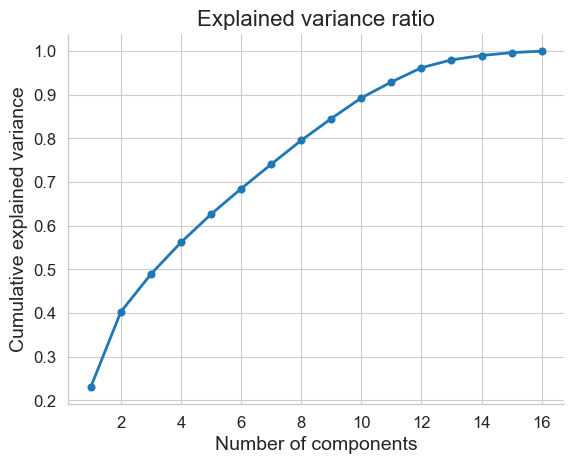

In [183]:
pca = PCA()
features_pca = pca.fit_transform(features_fs)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance ratio')
plt.show()

**Комментарий:** Согласно графику 14 признаков должны практически полностью составлять накопленную объясненную дисперсию для компонент, полученных PCA. Данный метод плох тем, что в нем компоненты теряют интерпретируемость, что для нашего случая не очень удобно. Тем не менее, посмотрим, как он себя покажет.

In [184]:
# Select the optimal number of components and apply dimensionality reduction
n_components = 14
features_reduced = features_pca[:, :n_components]

# Create a DataFrame to store the reduced features
train_reduced = pd.DataFrame(data=features_reduced, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the target variable to the reduced DataFrame
train_reduced['target'] = train_m['sellingprice']

In [185]:
train_reduced

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,target
0,-0.060340,-0.124193,0.547967,1.134598,0.153458,0.406479,-0.195549,0.376621,0.162099,-0.382658,-0.544096,0.580779,0.025811,0.021141,12500
1,0.422529,-0.835923,0.311292,0.722348,1.107315,1.070225,-0.068960,1.024935,0.558634,-0.808222,0.179794,-0.555491,0.124325,0.194236,14500
2,0.061483,0.028528,-0.271996,-0.437102,0.113166,-0.132329,0.110160,-0.018995,0.041088,0.184810,0.733023,-1.207987,0.052267,0.130987,9100
3,-1.623319,0.954486,-0.551248,-1.544750,2.237148,-0.019043,0.312485,1.030491,0.987301,0.046227,0.645176,0.574707,-0.044327,0.482619,13300
4,-1.877801,0.342611,-0.553585,-0.901117,1.604202,0.618905,0.221678,1.129913,1.063146,-0.163504,1.385800,-0.206335,-0.177032,0.043336,1300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,1.233310,-1.808885,0.202890,-0.786062,0.049567,-0.666715,0.136954,-0.563704,-0.510286,-0.840088,0.225095,0.728452,-0.264792,-0.936743,16000
436465,2.577797,1.789550,-2.477298,1.146708,0.363246,-0.156656,0.029347,-0.233954,-1.618265,-0.679886,-0.214877,-1.520251,-1.267103,-0.077780,24250
436466,1.937095,5.009760,0.674705,0.510564,-0.093185,0.511459,-0.638358,0.655197,-1.055288,0.646236,-0.556776,-0.012569,-1.022086,-0.325586,16750
436467,2.097883,0.947024,3.339512,0.334966,-0.776821,1.119918,0.780103,0.932368,-0.154452,-0.361638,2.226084,-0.687683,0.312829,-0.465257,33000


In [186]:
features_pcared = train_reduced.drop([
    'target'
],
                          axis=1).copy()
target_pcared = train_reduced['target']

## Modeling
[В начало](#0)

### linear

In [187]:
en_fs = ElasticNet(l1_ratio=0.5, random_state=RS, selection='random')

In [188]:
en_fs_score = -cross_val_score(
    en_fs,
    features_fs,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [189]:
en_fs_score

0.5145438477440076

In [190]:
en_mir_score = -cross_val_score(
    en_fs,
    features_mir,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [191]:
en_mir_score

0.5127370657894065

In [310]:
score_list.append(('ElasticNet_mutualinfo_features', 'MAPE', 0.5127370657894065))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737


In [192]:
en_vif_score = -cross_val_score(
    en_fs,
    features_vif,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [193]:
en_vif_score

0.5327071978553733

In [194]:
en_pcared_score = -cross_val_score(
    en_fs,
    features_pcared,
    target_pcared,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [195]:
en_pcared_score

0.51596192524271

**Комментарий:** Мы заменили базовую Lasso, которая должна была помочь в отборе признаков на более универсальную ElasticNet с балансом из 2 штрафов, метрика улучшилась но все равно осталась не очень. Попробуем далее еще обучить линейную модель с подбором гиперпараметров для полноты картины. В целом же связи в большей степени нелинейные и деревянные модели должны лучше справиться, что мы уже оценили на бейзлайне.

### forest

In [131]:
rf_fs = RandomForestRegressor(random_state=RS)

In [132]:
rf_fs_score = -cross_val_score(
    rf_fs,
    features_fs,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [133]:
rf_fs_score

0.23029367195121273

In [134]:
rf_mir_score = -cross_val_score(
    rf_fs,
    features_mir,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [135]:
rf_mir_score

0.22694798727572607

In [311]:
score_list.append(('RandomForest_mutualinfo_features', 'MAPE', 0.22694798727572607))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948


In [136]:
rf_vif_score = -cross_val_score(
    rf_fs,
    features_vif,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [137]:
rf_vif_score

0.23289173302908286

In [138]:
rf_pcared_score = -cross_val_score(
    rf_fs,
    features_pcared,
    target_pcared,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [139]:
rf_pcared_score

0.2532125863789362

**Комментарий:** Линейная и деревянная модели показали, что лучшим из методов подбора фичей при прочих равных вышел mutual_info_regression. Однако на кодированных таким образом фичах метрика случайного леса ухудшилась, попробуем другие фичи и подбор гиперпараметров.

### boosting

**Комментарий:** Катбуст может и сам справиться с кодированием и нормированием фичей, поэтому данные наборы признаков в него "пихать" несколько странно, но для чистоты эксперимента попробуем.

In [141]:
cat_features_fs = features_fs.select_dtypes(include='object').columns.to_list()

In [142]:
cb_fs = CatBoostRegressor(random_seed=RS, cat_features=cat_features_fs, verbose=False)

In [143]:
cb_fs_score = -cross_val_score(
    cb_fs,
    features_fs,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [144]:
cb_fs_score

0.2372967555355977

In [196]:
cat_features_mir = features_mir.select_dtypes(include='object').columns.to_list()

In [197]:
cb_mir = CatBoostRegressor(random_seed=RS, cat_features=cat_features_mir, verbose=False)

In [198]:
cb_mir_score = -cross_val_score(
    cb_mir,
    features_mir,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [199]:
cb_mir_score

0.21076589193102566

In [312]:
score_list.append(('CatBoost_mutualinfo_features', 'MAPE', 0.21076589193102566))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766


In [149]:
cat_features_vif = features_vif.select_dtypes(include='object').columns.to_list()

In [150]:
cb_vif = CatBoostRegressor(random_seed=RS, cat_features=cat_features_vif, verbose=False)

In [151]:
cb_vif_score = -cross_val_score(
    cb_vif,
    features_vif,
    target_m,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [152]:
cb_vif_score

0.23372553155789869

In [153]:
cat_features_pcared = features_pcared.select_dtypes(include='object').columns.to_list()

In [154]:
cb_pcared = CatBoostRegressor(random_seed=RS, cat_features=cat_features_pcared, verbose=False)

In [155]:
cb_pcared_score = -cross_val_score(
    cb_pcared,
    features_pcared,
    target_pcared,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [156]:
cb_pcared_score

0.26428635410450074

**Комментарий:** На бустинге метрика тоже упала, но она по прежнему лучшая среди 3 моделей. Попробуем с другими признаками и подбором параметров.

### INPUT

In [8]:
train_m = pd.read_csv('modeling_train.csv')
#test_m = pd.read_csv('modeling_test.csv')

In [ ]:
train_m['cluster'] = train_m['cluster'].astype('object')

### Elastic net + GridSearchCV

In [252]:
features_en = train_m.drop([
    'vin', 'saledate', 'sale_year', 'make', 'ct_make', 'model', 'ct_model', 'trim', 'state',
    'seller', 'color', 'interior', 'region', 'country', 'vin_model', 'vin_body', 'vin_year',
    'year', 'odometer', 'sellingprice'
],
    axis=1).copy()

In [253]:
features_en

,body,transmission,condition,age,ct_trim,ct_state,ct_color,ct_interior,ct_seller,ct_region,ct_country,cluster,odoyear,make_te,model_te
0,suv,automatic,4.2,4,sel,md,black,black,santander consumer,north america,canada,3,27760.25,14426,18820
1,sedan,automatic,3.5,1,se,mo,black,black,rare,north america,mexico,4,31034.00,14426,12367
2,sedan,automatic,2.2,3,rare,nj,black,black,nissan infiniti lt,north america,mexico,4,11873.00,11759,8780
3,suv,automatic,2.8,12,base,tx,gold,beige,rare,north america,united states,2,10941.75,15319,18475
4,sedan,automatic,2.0,8,sel,md,black,black,rare,north america,mexico,2,15963.62,14426,12367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,sedan,automatic,4.5,2,rare,ca,white,beige,rare,asia,south korea,4,10217.00,11822,13415
436465,wagon,automatic,2.9,1,rare,wi,white,black,rare,europe,germany,4,14675.00,12347,19104
436466,coupe,automatic,3.7,7,rare,ca,gray,black,rare,europe,germany,3,14650.29,21946,33411
436467,cab,automatic,3.0,1,slt,tx,white,gray,rare,north america,mexico,4,29367.00,25241,32385


In [254]:
target_en = train_m['sellingprice']

In [255]:
num_features_en = features_en.select_dtypes(exclude='object').columns.to_list()

In [256]:
cat_features_en = features_en.select_dtypes(include='object').columns.to_list()

In [257]:
preprocessor_en = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), num_features_en),
    ('encode', OneHotEncoder(handle_unknown='ignore'), cat_features_en),
])

In [258]:
en = ElasticNet(l1_ratio=0.5, random_state=RS, selection='random')

In [259]:
pipeline_en = make_pipeline(preprocessor_en, en)

param_grid_en = {'elasticnet__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 7.0, 10.0, 20]}

en_gs_pl = GridSearchCV(
    pipeline_en, 
    param_grid=param_grid_en, 
    scoring='neg_mean_absolute_percentage_error', 
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [260]:
en_gs_pl.fit(features_en, target_en)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/sergeypervov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3027855621042.2275, tolerance: 2760920883.5963955
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/sergeypervov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3008939219437.2266, tolerance: 2750526878.46063
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/sergeypervov/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2990906717409.767, tolerance: 2728446701.2594023
  model = cd_fast.sparse_enet_coordinate_descent(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['condition',
                                                                          'age',
                                                                          'odoyear',
                                                                          'make_te',
                                                                          'model_te']),
                                                                        ('encode',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['body',
                                                                          'transmission',
                                                                          'ct_trim',
                                                                          'ct_state',
                                                                          'ct_color',
                                                                          'ct_interior',
                                                                          'ct_seller',
                                                                          'ct_region',
                                                                          'ct_country',
                                                                          'cluster'])])),
                                       ('elasticnet',
                                        ElasticNet(random_state=42,
                                                   selection='random'))]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 7.0,
                                               10.0, 20]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [261]:
# среднее лучшее значение MAPE на кросс-валидации
print(f'Среднее лучшее значение MAPE линейной регрессии на кросс-валидации: {-en_gs_pl.best_score_}')
# лучшие гиперпараметры
print(f'Лучшие гиперпараметры линейной регрессии: {en_gs_pl.best_params_}')

Среднее лучшее значение MAPE линейной регрессии на кросс-валидации: 0.5300234736768225
Лучшие гиперпараметры линейной регрессии: {'elasticnet__alpha': 1.0}


In [313]:
score_list.append(('ElasticNet_targenc_ohe_gridcv', 'MAPE', 0.5300234736768225))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023


**Комментарий:** Метрику улучшить не получилось. Скорее всего есть потенциал улучшения линейных моделей за счет полиномиальных признаков или других их трансформаций, например логарифмирования (распределения возраста и пробега походят на что-то такое), однако догнать деревянные модели маловероятно.

In [203]:
en_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 7.0, 10.0, 20]}

en_cv = GridSearchCV(
    ElasticNet(l1_ratio=0.5, random_state=RS, selection='random'),
    param_grid=en_params,
    scoring='neg_mean_absolute_percentage_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
en_cv_df = en_cv.fit(features_mir, target_m)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [204]:
print(
    f'Среднее лучшее значение MAPE линейной регрессии на кросс-валидации: {-en_cv_df.best_score_}'
)
print(
    f'Лучшие гиперпараметры линейной регрессии: {en_cv_df.best_params_}'
)

Среднее лучшее значение MAPE линейной регрессии на кросс-валидации: 0.5516278794201409
Лучшие гиперпараметры линейной регрессии: {'alpha': 0.5}


### Random forest + RandomSearchCV

**Комментарий:** Со случайным лесом во избежание очень долгого подбора используем RandomizedSearchCV с не самыми большими разбросами значений параметров. Да, возможно мы не найдем самое оптимальное значение параметров, но близкое и за вменяемое время.

In [21]:
features_rfr = train_m.drop([
    'vin', 'saledate', 'sale_year', 'make', 'ct_make', 'model', 'ct_model', 'trim', 'state',
    'seller', 'color', 'interior', 'region', 'country', 'vin_model', 'vin_body', 'vin_year',
    'year', 'sellingprice'
],
    axis=1).copy()

In [22]:
target_rfr = train_m['sellingprice']

In [23]:
num_features_rfr = features_rfr.select_dtypes(exclude='object').columns.to_list()

In [24]:
cat_features_rfr = features_rfr.select_dtypes(include='object').columns.to_list()

In [26]:
preprocessor_rfr = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), num_features_rfr),
    ('encode',
     OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
     cat_features_rfr),
])

In [27]:
rfr = RandomForestRegressor(random_state=RS)

In [28]:
pipeline_rfr = make_pipeline(preprocessor_rfr, rfr) #col_transformer_rf

param_dist_rfr = {'randomforestregressor__max_depth': [None, 2, 3, 5, 10],
                  'randomforestregressor__n_estimators': np.arange(10, 100, 10),
                  'randomforestregressor__max_features': [0.5, 1.0, "sqrt"],
                  'randomforestregressor__min_samples_leaf': np.arange(1, 5, 1),
                  'randomforestregressor__min_samples_split': np.arange(2, 10, 2)
}

rfr_rs_pl = RandomizedSearchCV(
    pipeline_rfr, 
    param_distributions=param_dist_rfr, 
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_percentage_error', 
    n_jobs=-1,
    random_state=RS
)

In [29]:
rfr_rs_pl.fit(features_rfr, target_rfr)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('scale',
                                                                               StandardScaler(),
                                                                               ['condition',
                                                                                'odometer',
                                                                                'age',
                                                                                'odoyear',
                                                                                'make_te',
                                                                                'model_te']),
                                                                              ('encode',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['body',
                                                                                'transmission',
                                                                                'ct_trim',
                                                                                'ct_state',
                                                                                'ct_color',
                                                                                'ct_interior',
                                                                                'ct_seller'...
                   param_distributions={'randomforestregressor__max_depth': [None,
                                                                             2,
                                                                             3,
                                                                             5,
                                                                             10],
                                        'randomforestregressor__max_features': [0.5,
                                                                                1.0,
                                                                                'sqrt'],
                                        'randomforestregressor__min_samples_leaf': array([1, 2, 3, 4]),
                                        'randomforestregressor__min_samples_split': array([2, 4, 6, 8]),
                                        'randomforestregressor__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42,
                   scoring='neg_mean_absolute_percentage_error')

In [30]:
# среднее лучшее значение MAPE на кросс-валидации
print(f'Среднее лучшее значение MAPE линейной регрессии на кросс-валидации: {-rfr_rs_pl.best_score_}')
# лучшие гиперпараметры
print(f'Лучшие гиперпараметры линейной регрессии: {rfr_rs_pl.best_params_}')

Среднее лучшее значение MAPE линейной регрессии на кросс-валидации: 0.1740016971813365
Лучшие гиперпараметры линейной регрессии: {'randomforestregressor__n_estimators': 40, 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__max_depth': None}


In [314]:
score_list.append(('RandomForest_target_ohe_randcv', 'MAPE', 0.1740016971813365))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023
9,RandomForest_target_ohe_randcv,MAPE,0.174002


**Комментарий:** Особо улучшить метрику за счет подбора гиперпараметров по сравнению с бейзлайном не удалось. Возможно это бы получилось сделать, использовав более широкие диапазоны и больше ресурсов или тот же Optuna, но зачем тратить столько времени, если можно использовать те же техники с CatBoost. Лес был больше полезен как бейзлайн и как один из способов отбора признаков.

### Catboost + Optuna

#### Original features

In [264]:
features_cbm = train_m.drop([
    'vin', 'saledate', 'sale_year', 'ct_make', 'ct_model', 'ct_trim', 'ct_state', 'ct_seller',
    'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year',
    'age', 'sellingprice', 'region', 'country', 'cluster', 'odoyear', 'make_te', 'model_te'
],
    axis=1).copy()

In [267]:
features_cbm

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars avis budget group
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan infiniti lt
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart
...,...,...,...,...,...,...,...,...,...,...,...,...
436464,2013,kia,optima,ex hybrid,sedan,automatic,ca,4.5,20434.0,white,beige,kia motors america inc
436465,2014,mini,cooper countryman,s all4,wagon,automatic,wi,2.9,14675.0,white,black,bmw mini financial services
436466,2008,bmw,6 series,650i,coupe,automatic,ca,3.7,102552.0,gray,black,studio city auto group
436467,2014,ram,2500,slt,cab,automatic,tx,3.0,29367.0,white,gray,express car truck rental


In [265]:
target_cbm = train_m['sellingprice']

In [266]:
cat_features_cbm = features_cbm.select_dtypes(include='object').columns.to_list()

In [268]:
features_cbm[cat_features_cbm] = features_cbm[cat_features_cbm].astype('category')

In [269]:
cbm = CatBoostRegressor(random_seed=RS, verbose=False, custom_metric='MAPE', eval_metric='MAPE')

In [270]:
param_distrs_cbm = {
    'iterations': optuna.distributions.IntDistribution(800, 2100, 200),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 0.6),   
    'l2_leaf_reg': optuna.distributions.FloatDistribution(1, 21), 
    'max_depth': optuna.distributions.IntDistribution(1, 10)    
}

opt_cbm = optuna.integration.OptunaSearchCV(cbm,
                                            param_distrs_cbopt,
                                            cv=3,
                                            n_trials=5,
                                            random_state=RS,
                                            scoring='neg_mean_absolute_percentage_error') 

In [271]:
opt_cbm.fit(features_cbm, target_cbm, cat_features=cat_features_cbm)

[I 2023-12-05 02:56:12,256] A new study created in memory with name: no-name-109bfd73-332b-48c0-a462-515ca2fd9b44
[I 2023-12-05 03:16:22,008] Trial 0 finished with value: -0.17454316718608406 and parameters: {'iterations': 1240, 'learning_rate': 0.4997465873566609, 'l2_leaf_reg': 2.381026817472084, 'max_depth': 4}. Best is trial 0 with value: -0.17454316718608406.
[I 2023-12-05 03:22:21,445] Trial 1 finished with value: -0.22685809530513987 and parameters: {'iterations': 1277, 'learning_rate': 0.1796587171877133, 'l2_leaf_reg': 5.248525479844451, 'max_depth': 2}. Best is trial 0 with value: -0.17454316718608406.
[I 2023-12-05 04:11:53,261] Trial 2 finished with value: -0.14918968694521736 and parameters: {'iterations': 948, 'learning_rate': 0.19180860068994032, 'l2_leaf_reg': 7.981353264227163, 'max_depth': 10}. Best is trial 2 with value: -0.14918968694521736.
[I 2023-12-05 04:29:58,538] Trial 3 finished with value: -0.17222983543513948 and parameters: {'iterations': 1304, 'learning_r

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x151950e50>,
               n_jobs=1, n_trials=5,
               param_distributions={'iterations': IntDistribution(high=2100, log=200, low=800, step=1),
                                    'l2_leaf_reg': FloatDistribution(high=21.0, log=False, low=1.0, step=None),
                                    'learning_rate': FloatDistribution(high=0.6, log=False, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=42, scoring='neg_mean_absolute_percentage_error')

In [274]:
opt_cbm.best_params_

{'iterations': 948,
 'learning_rate': 0.19180860068994032,
 'l2_leaf_reg': 7.981353264227163,
 'max_depth': 10}

In [275]:
-opt_cbm.best_score_

0.14918968694521736

In [315]:
score_list.append(('Catboost_originalfeat_optcv', 'MAPE', 0.14918968694521736))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023
9,RandomForest_target_ohe_randcv,MAPE,0.174002


In [276]:
explainer_m = shap.TreeExplainer(opt_cbm.best_estimator_)
shap_values_m = explainer_m(features_cbm)

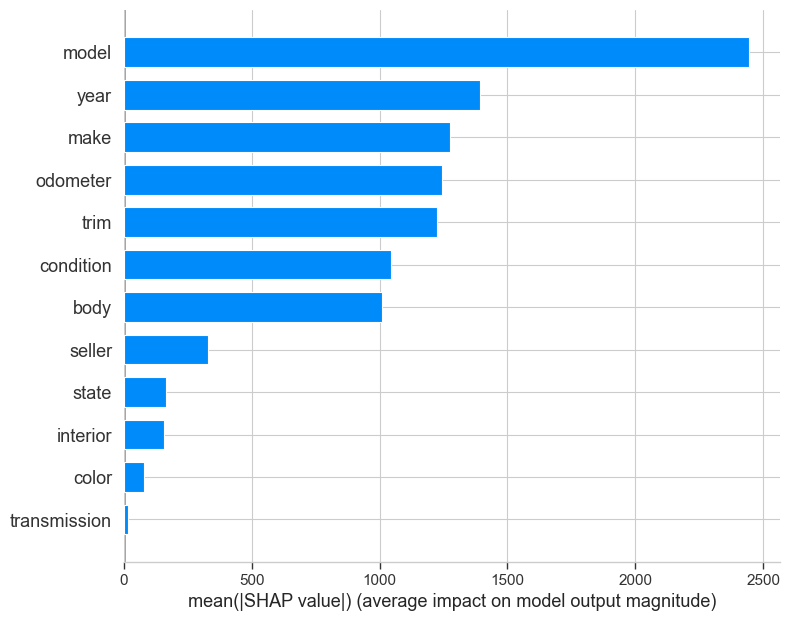

In [277]:
shap.summary_plot(shap_values_m, features_cbm, plot_type='bar')

#### Modified features with manual target encoding for make and model

In [8]:
features_cbopt = train_m.drop([
    'vin', 'saledate', 'sale_year', 'make', 'ct_make', 'model', 'ct_model', 'trim', 'ct_state',
    'seller', 'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 
    'vin_year', 'year', 'sellingprice'
],
    axis=1).copy()

In [208]:
features_cbopt

,body,transmission,state,condition,odometer,color,interior,region,country,age,ct_trim,ct_seller,cluster,odoyear,make_te,model_te
0,suv,automatic,md,4.2,111041.0,black,black,north america,canada,4,sel,santander consumer,3,27760.25,14426,18820
1,sedan,automatic,mo,3.5,31034.0,black,black,north america,mexico,1,se,rare,4,31034.00,14426,12367
2,sedan,automatic,nj,2.2,35619.0,black,black,north america,mexico,3,rare,nissan infiniti lt,4,11873.00,11759,8780
3,suv,automatic,tx,2.8,131301.0,gold,beige,north america,united states,12,base,rare,2,10941.75,15319,18475
4,sedan,automatic,md,2.0,127709.0,black,black,north america,mexico,8,sel,rare,2,15963.62,14426,12367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436464,sedan,automatic,ca,4.5,20434.0,white,beige,asia,south korea,2,rare,rare,4,10217.00,11822,13415
436465,wagon,automatic,wi,2.9,14675.0,white,black,europe,germany,1,rare,rare,4,14675.00,12347,19104
436466,coupe,automatic,ca,3.7,102552.0,gray,black,europe,germany,7,rare,rare,3,14650.29,21946,33411
436467,cab,automatic,tx,3.0,29367.0,white,gray,north america,mexico,1,slt,rare,4,29367.00,25241,32385


In [10]:
target_cbopt = train_m['sellingprice']

In [11]:
cat_features_cbopt = features_cbopt.select_dtypes(include='object').columns.to_list()

In [12]:
features_cbopt[cat_features_cbopt] = features_cbopt[cat_features_cbopt].astype('category')

In [221]:
cbopt = CatBoostRegressor(random_seed=RS, verbose=False, custom_metric='MAPE', eval_metric='MAPE')

In [222]:
param_distrs_cbopt = {
    'iterations': optuna.distributions.IntDistribution(800, 2100, 200),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 0.6),
    'l2_leaf_reg': optuna.distributions.FloatDistribution(1, 21),
    'max_depth': optuna.distributions.IntDistribution(1, 10)    
}

opt_cb = optuna.integration.OptunaSearchCV(cbopt,
                                           param_distrs_cbopt,
                                           cv=3,
                                           n_trials=5,
                                           random_state=RS,
                                           scoring='neg_mean_absolute_percentage_error')

In [223]:
opt_cb.fit(features_cbopt, target_cbopt, cat_features=cat_features_cbopt)

[I 2023-12-04 12:29:16,313] A new study created in memory with name: no-name-8fdfad45-2f1d-4d71-8378-27db7507682a
[I 2023-12-04 12:39:32,186] Trial 0 finished with value: -0.1770113994213879 and parameters: {'iterations': 1240, 'learning_rate': 0.4997465873566609, 'l2_leaf_reg': 2.381026817472084, 'max_depth': 4}. Best is trial 0 with value: -0.1770113994213879.
[I 2023-12-04 14:53:35,942] Trial 1 finished with value: -0.24068571269307645 and parameters: {'iterations': 1277, 'learning_rate': 0.1796587171877133, 'l2_leaf_reg': 5.248525479844451, 'max_depth': 2}. Best is trial 0 with value: -0.1770113994213879.
[I 2023-12-04 16:16:42,200] Trial 2 finished with value: -0.15778697013916745 and parameters: {'iterations': 948, 'learning_rate': 0.19180860068994032, 'l2_leaf_reg': 7.981353264227163, 'max_depth': 10}. Best is trial 2 with value: -0.15778697013916745.
[I 2023-12-04 16:39:09,740] Trial 3 finished with value: -0.17926861294787286 and parameters: {'iterations': 1304, 'learning_rate

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x14a086fd0>,
               n_jobs=1, n_trials=5,
               param_distributions={'iterations': IntDistribution(high=2100, log=200, low=800, step=1),
                                    'l2_leaf_reg': FloatDistribution(high=21.0, log=False, low=1.0, step=None),
                                    'learning_rate': FloatDistribution(high=0.6, log=False, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=42, scoring='neg_mean_absolute_percentage_error')

In [224]:
opt_cb.best_params_

{'iterations': 948,
 'learning_rate': 0.19180860068994032,
 'l2_leaf_reg': 7.981353264227163,
 'max_depth': 10}

In [225]:
-opt_cb.best_score_

0.15778697013916745

In [316]:
score_list.append(('Catboost_lowcardfeat_optcv', 'MAPE', 0.15778697013916745))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023
9,RandomForest_target_ohe_randcv,MAPE,0.174002


**Комментарий:** По прежнему на оригинальных фичах модель показывает метрику лучше, однако это может быть переобучение, проверка на тестовых данных покажет.

In [226]:
explainer = shap.TreeExplainer(opt_cb.best_estimator_)
shap_values = explainer(features_cbopt)

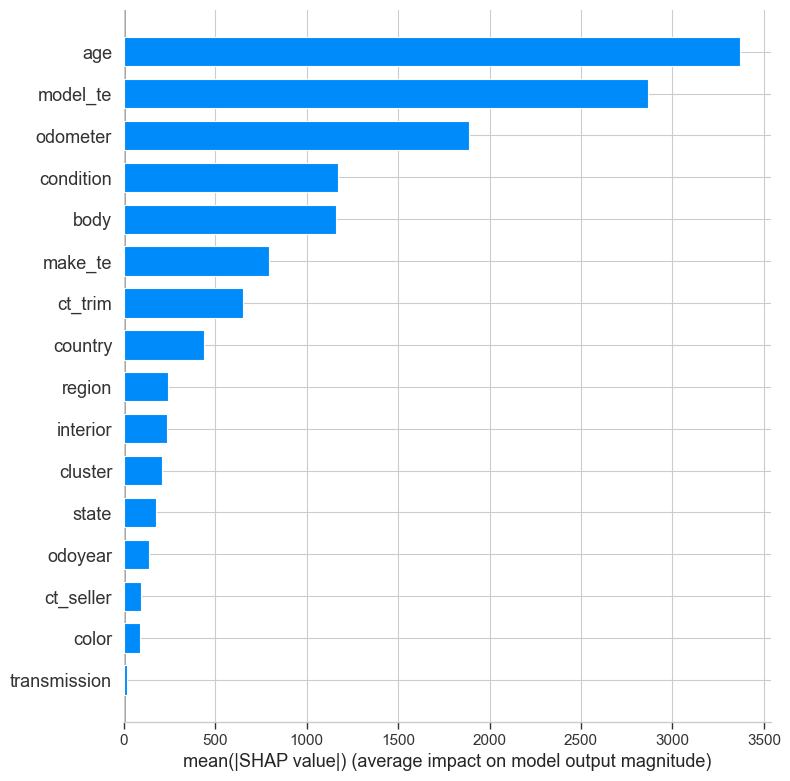

In [227]:
shap.summary_plot(shap_values, features_cbopt, plot_type='bar')

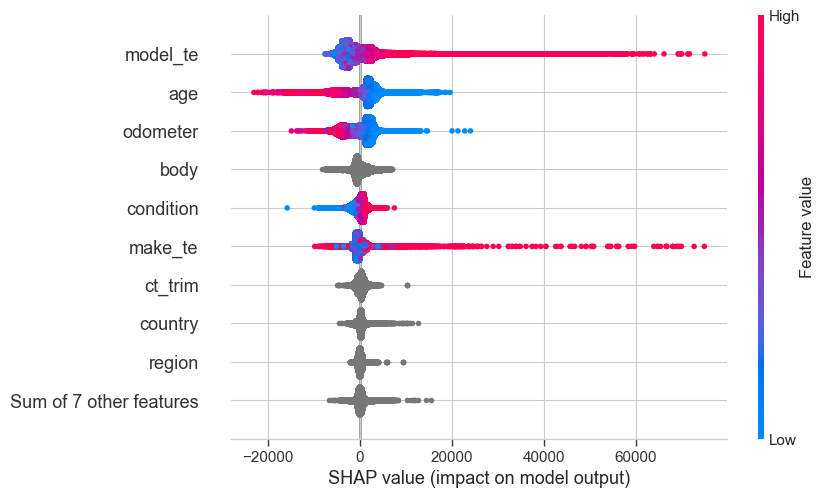

In [217]:
shap.plots.beeswarm(shap_values)

#### Original features drop last 3

**Комментарий:** Уберем из оригинального набора признаков 3 самых неинформативных и для сравнения уберем их же из модифицированного набора признаков (не сбрасываем его со счетов на случай переобучения).

In [279]:
features_cbsel = train_m.drop([
    'vin', 'saledate', 'sale_year', 'ct_make', 'ct_model', 'ct_trim', 'ct_state', 'ct_seller',
    'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year',
    'age', 'sellingprice', 'region', 'country', 'cluster', 'odoyear', 'make_te', 'model_te',
    'transmission', 'color', 'interior'
],
    axis=1).copy()

In [280]:
features_cbsel

,year,make,model,trim,body,state,condition,odometer,seller
0,2011,ford,edge,sel,suv,md,4.2,111041.0,santander consumer
1,2014,ford,fusion,se,sedan,mo,3.5,31034.0,ars avis budget group
2,2012,nissan,sentra,2.0 sl,sedan,nj,2.2,35619.0,nissan infiniti lt
3,2003,hummer,h2,base,suv,tx,2.8,131301.0,wichita falls ford lin inc
4,2007,ford,fusion,sel,sedan,md,2.0,127709.0,purple heart
...,...,...,...,...,...,...,...,...,...
436464,2013,kia,optima,ex hybrid,sedan,ca,4.5,20434.0,kia motors america inc
436465,2014,mini,cooper countryman,s all4,wagon,wi,2.9,14675.0,bmw mini financial services
436466,2008,bmw,6 series,650i,coupe,ca,3.7,102552.0,studio city auto group
436467,2014,ram,2500,slt,cab,tx,3.0,29367.0,express car truck rental


In [281]:
target_cbsel = train_m['sellingprice']

In [282]:
cat_features_cbsel = features_cbsel.select_dtypes(include='object').columns.to_list()
features_cbsel[cat_features_cbsel] = features_cbsel[cat_features_cbsel].astype('category')

In [283]:
opt_cbm.fit(features_cbsel, target_cbsel, cat_features=cat_features_cbsel)

[I 2023-12-05 12:27:10,957] A new study created in memory with name: no-name-957f7e66-3a6a-4b5c-911d-ff7c9b9a36c0
[I 2023-12-05 12:36:14,936] Trial 0 finished with value: -0.17317180473475843 and parameters: {'iterations': 1240, 'learning_rate': 0.4997465873566609, 'l2_leaf_reg': 2.381026817472084, 'max_depth': 4}. Best is trial 0 with value: -0.17317180473475843.
[I 2023-12-05 12:39:40,843] Trial 1 finished with value: -0.22666855656456728 and parameters: {'iterations': 1277, 'learning_rate': 0.1796587171877133, 'l2_leaf_reg': 5.248525479844451, 'max_depth': 2}. Best is trial 0 with value: -0.17317180473475843.
[I 2023-12-05 13:07:06,737] Trial 2 finished with value: -0.1467263842675178 and parameters: {'iterations': 948, 'learning_rate': 0.19180860068994032, 'l2_leaf_reg': 7.981353264227163, 'max_depth': 10}. Best is trial 2 with value: -0.1467263842675178.
[I 2023-12-05 13:19:02,386] Trial 3 finished with value: -0.17158895347750613 and parameters: {'iterations': 1304, 'learning_rat

OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostRegressor object at 0x151950e50>,
               n_jobs=1, n_trials=5,
               param_distributions={'iterations': IntDistribution(high=2100, log=200, low=800, step=1),
                                    'l2_leaf_reg': FloatDistribution(high=21.0, log=False, low=1.0, step=None),
                                    'learning_rate': FloatDistribution(high=0.6, log=False, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=42, scoring='neg_mean_absolute_percentage_error')

In [284]:
opt_cbm.best_params_

{'iterations': 948,
 'learning_rate': 0.19180860068994032,
 'l2_leaf_reg': 7.981353264227163,
 'max_depth': 10}

In [285]:
-opt_cbm.best_score_

0.1467263842675178

In [317]:
score_list.append(('Catboost_origfeat_reduced_optcv', 'MAPE', 0.1467263842675178))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023
9,RandomForest_target_ohe_randcv,MAPE,0.174002


#### Target transform original features drop last 3

**Комментарий:** На лучшей модели применил дополнительно логарифмирование таргета, что позволило еще немного улучшить метрику.

In [286]:
tt_cbsel = TransformedTargetRegressor(regressor=CatBoostRegressor(
    random_seed=RS,
    cat_features=cat_features_cbsel,
    iterations=948,
    learning_rate=0.19180860068994032,
    l2_leaf_reg=7.981353264227163,
    max_depth=10,
    custom_metric='MAPE',
    eval_metric='MAPE',
    verbose=False),
                                    func=np.log,
                                    inverse_func=np.exp)

In [288]:
cbsel_tt_score = -cross_val_score(
    tt_cbsel,
    features_cbsel,
    target_cbsel,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [289]:
cbsel_tt_score

0.13432652057235628

In [294]:
tt_cbsel.fit(features_cbsel, target_cbsel)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=<catboost.core.CatBoostRegressor object at 0x151950cd0>)

In [318]:
score_list.append(('Catboost_origfeat_reduced_optcv_targettransform', 'MAPE', 0.13432652057235628))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023
9,RandomForest_target_ohe_randcv,MAPE,0.174002


**Комментарий:** Лучшая модель - CatBoost на оригинальных фичах за вычетом 3 самых неинформативных (согласно SHAP: трансмиссия, цвета кузова и салона) + target transform (логарифмирование таргета для нормализации его распределения). Проверим ее на тестовых данных.

## Testing
[В начало](#0)

### Submit

In [295]:
samplesubmission

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588
...,...,...
110053,1j4aa2d17bl584330,13592.209588
110054,jthbf1d23e5007526,13592.209588
110055,1n4ba41e54c831950,13592.209588
110056,jn1az4eh3dm382431,13592.209588


In [ ]:
test_b = pd.read_csv('baseline_test.csv')

In [296]:
test_b['vin']

0         1g6dp567450124779
1         1gtw7fca7e1902207
2         jn8az1mw6dw303497
3         2g1wf5e34d1160703
4         1n6aa0ec3dn301209
                ...        
110053    1j4aa2d17bl584330
110054    jthbf1d23e5007526
110055    1n4ba41e54c831950
110056    jn1az4eh3dm382431
110057    2g1fa1e32c9193058
Name: vin, Length: 110058, dtype: object

In [292]:
features_test_cbsel = test_b.drop([
    'vin', 'saledate', 'sale_year', 'ct_make', 'ct_model', 'ct_trim', 'ct_state', 'ct_seller',
    'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year',
    'age', 'region', 'country', 'transmission', 'color', 'interior'
],
    axis=1).copy()

In [293]:
features_test_cbsel

,year,make,model,trim,body,state,condition,odometer,seller
0,2005,cadillac,cts,base,sedan,ca,2.7,116970.0,lexus of stevens creek
1,2014,gmc,savana,2500,van,pa,4.4,6286.0,u haul
2,2013,nissan,murano,s,suv,oh,4.6,11831.0,nissan infiniti lt
3,2013,chevrolet,impala,ls fleet,sedan,fl,2.3,57105.0,onemain rem auto club of miami inc dba north dad
4,2013,nissan,titan,sv,cab,tn,2.9,31083.0,nissan north america inc
...,...,...,...,...,...,...,...,...,...
110053,2011,jeep,wrangler,sport,suv,ca,3.8,66085.0,dtg operations inc
110054,2014,lexus,is 250,base,sedan,fl,4.8,17588.0,lexus financial services
110055,2004,nissan,maxima,3.5 sl,sedan,va,2.9,124036.0,shirlie slack mitsubishi
110056,2013,nissan,370z,base,coupe,tx,2.2,27169.0,nissan motor acceptance corporation


In [297]:
pred_test_cbsel = tt_cbsel.predict(features_test_cbsel)

In [298]:
samplesubmission['sellingprice'] = pred_test_cbsel

In [302]:
samplesubmission

,vin,sellingprice
0,1g6dp567450124779,3855.129554
1,1gtw7fca7e1902207,20489.499363
2,jn8az1mw6dw303497,19003.293067
3,2g1wf5e34d1160703,8999.613178
4,1n6aa0ec3dn301209,22093.066511
...,...,...
110053,1j4aa2d17bl584330,17020.076772
110054,jthbf1d23e5007526,29477.518467
110055,1n4ba41e54c831950,4675.377697
110056,jn1az4eh3dm382431,19730.062335


In [303]:
samplesubmission.to_csv('submission_cbsel_tt_opt.csv', index=False)

### Result

In [319]:
score_list.append(('Catboost_origfeat_reduced_optcv_targettransform_TEST', 'MAPE', 0.1358859))
    
pd.DataFrame(score_list, columns=['model','metric','score'])

,model,metric,score
0,Lasso_baseline,MAPE,0.610234
1,RandomForest_baseline_num_not_scaled,MAPE,0.677910
2,RandomForest_baseline_num_scaled,MAPE,0.191976
3,CatBoost_original_features,MAPE,0.170793
4,CatBoost_lowcardinality_features,MAPE,0.197330
5,ElasticNet_mutualinfo_features,MAPE,0.512737
6,RandomForest_mutualinfo_features,MAPE,0.226948
7,CatBoost_mutualinfo_features,MAPE,0.210766
8,ElasticNet_targenc_ohe_gridcv,MAPE,0.530023
9,RandomForest_target_ohe_randcv,MAPE,0.174002


**Выводы:** Результаты на тестовой выборке Score: 13.58859% (Public score: 13.39799%), что в диапазоне результатов первых 3 мест соревнования, а на практике означает, что прогнозы модели в среднем отклоняются от истинных значений примерно на 13.5%. Неплохой результат. Метрика близка к полуенной на тренировочном датасете, а значит модель не переобучилась и к измененным признакам можно не прибегать (в частности снижение кардинальности признаков было актуальнее для удобства и большей корректности обучения более простых моделей, CatBoost и сам прекрасно справляется). Для соревновательного результата можно было бы еще улучшить метрику с помощью ансамбля (бэггинга) из бустингов, но в практическом применении это не так целесообразно, если на минимуме оригинальных данных уже можно получить хороший прогноз, тем более это полезно для интерактивного веб-интерфеса, который мы реализуем с помощью данной модели.

## EXTRA: model training for usage in a web-interface (streamlit)
[В начало](#0)

**Комментарий:** для удобства взаимодействия пользователя с нашим веб-интерфейсом сократим еще пару малозначительных признаков (штат и продавец) и на всякий случай проверим, насколько критично упадет метрика.

In [9]:
features_cbst = train_m.drop([
    'vin', 'saledate', 'sale_year', 'ct_make', 'ct_model', 'ct_trim', 'ct_state', 'ct_seller',
    'ct_color', 'ct_interior', 'ct_region', 'ct_country', 'vin_model', 'vin_body', 'vin_year',
    'age', 'sellingprice', 'region', 'country', 'cluster', 'odoyear', 'make_te', 'model_te',
    'transmission', 'color', 'interior', 'state', 'seller'
],
    axis=1).copy()

In [10]:
features_cbst

,year,make,model,trim,body,condition,odometer
0,2011,ford,edge,sel,suv,4.2,111041.0
1,2014,ford,fusion,se,sedan,3.5,31034.0
2,2012,nissan,sentra,2.0 sl,sedan,2.2,35619.0
3,2003,hummer,h2,base,suv,2.8,131301.0
4,2007,ford,fusion,sel,sedan,2.0,127709.0
...,...,...,...,...,...,...,...
436464,2013,kia,optima,ex hybrid,sedan,4.5,20434.0
436465,2014,mini,cooper countryman,s all4,wagon,2.9,14675.0
436466,2008,bmw,6 series,650i,coupe,3.7,102552.0
436467,2014,ram,2500,slt,cab,3.0,29367.0


In [13]:
target_cbst = train_m['sellingprice']

In [14]:
cat_features_cbst = features_cbst.select_dtypes(include='object').columns.to_list()
features_cbst[cat_features_cbst] = features_cbst[cat_features_cbst].astype('category')

In [15]:
tt_cbst = TransformedTargetRegressor(regressor=CatBoostRegressor(
    random_seed=RS,
    cat_features=cat_features_cbst,
    iterations=948,
    learning_rate=0.19180860068994032,
    l2_leaf_reg=7.981353264227163,
    max_depth=10,
    custom_metric='MAPE',
    eval_metric='MAPE',
    verbose=False),
                                    func=np.log,
                                    inverse_func=np.exp)

In [16]:
cbst_tt_score = -cross_val_score(
    tt_cbst,
    features_cbst,
    target_cbst,
    cv=3,
    scoring='neg_mean_absolute_percentage_error').mean()

In [17]:
cbst_tt_score

0.14194159214640792

**Комментарий:** метрика немного ухудшилась, но не критично, обучим и сохраним модель для деплоя.

In [18]:
model_st = tt_cbst.fit(features_cbst, target_cbst)

In [19]:
with open('model_st.pkl', 'wb') as f_out:
    pickle.dump(model_st, f_out)

**Вывод:** Попробовать сам веб-интерфейс можно запустив приложенные в папке 'streamlit' файлы с предобработанными данными, образом модели и phyton-скриптом через сервис Streamlit.